#### Import Necessary Liberaries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt #visualize
import seaborn as sns #visualize
import re
import string


from IPython.display import Markdown, display
from PIL import Image


sns.set_style("darkgrid")
%matplotlib inline
# %load_ext nb_black
pd.set_option('display.max_colwidth', 500)




#Text cleaning
import emoji
import nltk
# from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer 
# from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from autocorrect import Speller # Library to check typos
import advertools as adv #used for looking for emojis
import emoji #remove emojis
from bs4 import BeautifulSoup #remove the http and https link
nltk.download('all', quiet=True)



#word cloud
from wordcloud import WordCloud



#feature Engineer
from sklearn.preprocessing import LabelEncoder



#feature selection
from sklearn.feature_selection import mutual_info_classif, SelectKBest



#feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams




#classification/modelling
from sklearn.linear_model import LogisticRegression #LogisticRegression
from sklearn.naive_bayes import MultinomialNB #Naive_Bayes
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.svm import LinearSVC #SVC 
from xgboost import XGBClassifier #xgboost classifier




#hyperparemeter tuning / train_test split / learning / CV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
    learning_curve,
    KFold, 
    StratifiedKFold, 
    cross_val_score, #cross_validation
    train_test_split #use to split my dataset
)




#resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek #combiniting oversampling and undersampling.



# Model Evaluation
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    # fscore_support as score
    roc_curve,
    roc_auc_score,
    balanced_accuracy_score 
)




import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

### **Dataset Information**

#### Source

The data set was taken from <a href= "https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv">kaggle.</a>

#### Annotation

- `tweet_id`: Unique identifier for each tweet
- `airline_sentiment`: The sentiment of the tweet (positive, negative, or neutral)
- `airline_sentiment_confidence`: A confidence score for the sentiment classification
- `negativereason`: The reason for the negative sentiment, if applicable
- `negativereason_confidence`: A confidence score for the negative reason classification, if applicable
- `airline`: The name of the airline being referenced in the tweet
- `airline_sentiment_gold`: The sentiment classification provided by a human annotator, if applicable
- `name`: The username of the account that posted the tweet
- `negativereason_gold`: The negative reason classification provided by a human annotator, if applicable
- `retweet_count`: The number of times the tweet has been retweeted
- `text`: The text content of the tweet
- `tweet_coord`: The coordinates of the tweet's location, if applicable
- `tweet_created`: The date and time the tweet was created
- `tweet_location`: The approximate location of the tweet, as reported by the user
- `user_timezone`: The timezone of the user who posted the tweet

## Load Dataset and Verify

In [2]:
tweets = pd.read_csv("Tweets.csv")
tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   
2   @VirginAmerica I didn't today... Must mean I need to take another trip!   

  tweet_coord              tweet_created tweet_location  \
0         NaN  2015-02-24 11:35:52 -0800            NaN   
1         NaN  2015-02-24 11:15:59 -0800            NaN   
2         NaN  2015-02-24 11:15:48 -0800      Lets Play   

                user_timezone  
0  Eastern Time (US & Canada)  
1  Pacific Time (US & Canada)  
2  Central Time (US & Canada)

In [3]:
# create a copy of the dataset
df = tweets.copy()

In [4]:
# list the columns of the dataset

df.columns.values.tolist()

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [5]:
df.shape

(14640, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
df.describe().T

count          mean           std  \
tweet_id                      14640.0  5.692184e+17  7.791112e+14   
airline_sentiment_confidence  14640.0  9.001689e-01  1.628300e-01   
negativereason_confidence     10522.0  6.382983e-01  3.304398e-01   
retweet_count                 14640.0  8.265027e-02  7.457782e-01   

                                       min           25%           50%  \
tweet_id                      5.675883e+17  5.685592e+17  5.694779e+17   
airline_sentiment_confidence  3.350000e-01  6.923000e-01  1.000000e+00   
negativereason_confidence     0.000000e+00  3.606000e-01  6.706000e-01   
retweet_count                 0.000000e+00  0.000000e+00  0.000000e+00   

                                       75%           max  
tweet_id                      5.698905e+17  5.703106e+17  
airline_sentiment_confidence  1.000000e+00  1.000000e+00  
negativereason_confidence     1.000000e+00  1.000000e+00  
retweet_count                 0.000000e+00  4.400000e+01

In [8]:
# check for nan value
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [9]:
# Check for duplicated value
df.duplicated().sum()

36

In [10]:
# check for negative vlues

# num_col = []
# for i in df.columns:
#     if df[i].dtype.name != 'object':
#         num_col.append(i)

# list comphrension
num_col = [i for i in df.columns if df[i].dtype.name != 'object']
        
# num_col

df[df[num_col] < 0].count()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            0
tweet_coord                     0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

## Data Cleaning

#### Remove Emojis

**View the emojis within the tweeks**

In [11]:
%%time
emojis = adv.extract_emoji("".join(df['text']))
emojis['top_emoji']

CPU times: total: 42.6 s
Wall time: 2min 20s


[('🙏', 125),
 ('😂', 62),
 ('✈', 57),
 ('😭', 44),
 ('👍', 42),
 ('😡', 33),
 ('😢', 32),
 ('❤', 31),
 ('😊', 31),
 ('👏', 28),
 ('😉', 20),
 ('✌', 19),
 ('😩', 18),
 ('😁', 18),
 ('😒', 17),
 ('😃', 16),
 ('👎', 16),
 ('👌', 14),
 ('🆘', 14),
 ('💙', 13),
 ('😄', 12),
 ('😔', 11),
 ('☺', 10),
 ('😍', 10),
 ('💔', 10),
 ('😕', 9),
 ('❄', 8),
 ('💗', 8),
 ('🎉', 8),
 ('😤', 8),
 ('🙌', 7),
 ('😞', 7),
 ('😜', 7),
 ('😑', 7),
 ('💕', 6),
 ('😎', 6),
 ('😀', 6),
 ('🎀', 6),
 ('🌴', 6),
 ('👠', 6),
 ('⭐', 6),
 ('😥', 5),
 ('💩', 5),
 ('😏', 5),
 ('😳', 5),
 ('😐', 5),
 ('👀', 5),
 ('💺', 4),
 ('😘', 4),
 ('♥', 4),
 ('🙅', 4),
 ('😫', 4),
 ('😖', 4),
 ('💝', 4),
 ('☀', 4),
 ('💯', 4),
 ('😠', 4),
 ('🚶', 4),
 ('🍅', 4),
 ('🌞', 3),
 ('😱', 3),
 ('😻', 3),
 ('💁', 3),
 ('😆', 3),
 ('🔵', 3),
 ('💜', 2),
 ('🍷', 2),
 ('🍸', 2),
 ('👸', 2),
 ('🌏', 2),
 ('✨', 2),
 ('👋', 2),
 ('👿', 2),
 ('😬', 2),
 ('😋', 2),
 ('🌟', 2),
 ('🍻', 2),
 ('😷', 2),
 ('⤴', 2),
 ('👊', 2),
 ('☕', 2),
 ('👺', 2),
 ('⛄', 2),
 ('😓', 2),
 ('⤵', 2),
 ('🙉', 1),
 ('💤', 1),
 ('🆖', 1),
 ('✔',

**Delete the Emoji**

In [12]:
def remove_emoji(text):
    emoji_pattern = emoji.get_emoji_regexp()
    return emoji_pattern.sub(r'', text)

# pip install emoji==1.2.0

# Apply the remove_emoji function to a pandas Series or column
df['text'] = df['text'].apply(remove_emoji)

**Verify the remove Emoji Function**

In [13]:
%%time
#verify
emojs = adv.extract_emoji("".join(df['text']))
emojs['top_emoji']

CPU times: total: 42 s
Wall time: 2min 15s


[]

Insight:

- The remove_emoji function work as expected.

#### Remove Dulicates

In [14]:
# find the duplicated rows
df[df.duplicated(keep=False)]


# print the duplicated rows
# duplicates

tweet_id airline_sentiment  airline_sentiment_confidence  \
11879  570308309682675712          negative                           1.0   
11898  570305051819941889           neutral                           1.0   
11902  570303383782989824           neutral                           1.0   
11905  570301929580048385           neutral                           1.0   
11907  570301395141836801          negative                           1.0   
...                   ...               ...                           ...   
12155  570275010759102466          negative                           1.0   
12157  570273819287531520          positive                           1.0   
12158  570273710210469888          positive                           1.0   
12159  570272880556011520          positive                           1.0   
12162  570272018840428544           neutral                           1.0   

               negativereason  negativereason_confidence   airline  \
11879  Customer Service Issue                        1.0  American   
11898                     NaN                        NaN  American   
11902                     NaN                        NaN  American   
11905                     NaN                        NaN  American   
11907             Late Flight                        1.0  American   
...                       ...                        ...       ...   
12155            Lost Luggage                        1.0  American   
12157                     NaN                        NaN  American   
12158                     NaN                        NaN  American   
12159                     NaN                        NaN  American   
12162                     NaN                        NaN  American   

      airline_sentiment_gold             name negativereason_gold  \
11879                    NaN       SweeLoTmac                 NaN   
11898                    NaN    Chandrafaythe                 NaN   
11902                    NaN   trentgillaspie                 NaN   
11905                    NaN        FinEdChat                 NaN   
11907                    NaN       JoBarredaV                 NaN   
...                      ...              ...                 ...   
12155                    NaN  paintbranch1398                 NaN   
12157                    NaN  GoldensPleasure                 NaN   
12158                    NaN           Mtts28                 NaN   
12159                    NaN         ESPartee                 NaN   
12162                    NaN  pokecrastinator                 NaN   

       retweet_count  \
11879              0   
11898              0   
11902              0   
11905              0   
11907              1   
...              ...   
12155              0   
12157              0   
12158              0   
12159              0   
12162              0   

                                                                                                                                                              text  \
11879                  @AmericanAir why would I even consider continuing your point program when I received no perks or continued bad customer service? #senseless   
11898                                             @AmericanAir my flight got Cancelled Flightled from GRK to DFW, then to LEX for tomorrow and I need it rebooked.   
11902  .@AmericanAir just disappointed with the Flight Booking Problems process and add’l fees to sit together on a more crowded flight. Not impressed so far :-/.   
11905                                                                                                                                           @AmericanAir I did   
11907                   @AmericanAir r u serious?? 304min #delay with #AmericanAirlines #AA2444 #ohio - #dallas missed my connecting flight http://t.co/DNMsblzumr   
...                                                                                                                                      

In [15]:
#remove duplicated values
df1 = df.drop_duplicates()

#### Remove Nan Values

In [16]:
# check for nan value
df1.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64

In [17]:
perf = (df1.isnull().sum()/df1.shape[0])*100
round(perf,2)

tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.28
negativereason_confidence       28.08
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.05
tweet_created                    0.00
tweet_location                  32.34
user_timezone                   32.96
dtype: float64

**Fix the missing nan values**

In [18]:
# # fill the missing values of negativereason
df1['negativereason'].fillna(value="No reason", inplace=True)


# #drop some columns
df1.drop(['tweet_coord', 'airline_sentiment_gold', 'negativereason_gold'], axis=1, inplace=True)



# print("Original Size:", df.shape)


# # fill negativereason_confidence with the median
df1['negativereason_confidence'].fillna(df1['negativereason_confidence'].median(), inplace=True)


# # fill with Unknown
df1['tweet_location'].fillna(value='Unknown', inplace=True)
df1['user_timezone'].fillna(value='Unknown', inplace=True)

In [19]:
#verify
df1.isnull().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

#### Rename a Column

In [20]:
#change airline_sentiment 
df1.rename(columns={"airline_sentiment": "sentiment"}, inplace=True)
df1.head(2)

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800        Unknown  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800        Unknown  Pacific Time (US & Canada)

#### Clean the Text Column

In [21]:
#Instantiates
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tt = TweetTokenizer()
spell = Speller(lang='en')

##### **Remove Stopwords**

In [22]:
stk = stopwords.words('english')
len(stk)

179

In [23]:
# add words to stopwords

stk.extend([
    'rt', 'via', '...', 'u', 'im', 'ur', 'u\'re', 'c', 'b', 'don',
    'amp', 'RT', '@', 'rt', 'http', 'https', 'co', 'now', 'should', 'just',
    'rts', 'retweet', 'retweets', '…', '️', 'cc' ,'a', 'an', 'the', 'and', 'or', 
    'but', 'if', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
    'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
    'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'rt', 'via', '’', '‘', '“', '”', '–', '—', '•', '➡', 'http?', 'https?',
    '➡️', '⬅', '⬅️', '👉', '👇', '👍', '🙏', '❤️', '🔥',  'u', '2', '4', 'im', 'ur',
    'AT_USER', 'URL',  '’s', '...!', '...?', '&amp;', 'amp;', 'amp', '✈️', '✡', '✨', '❤', 
    '||', '|'


])


len(stk)

315

**Text Cleaning Function**

In [24]:
%%time
def clean(sentence):
    sentence=str(sentence) #convert to strings series
    sentence = sentence.lower()  # lowercase everything 
    sentence = BeautifulSoup(sentence, 'html.parser').get_text() #remove html tags
    sentence = sentence.encode('ascii', 'ignore').decode() #encode ASCII characters
    sentence = re.sub(r'\[.*?\]', ' ', sentence) # remove square brackets
    sentence = re.sub(r'<.*?>+', ' ', sentence) # remove angular brackets
    sentence = re.sub(r"[.,!?€$&:;\-=/|()'...\"\@#_%]", ' ', sentence) # remove punctuation
    sentence = re.sub(r'@([a-zA-Z0-9_]{1,50})', ' ', sentence) # remove @mentions
    sentence = re.sub(r'^rt[\s]+', ' ', sentence) # remove RT (retweet abbreviation)
    sentence = re.sub(r'\d+', ' ', sentence) #remove numbers
    sentence = re.sub(r'\w*\d\w*', ' ', sentence) #remove words containing numbers
    sentence = sentence.strip() # remove leading and trailing white spaces


    # correct sentence and filter out word with two letter or less
    sentence_corrected = ' '.join([spell(word) for word in sentence.split() if len(word) > 2]) 

    
    tokens = tt.tokenize(sentence_corrected) # tokenize with TweetTokenizer
    
    
    filtered_words = [w for w in tokens if not w in stk] # remove stopwords 
    
    stem_words=[stemmer.stem(w) for w in filtered_words] #Stemming the words
    
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words] #Lemmatization
    
    return " ".join(filtered_words)



df1['cleanText']=df1['text'].apply(clean)

CPU times: total: 11min 5s
Wall time: 43min 17s


**Verify the Cleaning Function**

In [25]:
df1['text'].unique()[:10]

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it",
       "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
       '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
       '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
       "@virginamerica Well, I didn't…but NOW I DO! :-D",
       "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."],
      dtype=object)

In [26]:
df1['cleanText'].unique()[:10]

array(['virginamerica dhepburn said',
       'virginamerica plus added commercials experience tack',
       'virginamerica today must mean need take another trip',
       'virginamerica really aggressive blast obnoxious entertainment guests faces little recourse',
       'virginamerica really big bad thing',
       'virginamerica seriously would pay flight seats playing really bad thing flying',
       'virginamerica yes nearly every time fly ear worm wont away',
       'virginamerica really missed prime opportunity men without hats parody mpg group',
       'virginamerica well',
       'virginamerica amazing arrived hour early good'], dtype=object)

Insight:

- The text clean function worked as intended.

## EDA

In [27]:
df_clean = df1.copy()

In [28]:
df_clean.head(2)

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800        Unknown  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800        Unknown  Pacific Time (US & Canada)   

                                              cleanText  
0                           virginamerica dhepburn said  
1  virginamerica plus added commercials experience tack

### Univariate Analysis

#### Get the number of tweets

In [29]:
df_clean.tweet_id.nunique()

14485

Insight:

- There are 14,485 unique tweets.

#### Sentiment Distribution

In [30]:
df_clean.sentiment.value_counts()

negative    9159
neutral     3091
positive    2354
Name: sentiment, dtype: int64

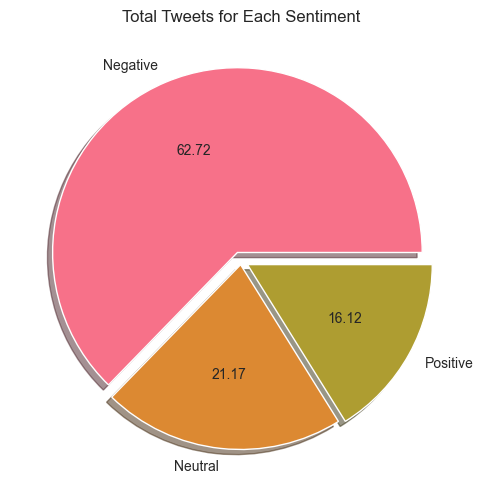

In [31]:
#visualize
colors = sns.color_palette('husl', 10)
sentiment_counts = df_clean['sentiment'].value_counts()
labels = ['Negative', 'Neutral', 'Positive']
explode = [0.05, 0.02, 0.04]

fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(sentiment_counts, colors=colors, labels=labels, explode=explode, shadow=True, autopct='%.2f')
ax.set_title("Total Tweets for Each Sentiment", fontsize=12);


Insight:

- The sentiment is largerly skew Negative.

#### Negative Reason Distribution

In [32]:
df_clean.negativereason.value_counts()

No reason                      5445
Customer Service Issue         2904
Late Flight                    1660
Can't Tell                     1190
Cancelled Flight                843
Lost Luggage                    721
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     480
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

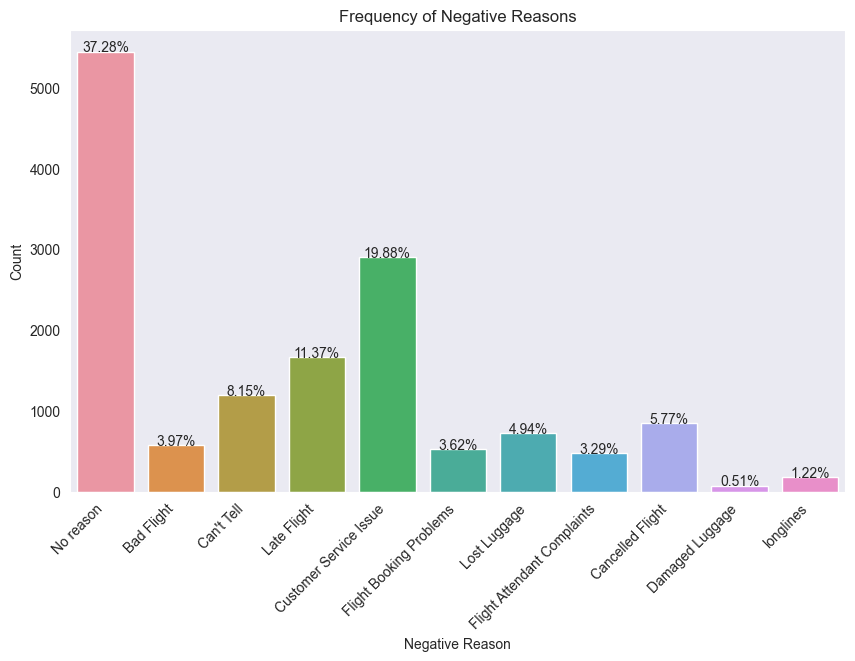

In [33]:
#visualize
plt.figure(figsize=(10,6))
ax = sns.countplot(x='negativereason', data=df_clean)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Negative Reason')
plt.ylabel('Count')
plt.title('Frequency of Negative Reasons')
plt.grid(False)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+0.5, '{:.2f}%'.format(height/len(df_clean)*100), ha="center")
plt.show()


#### Airlines

In [34]:
df_clean.airline.value_counts()

United            3822
US Airways        2913
American          2723
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

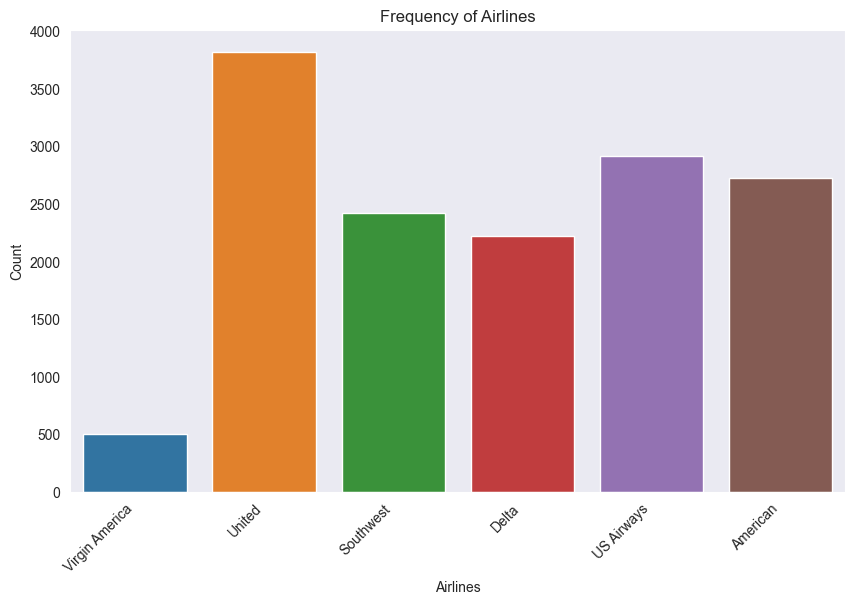

In [35]:
#visualize
plt.figure(figsize=(10,6))
ax = sns.countplot(x='airline', data=df_clean)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Airlines')
plt.ylabel('Count')
plt.title('Frequency of Airlines')
plt.grid(False);

#### Retweet_Count Distribution

In [36]:
df.retweet_count.value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
28        1
9         1
18        1
11        1
31        1
15        1
44        1
Name: retweet_count, dtype: int64

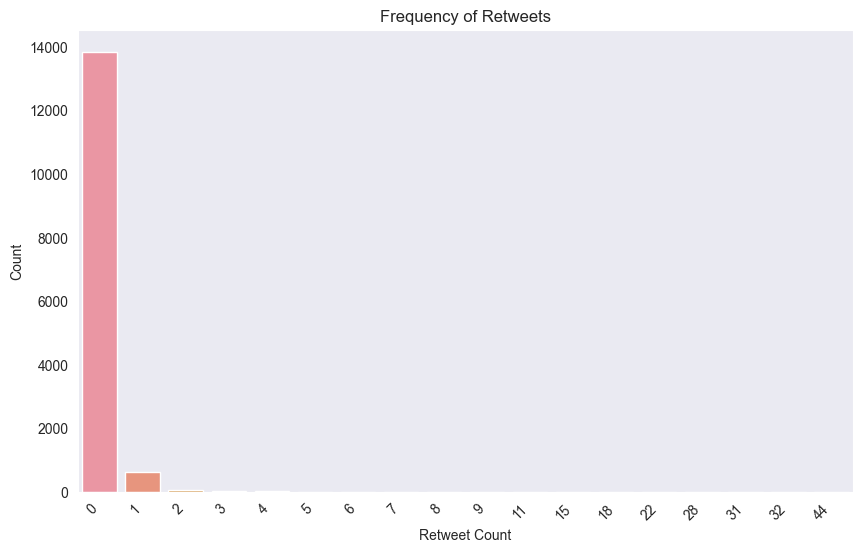

In [37]:
#visualize
plt.figure(figsize=(10,6))
ax = sns.countplot(x='retweet_count', data=df_clean)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Retweet Count')
plt.ylabel('Count')
plt.title('Frequency of Retweets')
plt.grid(False);

#### Tweet_Location

In [38]:
loc = df.tweet_location.value_counts()[:20]
loc

Boston, MA           157
New York, NY         156
Washington, DC       150
New York             127
USA                  126
Chicago              104
Los Angeles, CA       96
New York City         96
NYC                   95
San Francisco, CA     91
San Francisco         86
Chicago, IL           81
Brooklyn, NY          66
Austin, TX            64
Los Angeles           64
Washington, D.C.      63
Boston                62
Dallas, TX            54
Washington DC         53
Nashville, TN         45
Name: tweet_location, dtype: int64

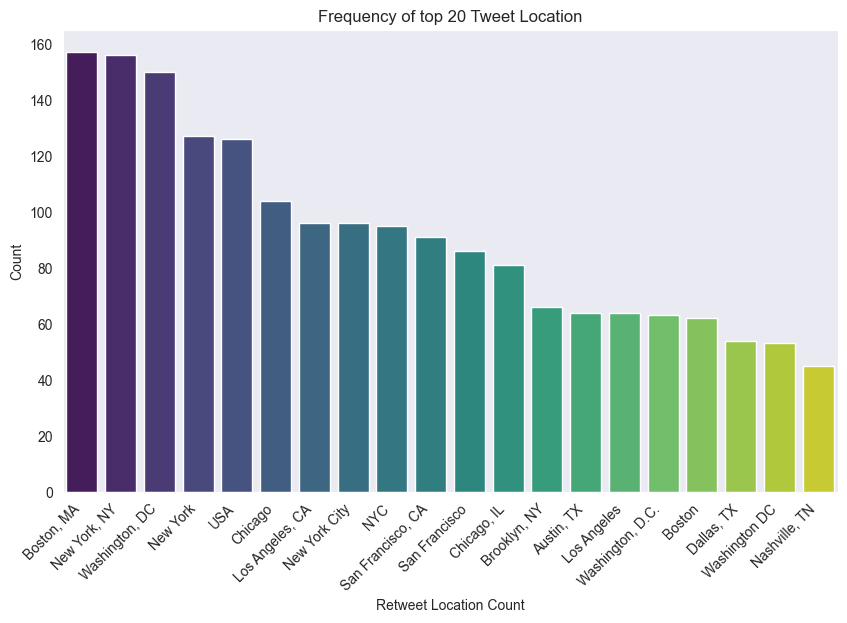

In [39]:
#visualize
plt.figure(figsize=(10,6))
ax = sns.barplot(x=loc.index, y=loc.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Retweet Location Count')
plt.ylabel('Count')
plt.title('Frequency of top 20 Tweet Location')
plt.grid(False);

#### Frequency of Tweets Posted

In [40]:
df_clean['tweet_created'] = pd.to_datetime(df_clean['tweet_created'])
df_clean['hour'] = df_clean['tweet_created'].apply(lambda x: x.hour)

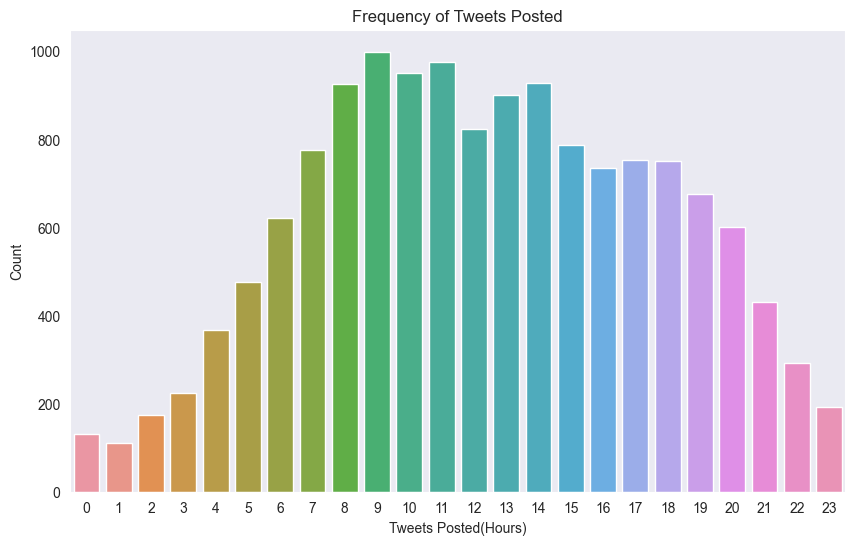

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(x='hour', data=df_clean)
plt.xlabel('Tweets Posted(Hours)')
plt.ylabel('Count')
plt.title('Frequency of Tweets Posted')
plt.grid(False);

#### Text Distribution

##### Word Count for Raw Data

In [42]:
df_clean['raw_length'] = df_clean['text'].apply(len)
df_clean.head(2)

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00        Unknown  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00        Unknown  Pacific Time (US & Canada)   

                                              cleanText  hour  raw_length  
0                           virginamerica dhepburn said    11          35  
1  virginamerica plus added commercials experience tack    11          72

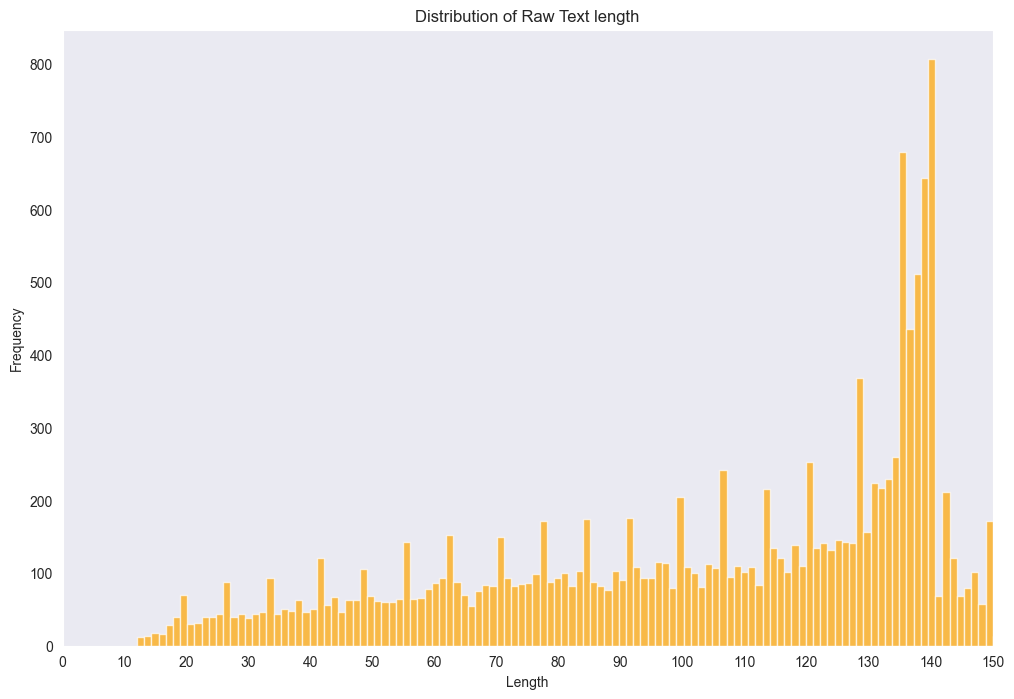

In [43]:
## visualization
plt.figure(figsize=(12,8))
bins = 150
plt.hist(df_clean['raw_length'], bins=bins, color='orange', alpha=0.7)
plt.title("Distribution of Raw Text length")
plt.xlabel('Length')
plt.ylabel('Frequency')
# plt.legend(loc='upper right')
plt.xlim(0,150)
plt.xticks(range(0, 151, 10))
plt.grid(axis='y', alpha=0.75)
plt.grid();

**Find the maximum length tweet for raw data**

In [44]:
df_clean['raw_length'].describe().T

count    14604.000000
mean       103.759792
std         36.289506
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: raw_length, dtype: float64

In [45]:
# find the tweet 
df_clean[df_clean['raw_length'] == 186]['text'].iloc[0]

"@USAirways Eyyyy! Cancelled Flightlations, Flight Booking Problemss, reFlight Booking Problemss, but y'all got me on the same flight out tonight (not tomorrow) &amp; the FC upgrade. Thx!"

##### Word Count for Clean Data

In [46]:
df_clean['clean_length'] = df_clean['cleanText'].apply(len)
df_clean.head(2)

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00        Unknown  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00        Unknown  Pacific Time (US & Canada)   

                                              cleanText  hour  raw_length  \
0                           virginamerica dhepburn said    11          35   
1  virginamerica plus added commercials experience tack    11          72   

   clean_length  
0            27  
1            52

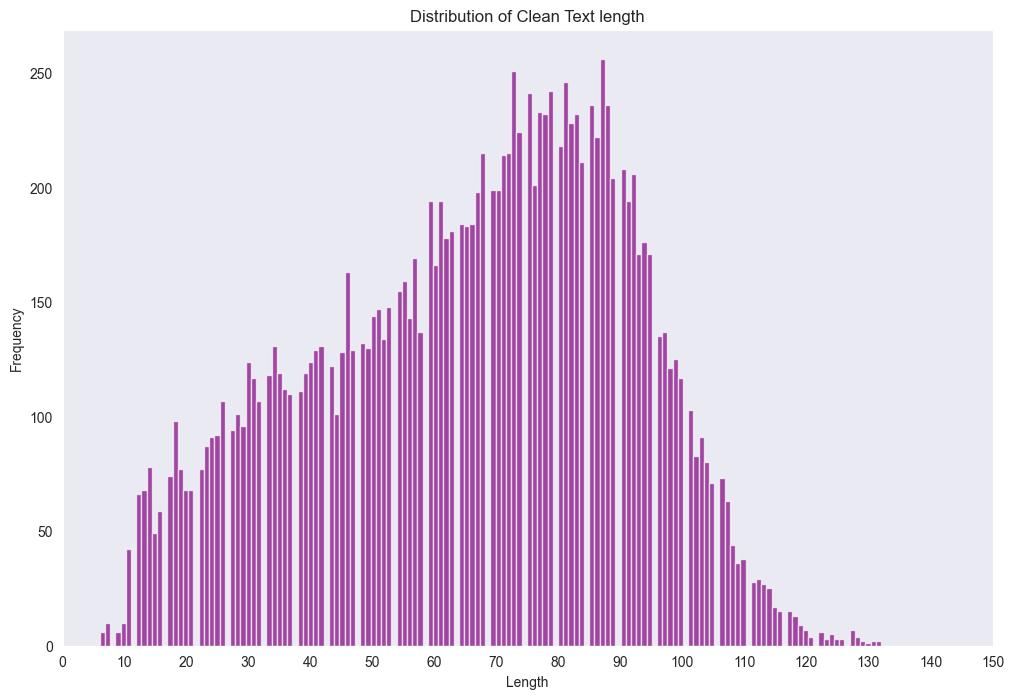

In [47]:
## visualization
plt.figure(figsize=(12,8))
bins = 150
plt.hist(df_clean['clean_length'], bins=bins, color='purple', alpha=0.7)
plt.title("Distribution of Clean Text length")
plt.xlabel('Length')
plt.ylabel('Frequency')
# plt.legend(loc='upper right')
plt.xlim(0,150)
plt.xticks(range(0, 151, 10))
plt.grid(axis='y', alpha=0.75)
plt.grid();

**Find the maximum length tweet for clean data**

In [48]:
df_clean.clean_length.describe().T

count    14604.000000
mean        65.732950
std         25.103143
min          6.000000
25%         47.000000
50%         69.000000
75%         85.000000
max        132.000000
Name: clean_length, dtype: float64

In [49]:
# find the tweet 
df_clean[df_clean['clean_length'] == 132]['cleanText'].iloc[0]

'southwestair completely understand act god weather relate flight cancelled flightlation days without reimbursement kind unacceptable'

##### Word Frequent

In [50]:
# function taken and modified 
# from https://www.kaggle.com/code/lucianfox/disaster-tweets-embeddings-ann

def word_freq_func(corpus):
    """
    This function calculates frequency of unique tokens in the corpus
    Input   : corpus :<str> entire corpus of text
    
    Returns : word_freq_df <pandas.dataframe> 
    """
    word_freq = {}
    for token in corpus.split():
        if token not in word_freq:
            word_freq[token]=1
        else:
            word_freq[token]+= 1
        
    word_freq_df = pd.DataFrame({'words': list(word_freq.keys()),'values': list(word_freq.values())})
    word_freq_df = word_freq_df.sort_values(by='values',ascending=False).reset_index(drop=True)
    
    return word_freq_df

###### **Word Frequent for Raw Data**

In [51]:
corpus_list = df_clean['text'].tolist()
corpus = " ".join(corpus_list)
vocab = list(set(corpus.split()))



word_freq_df = word_freq_func(corpus)

In [52]:
freq_df = word_freq_df[:10]
freq_df

words  values
0       to    8521
1      the    5769
2        I    5041
3        a    4353
4      for    3911
5  @united    3639
6       on    3539
7      and    3535
8      you    3228
9       my    3021

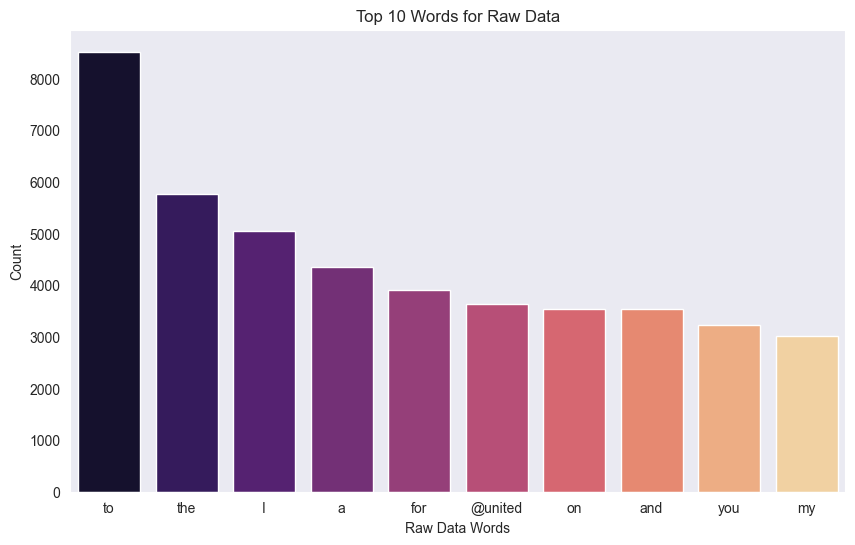

In [53]:
#visualize
plt.figure(figsize=(10,6))
colors = sns.color_palette('magma', 10)

ax = sns.barplot(x=freq_df['words'], y= freq_df['values'], palette=colors)
plt.xlabel('Raw Data Words')
plt.ylabel('Count')
plt.title('Top 10 Words for Raw Data')
plt.grid(False);

###### **Word Frequent for Clean Data**

In [54]:
corpus_lists = df_clean['cleanText'].tolist()
corpus = " ".join(corpus_lists)
vocab = list(set(corpus.split()))


word_freq_clean_df = word_freq_func(corpus)

In [55]:
clean_tweet = word_freq_clean_df[:10]
clean_tweet

words  values
0        flight    4214
1        united    4168
2       airways    3144
3     americana    2928
4  southwestair    2461
5       jetblue    2395
6           get    1345
7        thanks    1087
8     cancelled    1060
9       service     968

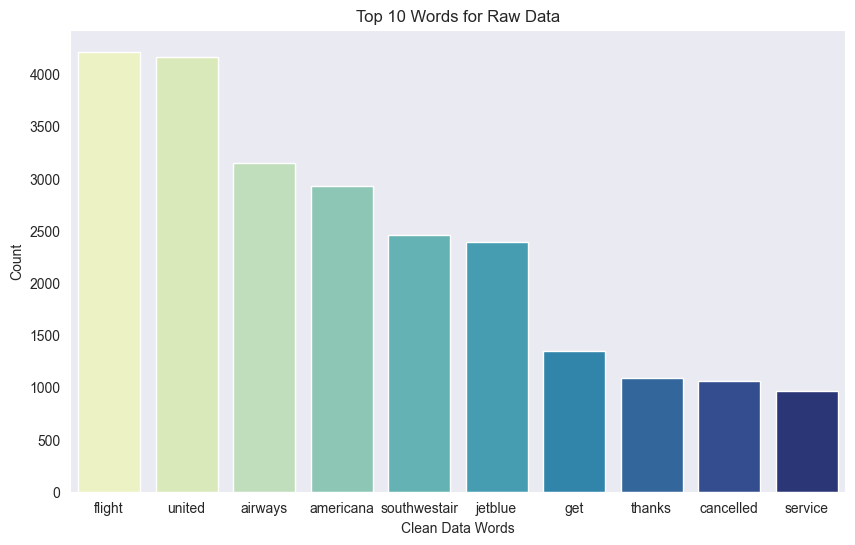

In [56]:
#visualize
plt.figure(figsize=(10,6))
colors = sns.color_palette('YlGnBu', 10)

ax = sns.barplot(x=clean_tweet['words'], y= clean_tweet['values'], palette=colors)
plt.xlabel('Clean Data Words')
plt.ylabel('Count')
plt.title('Top 10 Words for Raw Data')
plt.grid(False);

### Bivariate Analysis

#### Sentiment per Airline

In [57]:
bi = df_clean.groupby(['airline', 'sentiment'])['sentiment'].count().unstack()
bi

sentiment       negative  neutral  positive
airline                                    
American            1941      455       327
Delta                955      723       544
Southwest           1186      664       570
US Airways          2263      381       269
United              2633      697       492
Virgin America       181      171       152

Insight:

- United Airline has the highest negative sentiments. While, Virgin America has the lowest negative sentiments.
- Soutwest has the highest positive sentiments. While, Virgin America has the lowest positive sentiments.
- Delta Airline has the highest neutral sentiments. While, again has the lowest neutral sentiments.

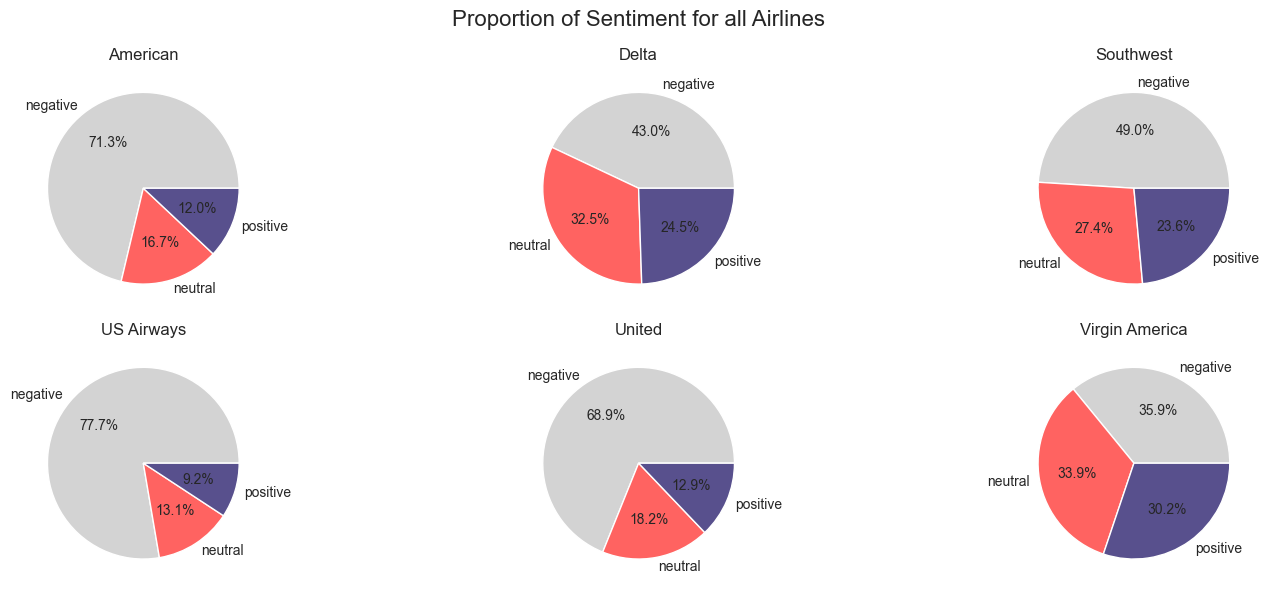

In [58]:
#visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
axes = axes.flatten()

colors = ['#d3d3d3', '#FF6361', '#58508d']

for i, ax in zip(range(0, 6), axes):
    temp = bi.iloc[i]
    ax.pie(x=temp, labels=temp.index, autopct='%.1f%%', colors=colors)
    ax.set_title(f"{bi.index[i]}")
    ax.grid(False)

plt.suptitle("Proportion of Sentiment for all Airlines", fontsize=16)
plt.tight_layout()

#### Airline by Negative Reason 

In [59]:
ni = df_clean.groupby(['airline', 'negativereason'])['negativereason'].count().unstack()
ni

negativereason  Bad Flight  Can't Tell  Cancelled Flight  \
airline                                                    
American                87         198               242   
Delta                   64         186                51   
Southwest               90         159               162   
US Airways             104         246               189   
United                 216         379               181   
Virgin America          19          22                18   

negativereason  Customer Service Issue  Damaged Luggage  \
airline                                                   
American                           762               12   
Delta                              199               11   
Southwest                          391               14   
US Airways                         811               11   
United                             681               22   
Virgin America                      60                4   

negativereason  Flight Attendant Complaints  Flight Booking Problems  \
airline                                                                
American                                 86                      130   
Delta                                    60                       44   
Southwest                                38                       61   
US Airways                              123                      122   
United                                  168                      144   
Virgin America                            5                       28   

negativereason  Late Flight  Lost Luggage  No reason  longlines  
airline                                                          
American                244           146        782         34  
Delta                   269            57       1267         14  
Southwest               152            90       1234         29  
US Airways              453           154        650         50  
United                  525           269       1189         48  
Virgin America           17             5        323          3

Insight:

- negativereason (No reason) has the highest value with all airline but this is not right.
- No reason was created during the cleaning process of the dataset. It was nan value.

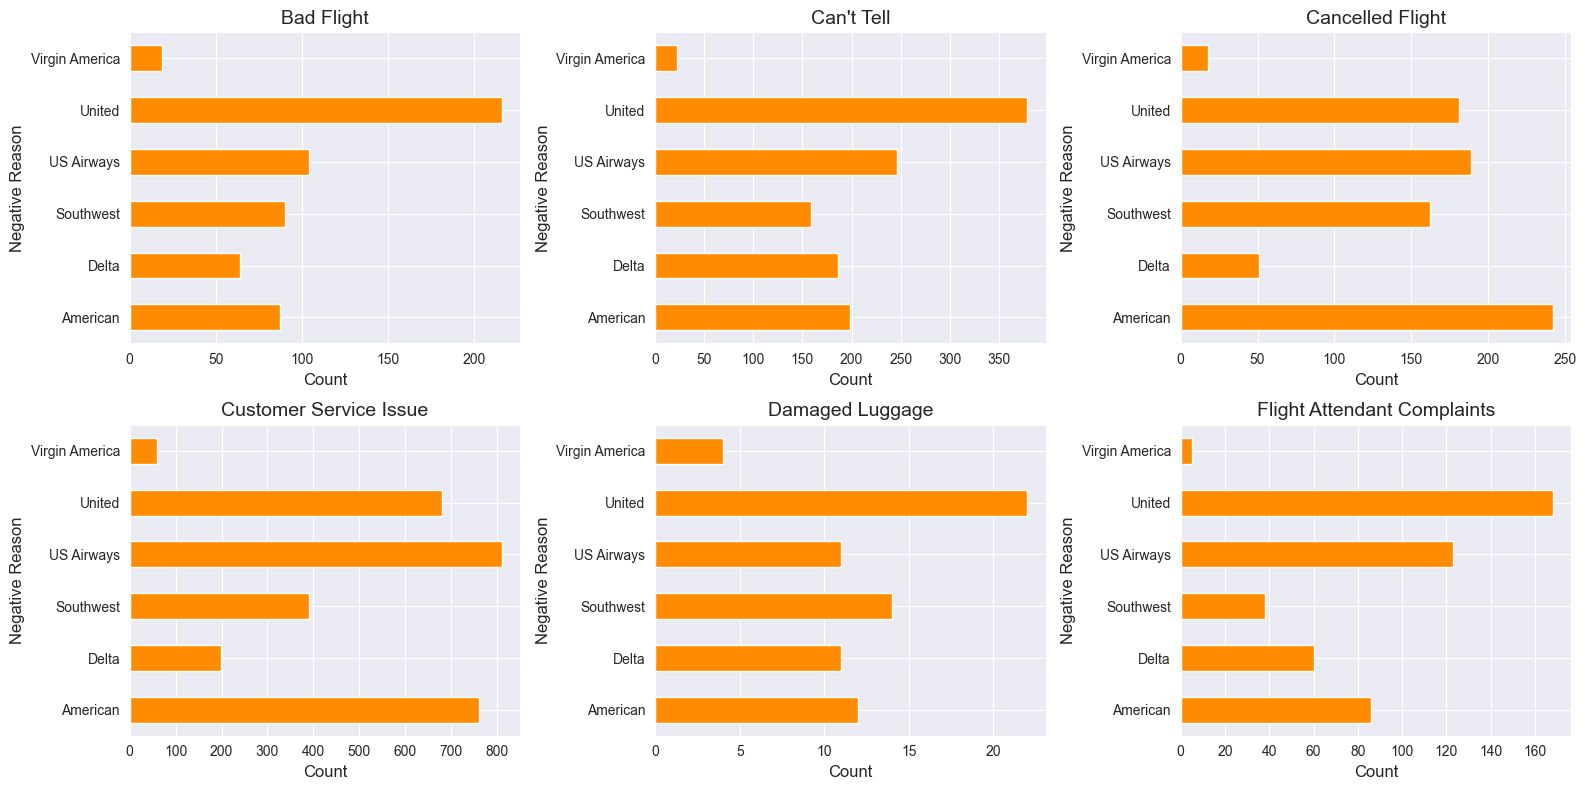

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, (airline, data) in enumerate(ni.items()):
    if i < len(axes):
        row, col = divmod(i, 3)
        data.plot(kind='barh', ax=axes[i], color='darkorange')
        axes[i].set_title(airline, fontsize=14)
        axes[i].set_xlabel('Count', fontsize=12)
        axes[i].set_ylabel('Negative Reason', fontsize=12)

plt.tight_layout()
plt.show()


#### Negative Reasons by Airline

In [61]:
ia = df_clean.groupby(['negativereason', 'airline'])['airline'].count().unstack()
ia

airline                      American  Delta  Southwest  US Airways  United  \
negativereason                                                                
Bad Flight                         87     64         90         104     216   
Can't Tell                        198    186        159         246     379   
Cancelled Flight                  242     51        162         189     181   
Customer Service Issue            762    199        391         811     681   
Damaged Luggage                    12     11         14          11      22   
Flight Attendant Complaints        86     60         38         123     168   
Flight Booking Problems           130     44         61         122     144   
Late Flight                       244    269        152         453     525   
Lost Luggage                      146     57         90         154     269   
No reason                         782   1267       1234         650    1189   
longlines                          34     14         29          50      48   

airline                      Virgin America  
negativereason                               
Bad Flight                               19  
Can't Tell                               22  
Cancelled Flight                         18  
Customer Service Issue                   60  
Damaged Luggage                           4  
Flight Attendant Complaints               5  
Flight Booking Problems                  28  
Late Flight                              17  
Lost Luggage                              5  
No reason                               323  
longlines                                 3

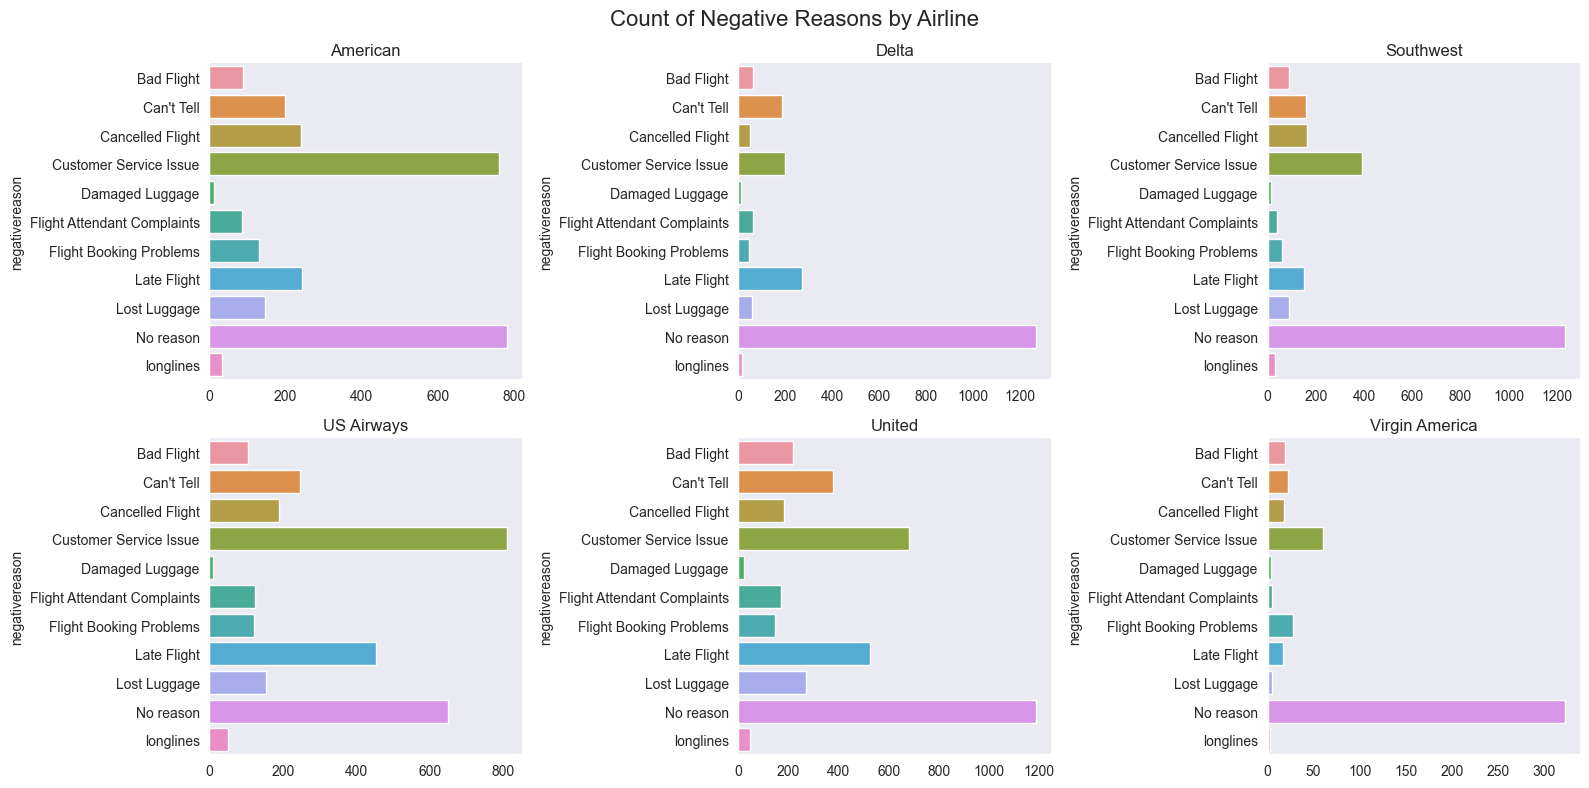

In [62]:
# Generate the crosstab table of negative reasons by airline
ni = pd.crosstab(df_clean['airline'], df_clean['negativereason'])

# Define the layout of the plot
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.reshape(2, 3)  # reshape the axes array

# Iterate over each airline and plot the corresponding bar plot
for i, airline in enumerate(ni.index):
    row = i // 3
    col = i % 3
    data = ni.loc[airline]
    sns.barplot(x=data.values, y=data.index, ax=axes[row, col])
    axes[row, col].set_title(airline)
    sns.despine() # remove the top and right spines
    axes[row, col].grid(False)  # remove the grid

# Add titles and adjust the layout
fig.suptitle('Count of Negative Reasons by Airline', fontsize=16)
plt.tight_layout()
plt.show()


#### Retweet Count by Sentiment

In [63]:
# Group data by sentiment and calculate mean retweet count
retweet_sentiment = df_clean.groupby('sentiment')['retweet_count'].mean().mul(100).reset_index()
retweet_sentiment

sentiment  retweet_count
0  negative       9.345998
1   neutral       6.114526
2  positive       6.966865

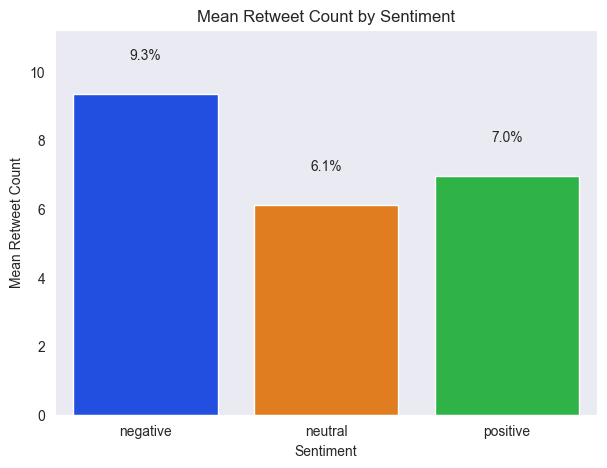

In [64]:
# Define the color palette for the plot
colors = sns.color_palette('bright', n_colors=len(retweet_sentiment))

# Plot the data in a bar chart with different colors for each sentiment
ax = sns.barplot(x='sentiment', y='retweet_count', data=retweet_sentiment, palette=colors)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.1f}%', ha='center')

# Set the axis labels and title
ax.set_xlabel('Sentiment')
ax.set_ylabel('Mean Retweet Count')
ax.set_title('Mean Retweet Count by Sentiment')

# Set the size of the bars and remove the grid
sns.set_style('white')
ax.set(ylim=(0, retweet_sentiment['retweet_count'].max()*1.2))
ax.grid(False)
ax.figure.set_size_inches(7, 5)

plt.show()

#### Geographical Pattern 

In [65]:
df_clean[:2]

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00        Unknown  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00        Unknown  Pacific Time (US & Canada)   

                                              cleanText  hour  raw_length  \
0                           virginamerica dhepburn said    11          35   
1  virginamerica plus added commercials experience tack    11          72   

   clean_length  
0            27  
1            52

### Word Cloud

In [66]:
df_clean.head(2)

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00        Unknown  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00        Unknown  Pacific Time (US & Canada)   

                                              cleanText  hour  raw_length  \
0                           virginamerica dhepburn said    11          35   
1  virginamerica plus added commercials experience tack    11          72   

   clean_length  
0            27  
1            52

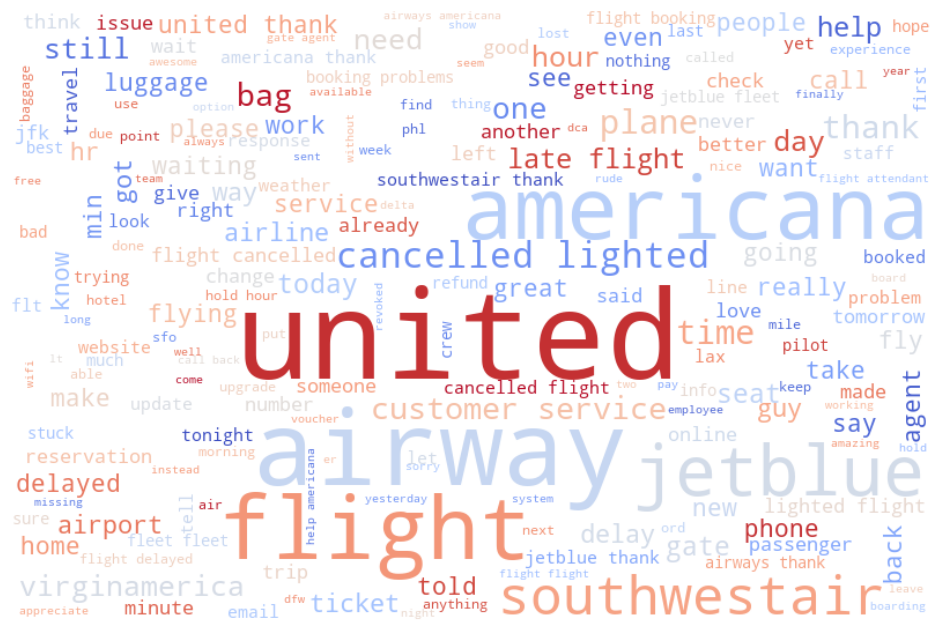

In [67]:
plt.figure(figsize=(12,8))

mask = np.array(Image.open('tweet2.jpg'))
wordcloud_ip = WordCloud(
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=mask,
                      colormap='coolwarm'
                     ).generate(' '.join(df_clean['cleanText']))
plt.grid(None)
plt.imshow(wordcloud_ip, interpolation='bilinear')
plt.axis('off');

In [68]:
# Get the top 5 words from the word cloud
word_frequencies = wordcloud_ip.process_text(' '.join(df_clean['cleanText']))
top_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 words
print("Top 5 words from the word cloud:")
print("")
for word, frequency in top_words:
    print(word, frequency)

Top 5 words from the word cloud:

united 3500
airway 2527
americana 2274
flight 2264
jetblue 1984


**Word Cloud Function for all Value in the Sentiment Column**

In [69]:
# # Define a function to create a word cloud and show the top 5 words
# def create_wordcloud(sentiment):
#     # Get all the words from the "sentiment" column that match the given sentiment value
#     words = df_clean[df_clean['sentiment'] == sentiment]['cleanText']

#     # Concatenate all the words into a single string
#     words_string = ' '.join(words)

#     # Split the words into a list
#     word_list = words_string.split()

#     # Create a dictionary to store the word frequencies
#     word_freq = {}

#     # Loop through the word list and update the frequency count for each word
#     for word in word_list:
#         if word in word_freq:
#             word_freq[word] += 1
#         else:
#             word_freq[word] = 1

#     # Create a WordCloud object with the desired settings
#     wordcloud = WordCloud(width = 800, height = 800, 
#                 background_color ='gray', 
#                 # stopwords = set(), 
#                 min_font_size = 10).generate_from_frequencies(word_freq)

#     # Plot the word cloud using matplotlib
#     plt.figure(figsize = (8, 8), facecolor = None) 
#     plt.imshow(wordcloud) 
#     plt.axis("off") 
#     plt.tight_layout(pad = 0) 
#     plt.title(f"Words associated with {sentiment} sentiment")

#     # Display the word cloud
#     plt.show()

#     # Get the top 5 words and their frequencies as a list of tuples
#     top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

#     # Print the top 5 words for the given sentiment value
#     print(f'Top 5 words for {sentiment} sentiment:')
#     for word, freq in top_words:
#         print(f'{word}: {freq}')

# # Call the create_wordcloud function for each sentiment value
# create_wordcloud('negative')
# create_wordcloud('neutral')
# create_wordcloud('positive')

##### **Word Cloud for clean text sentiment(negative)**

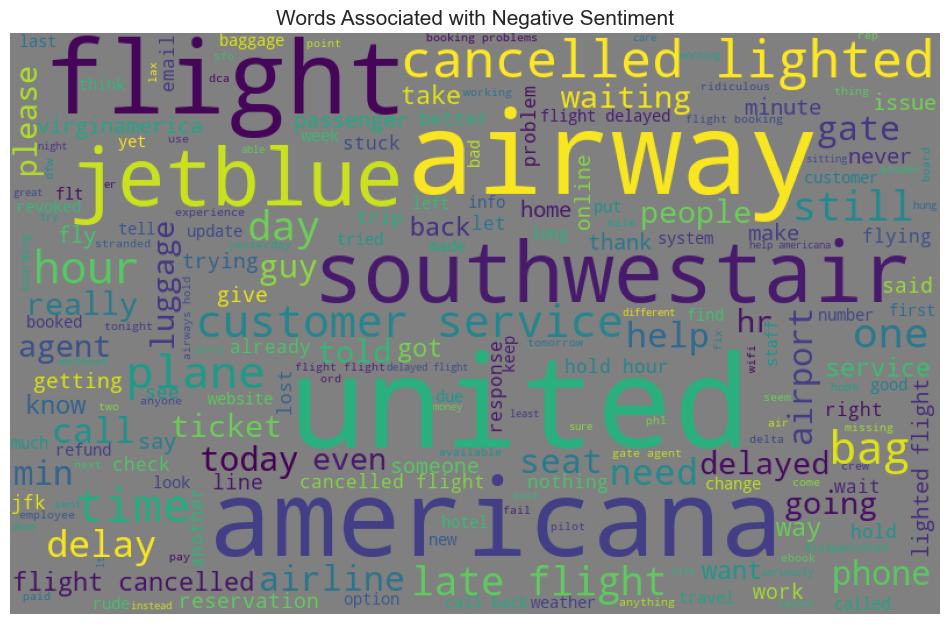

In [70]:
#Visualizing all the informative in column 
# negative_word =' '.join([text for text in df_clean['cleanText'][df_clean['sentiment'] == 'negative']])
negative_word = ' '.join(df_clean[df_clean['sentiment'] == 'negative']['cleanText'])


wordcloud_neg = WordCloud(
    background_color='gray',
    width=800, 
    height=500, 
    random_state=21, 
    max_font_size=110
).generate(negative_word)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_neg)
# plt.axis('off')
plt.grid(None)
plt.title("Words Associated with Negative Sentiment", fontsize=15)
plt.axis("off");

In [71]:
# Use WordCloud method 'process_text' to generate a dictionary of word frequencies
neg_word_freq = WordCloud().process_text(negative_word)

# Sort the dictionary by frequency and return the top 5 most frequent words
top_5_neg_words = sorted(neg_word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 words
for word, freq in top_5_neg_words:
    print(f"{word}: {freq}")

united: 2617
airway: 2082
americana: 1773
flight: 1598
southwestair: 1077


##### **Word Cloud for clean text sentiment(neutral)**

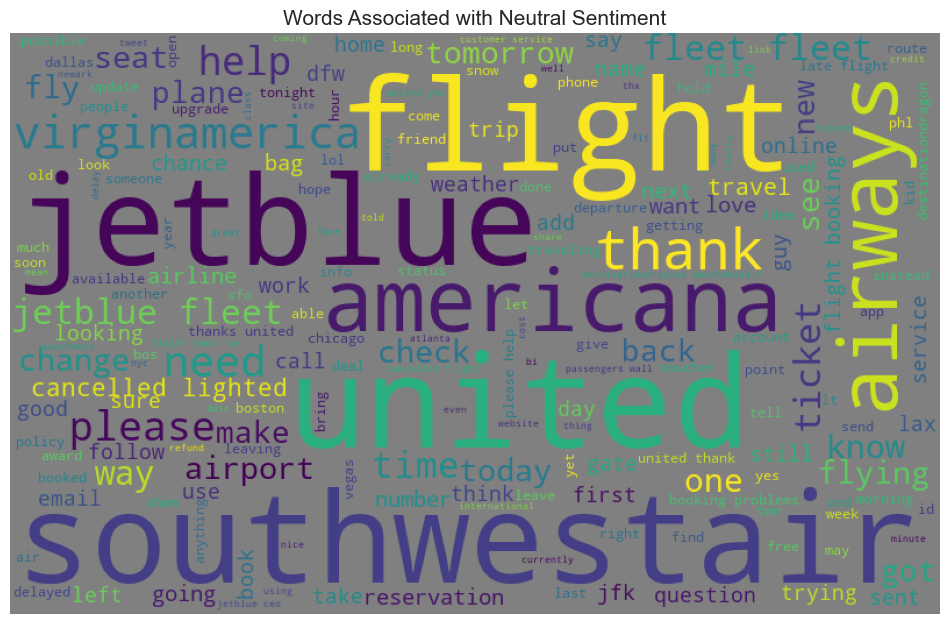

In [72]:
#Visualizing all the informative in column 
neutral_word = ' '.join(df_clean[df_clean['sentiment'] == 'neutral']['cleanText'])
# ' '.join([text for text in df_clean['cleanText'][df_clean['sentiment'] == 'neutral']])
    # words = ' '.join(df_clean[df_clean['sentiment'] == sentiment]['text'])


wordcloud_neu = WordCloud(
    background_color='gray',
    width=800, 
    height=500, 
    random_state=21, 
    max_font_size=110
).generate(neutral_word)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_neu)
# plt.axis('off')
plt.grid(None)
plt.title("Words Associated with Neutral Sentiment", fontsize=15)
plt.axis("off");

In [73]:
# Use WordCloud method 'process_text' to generate a dictionary of word frequencies
neu_word_freq = WordCloud().process_text(neutral_word)

# Sort the dictionary by frequency and return the top 5 most frequent words
top_5_neu_words = sorted(neu_word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 words
for word, freq in top_5_neu_words:
    print(f"{word}: {freq}")

united: 668
flight: 651
southwestair: 638
jetblue: 624
americana: 491


##### **Word Cloud for clean text sentiment(positive)**

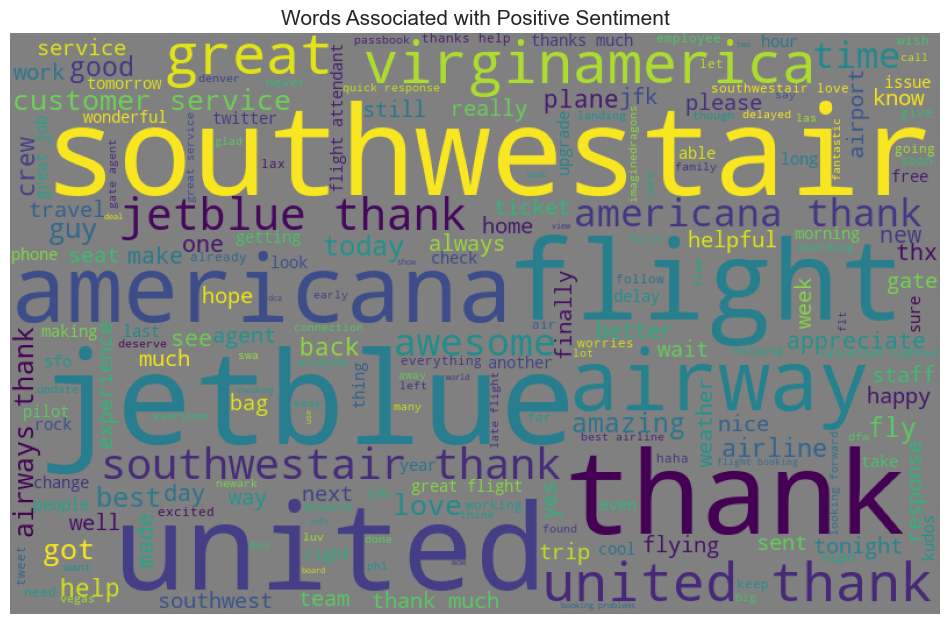

In [74]:
#Visualizing all the informative in column 
positive_word = ' '.join(df_clean[df_clean['sentiment'] == 'positive']['cleanText'])
# ' '.join([text for text in df_clean['cleanText'][df_clean['sentiment'] == 'neutral']])
    # words = ' '.join(df_clean[df_clean['sentiment'] == sentiment]['text'])


wordcloud_pos = WordCloud(
    background_color='gray',
    width=800, 
    height=500, 
    random_state=21, 
    max_font_size=110
).generate(positive_word)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud_pos)
# plt.axis('off')
plt.grid(None)
plt.title("Words Associated with Positive Sentiment", fontsize=15)
plt.axis("off");

In [75]:
# Use WordCloud method 'process_text' to generate a dictionary of word frequencies
pos_word_freq = WordCloud().process_text(positive_word)

# Sort the dictionary by frequency and return the top 5 most frequent words
top_5_pos_words = sorted(pos_word_freq.items(), key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 words
for word, freq in top_5_pos_words:
    print(f"{word}: {freq}")

jetblue: 450
southwestair: 416
united: 394
thank: 365
flight: 337


## Feature Engineering

In [76]:
## Label Encoder

# creating a copy from original dataframe
df_tran = df_clean.copy()  

# Instantiate Label Encoder
lanc = LabelEncoder()

# Fit & Transform data
df_tran["sentiment"] = lanc.fit_transform(df_tran["sentiment"])

In [77]:
## Classes of label encoder in label
for ix, i in enumerate(lanc.classes_):
    print(ix, i)

0 negative
1 neutral
2 positive


In [78]:
df_clean['sentiment_encode'] = df_tran['sentiment']
df_clean[:2]

tweet_id sentiment  airline_sentiment_confidence negativereason  \
0  570306133677760513   neutral                        1.0000      No reason   
1  570301130888122368  positive                        0.3486      No reason   

   negativereason_confidence         airline      name  retweet_count  \
0                     0.6705  Virgin America   cairdin              0   
1                     0.0000  Virgin America  jnardino              0   

                                                                       text  \
0                                       @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials to the experience... tacky.   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00        Unknown  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00        Unknown  Pacific Time (US & Canada)   

                                              cleanText  hour  raw_length  \
0                           virginamerica dhepburn said    11          35   
1  virginamerica plus added commercials experience tack    11          72   

   clean_length  sentiment_encode  
0            27                 1  
1            52                 2

## Train-Test Split

In [79]:
X = df_tran['cleanText']
y = df_tran['sentiment']

X.shape, y.shape

((14604,), (14604,))

In [80]:
#split the dataset into training (70%) and testing (30%). 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10222,), (10222,), (4382,), (4382,))

## Feature Extraction

- I will be using TfidfVectorizer instead of CountVectorizer. TfidfVectorizer take into account of the importance of each word in the document and the corpus.

**TfidfVectorizer**

In [81]:
# create and fit the TfidfVectorizer on the training set
vec = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 3), max_features=1250)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

In [82]:
# convert the sparse matrix to a dense array and create a dataframe with the feature names as columns
X_train_df = pd.DataFrame(X_train_vec.toarray(), columns=vec.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_vec.toarray(), columns=vec.get_feature_names_out())

# print the first 5 rows of the training set feature matrix
X_train_df

able  absolutely  acceptable  access  account  actual  actually  \
0       0.0         0.0         0.0     0.0      0.0     0.0       0.0   
1       0.0         0.0         0.0     0.0      0.0     0.0       0.0   
2       0.0         0.0         0.0     0.0      0.0     0.0       0.0   
3       0.0         0.0         0.0     0.0      0.0     0.0       0.0   
4       0.0         0.0         0.0     0.0      0.0     0.0       0.0   
...     ...         ...         ...     ...      ...     ...       ...   
10217   0.0         0.0         0.0     0.0      0.0     0.0       0.0   
10218   0.0         0.0         0.0     0.0      0.0     0.0       0.0   
10219   0.0         0.0         0.0     0.0      0.0     0.0       0.0   
10220   0.0         0.0         0.0     0.0      0.0     0.0       0.0   
10221   0.0         0.0         0.0     0.0      0.0     0.0       0.0   

            add  added  address  ...  wrong  wtf  yeah  year  year old  years  \
0      0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
1      0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
2      0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
3      0.438734    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
4      0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
...         ...    ...      ...  ...    ...  ...   ...   ...       ...    ...   
10217  0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
10218  0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
10219  0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
10220  0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   
10221  0.000000    0.0      0.0  ...    0.0  0.0   0.0   0.0       0.0    0.0   

       yes  yesterday  yet  zero  
0      0.0        0.0  0.0   0.0  
1      0.0        0.0  0.0   0.0  
2      0.0        0.0  0.0   0.0  
3      0.0        0.0  0.0   0.0  
4      0.0        0.0  0.0   0.0  
...    ...        ...  ...   ...  
10217  0.0        0.0  0.0   0.0  
10218  0.0        0.0  0.0   0.0  
10219  0.0        0.0  0.0   0.0  
10220  0.0        0.0  0.0   0.0  
10221  0.0        0.0  0.0   0.0  

[10222 rows x 1250 columns]

In [83]:
# print the shape of the training and testing feature matrices and target variables
print(X_train_df.shape, y_train.shape, X_test_df.shape, y_test.shape)

(10222, 1250) (10222,) (4382, 1250) (4382,)


Insight:

- Out of 1801 features, i pick the top 70%(1250)

## Model Selection

For this project, I will be using 5 different types of algor. 

- Logistic Regression
- SVC
- Naive Bayes
- Random Forest
- XGBoost

**Classification Metrices Function**

In [84]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    # # compute the confusion matrix
    # cm = confusion_matrix(target, pred)

    # compute metrics
    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average="weighted")  # to compute Recall
    precision = precision_score(target, pred, average="weighted")  # to compute Precision
    f1 = f1_score(target, pred, average="weighted")  # to compute F1-score
    cls_report = classification_report(target, pred)  # to compute classification report

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


**Confusion Matrix Function**

In [85]:
def confusion_matrix_sentiment(model, predictors, target):
    
    # Create confusion matrix
    conf_mat = confusion_matrix(target, model.predict(predictors))

    # Print and plot Confusion matrix to get an idea of how the distribution of the prediction is, among all the classes.
    df_cm = pd.DataFrame(
        conf_mat,
        index=["Actual Negative", "Actual Neutral", "Actual Positive"],
        columns=["Predicted Negative", "Predicted Neutral", "Predicted Positive"],
    )
    plt.figure(figsize=(8, 5))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt="g")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


### **Modeling with Imbalanced Target Variable**

In [86]:
df_clean.sentiment.value_counts(normalize=True).mul(100)

negative    62.715694
neutral     21.165434
positive    16.118872
Name: sentiment, dtype: float64

#### **Logistic Regression**

In [87]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_vec, y_train)


print("Train Performance")
lr_train = model_performance_classification_sklearn(lr, X_train_vec, y_train)
lr_train

Train Performance


Accuracy    Recall  Precision        F1
0  0.818724  0.818724    0.81411  0.810464

In [88]:
print("Test Performance")
lr_test = model_performance_classification_sklearn(lr, X_test_vec, y_test)
lr_test

Test Performance


Accuracy    Recall  Precision        F1
0  0.785714  0.785714   0.775618  0.775532

**Learning Curve for Logistic Regression Base**

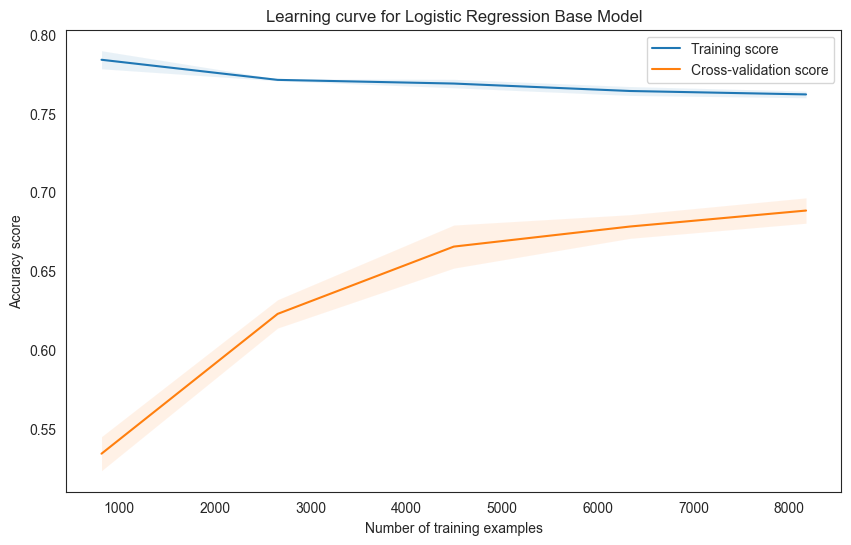

In [89]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(lr, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning curve for Logistic Regression Base Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Logistic Regression Base**

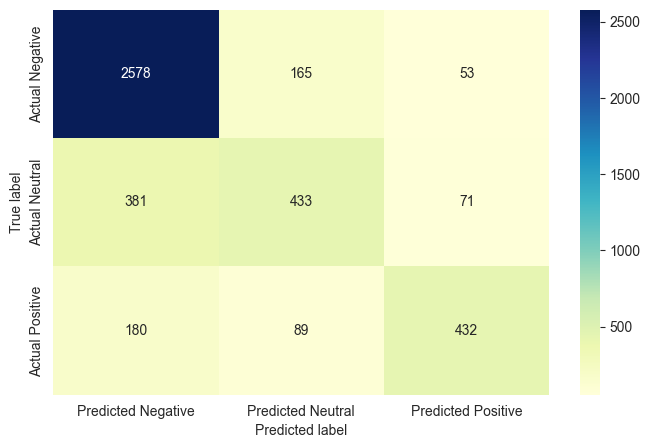

In [90]:
confusion_matrix_sentiment(lr, X_test_vec, y_test)

**Receiver Operating Characteristic(Logistic Regression)**

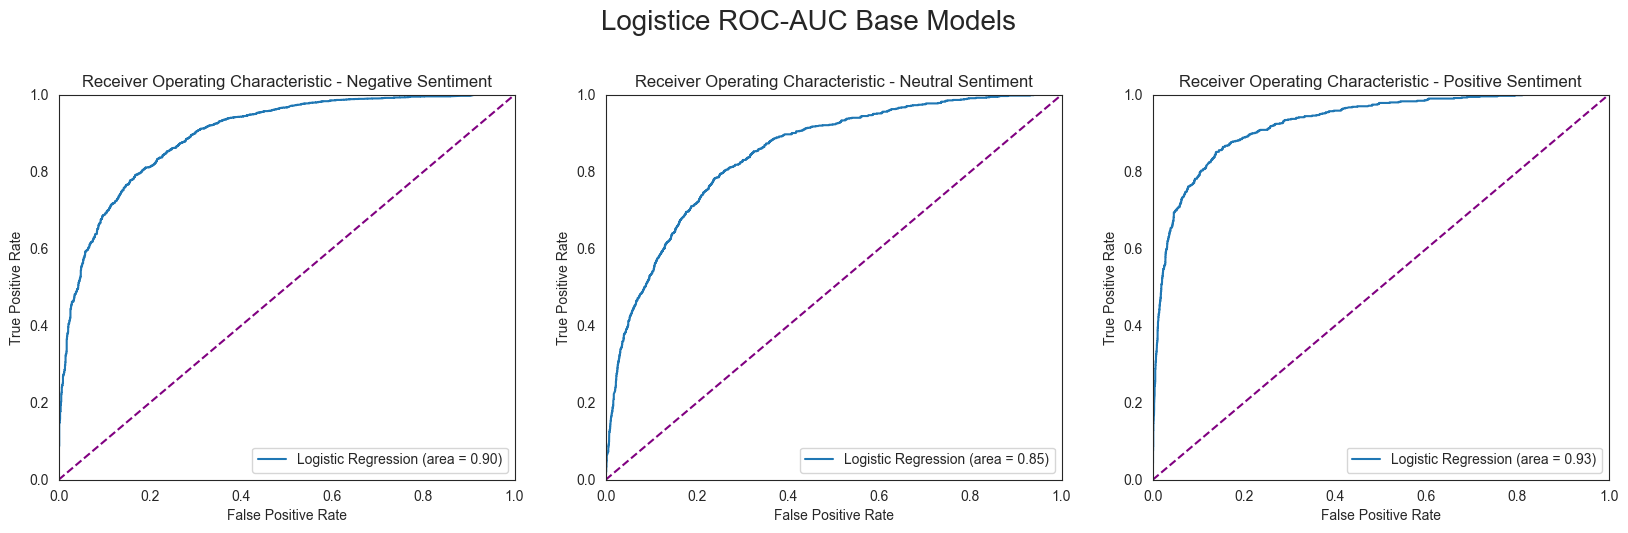

In [91]:
# Calculate AUC score for each sentiment value
log_roc_auc_0 = roc_auc_score(y_test == 0, lr.predict_proba(X_test_vec)[:, 0])
log_roc_auc_1 = roc_auc_score(y_test == 1, lr.predict_proba(X_test_vec)[:, 1])
log_roc_auc_2 = roc_auc_score(y_test == 2, lr.predict_proba(X_test_vec)[:, 2])
# print("logit_roc_auc_0:", log_roc_auc_0)
# print("logit_roc_auc_1:", log_roc_auc_1)
# print("logit_roc_auc_2:", log_roc_auc_2)

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, lr.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, lr.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, lr.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Logistic Regression (area = %0.2f)' % log_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Logistic Regression (area = %0.2f)' % log_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Logistic Regression (area = %0.2f)' % log_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

plt.suptitle("Logistice ROC-AUC Base Models", fontsize=20, y=1.05)

plt.show()


##### **Tunned Paremeter Logistic Regression**

In [92]:
%%time
## Tunning the logistic Regression model
# defining model
lr1 = LogisticRegression(random_state=42)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter' : [50, 100, 150, 200]
}



grid_cv = GridSearchCV(
    estimator=lr1,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_vec, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'} with CV score=0.6911430604926551:
CPU times: total: 1.94 s
Wall time: 54.9 s


In [93]:
lr_tuned = LogisticRegression( 
    C = 1, 
    max_iter = 50, 
    penalty = 'l2', 
    solver = 'lbfgs')

lr_tuned.fit(X_train_vec, y_train)

LogisticRegression(C=1, max_iter=50)

In [94]:
## Checking model performance

# Calculating different metrics on train set
lr_tunned_train = model_performance_classification_sklearn(
    lr_tuned, X_train_vec, y_train)

print("Training performance:")
print(lr_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
lr_tunned_test = model_performance_classification_sklearn(
    lr_tuned, X_test_vec, y_test)

print("Testing performance:")
print(lr_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.817844  0.817844   0.813143  0.809546

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.786171  0.786171   0.775992  0.775855


**Learning curve for Logistic Regression Tuned**

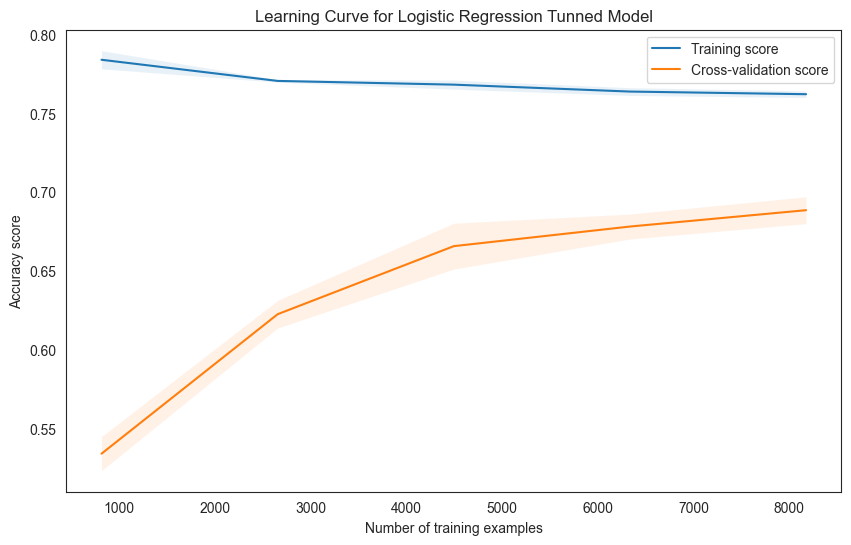

In [95]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(lr_tuned, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Logistic Regression Tunned Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Logistic Regression Tuned**

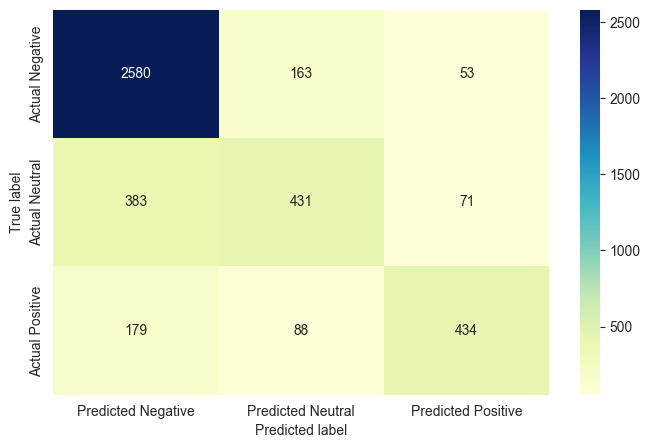

In [96]:
confusion_matrix_sentiment(lr_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for lr Tuned**

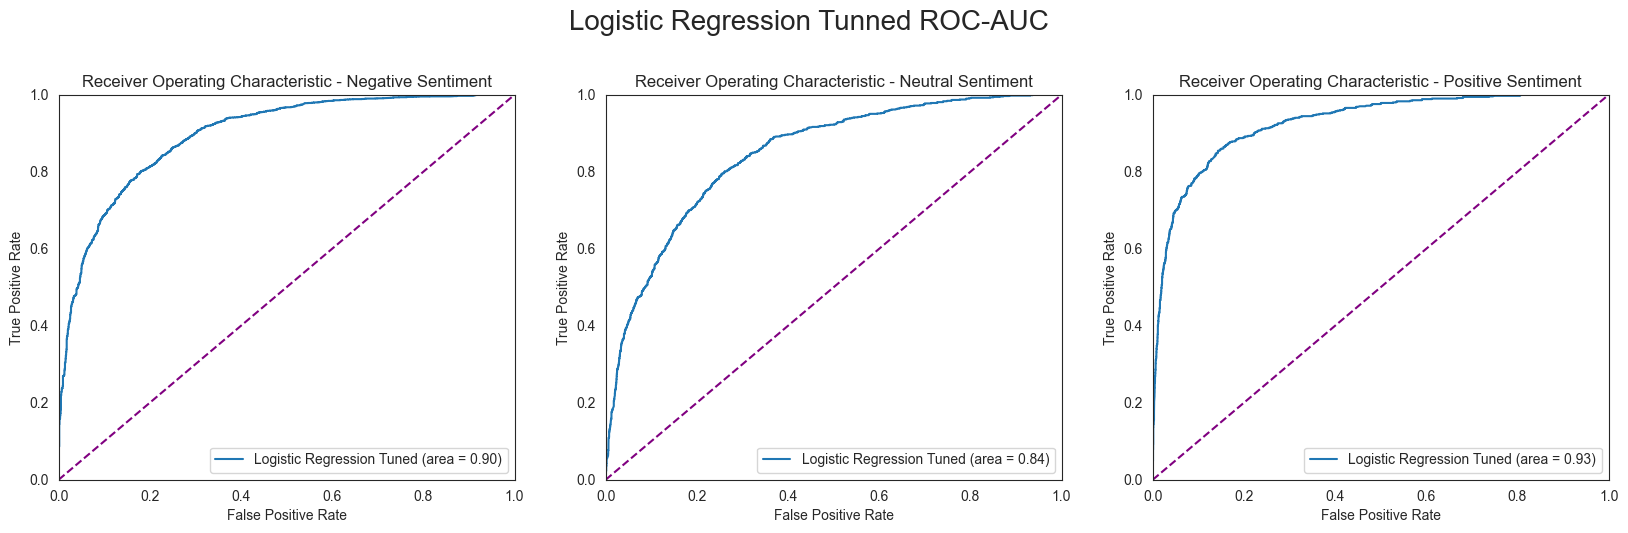

In [97]:
# Calculate AUC score for each sentiment value
lr_roc_auc_0 = roc_auc_score(y_test == 0, lr_tuned.predict_proba(X_test_vec)[:, 0])
lr_roc_auc_1 = roc_auc_score(y_test == 1, lr_tuned.predict_proba(X_test_vec)[:, 1])
lr_roc_auc_2 = roc_auc_score(y_test == 2, lr_tuned.predict_proba(X_test_vec)[:, 2])
# print("logit_roc_auc_0:", log_roc_auc_0)
# print("logit_roc_auc_1:", log_roc_auc_1)
# print("logit_roc_auc_2:", log_roc_auc_2)

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, lr_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, lr_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, lr_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Logistic Regression Tuned (area = %0.2f)' % lr_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Logistic Regression Tuned (area = %0.2f)' % lr_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Logistic Regression Tuned (area = %0.2f)' % lr_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Logistic Regression Tunned ROC-AUC", fontsize=20, y=1.05)

plt.show()

#### **SVC**

In [98]:
# initialize the LinearSVC model
clf = LinearSVC(C=1)

# use the training data to train the model
clf.fit(X_train_vec,y_train)



print("Train Performance")
clf_train = model_performance_classification_sklearn(clf, X_train_vec, y_train)
clf_train

Train Performance


Accuracy    Recall  Precision        F1
0  0.836823  0.836823   0.832305  0.832311

In [99]:
print("Test Performance")
clf_test = model_performance_classification_sklearn(clf, X_test_vec, y_test)
clf_test

Test Performance


Accuracy    Recall  Precision        F1
0  0.779325  0.779325   0.771569  0.773789

Insight:

- This model is overfitted

**Learning Curve for Linear SVC Base**

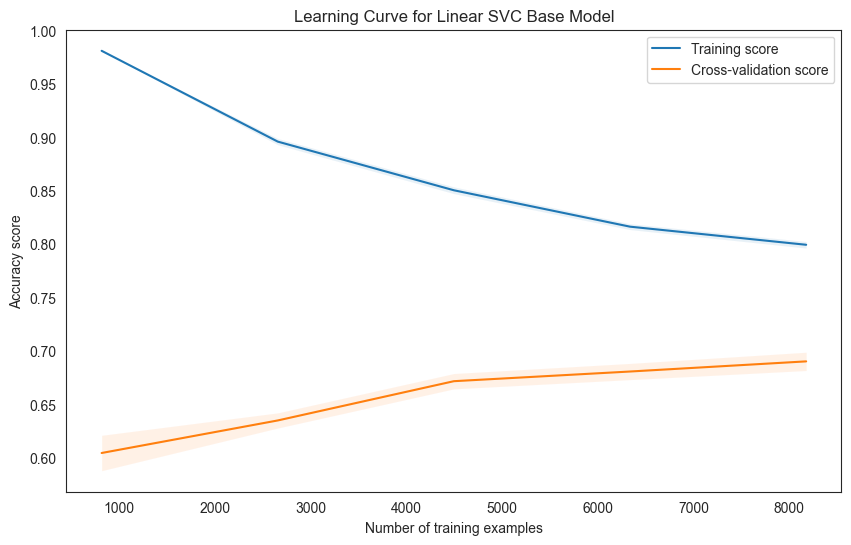

In [100]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(clf, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Linear SVC Base Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix Linear SVC Base**

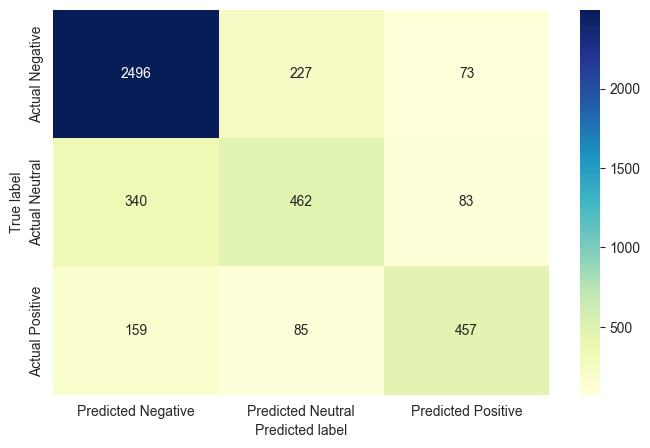

In [101]:
confusion_matrix_sentiment(clf, X_test_vec, y_test)

**Receiver Operating Characteristic(SVC)**

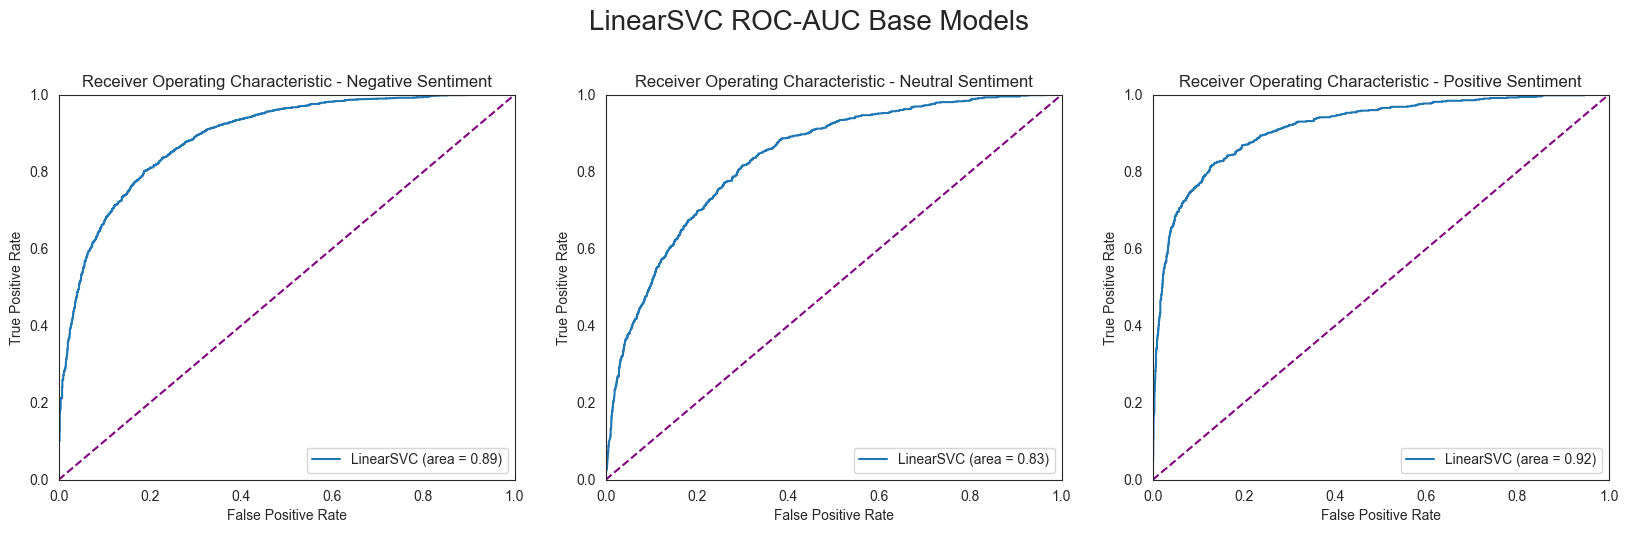

In [102]:
# Calculate AUC score for each sentiment value
clf_roc_auc_0 = roc_auc_score(y_test == 0, clf.decision_function(X_test_vec)[:, 0])
clf_roc_auc_1 = roc_auc_score(y_test == 1, clf.decision_function(X_test_vec)[:, 1])
clf_roc_auc_2 = roc_auc_score(y_test == 2, clf.decision_function(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, clf.decision_function(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, clf.decision_function(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, clf.decision_function(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='LinearSVC (area = %0.2f)' % clf_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='LinearSVC (area = %0.2f)' % clf_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='LinearSVC (area = %0.2f)' % clf_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("LinearSVC ROC-AUC Base Models", fontsize=20, y=1.05)

plt.show()

##### **Tunned Paremeter SVC**

In [103]:
%%time
## Tunning the logistic Regression model
# defining model
sl = LinearSVC(C=1)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'max_iter': [50, 100, 150, 200]
}



grid_cv = GridSearchCV(
    estimator=sl,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_vec, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 1, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 200, 'penalty': 'l1'} with CV score=0.6933605809520003:
CPU times: total: 922 ms
Wall time: 7.98 s


In [104]:
clf_tuned = LinearSVC( 
    C = 1, 
    dual = True, 
    loss = 'hinge', 
    max_iter = 100,
    penalty = 'l2')

clf_tuned.fit(X_train_vec, y_train)

LinearSVC(C=1, loss='hinge', max_iter=100)

In [105]:
## Checking model performance

# Calculating different metrics on train set
clf_tunned_train = model_performance_classification_sklearn(
    clf_tuned, X_train_vec, y_train)

print("Training performance:")
print(clf_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
clf_tunned_test = model_performance_classification_sklearn(
    clf_tuned, X_test_vec, y_test)

print("Testing performance:")
print(clf_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.823714  0.823714   0.818507  0.816093

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.782748  0.782748   0.771567  0.772356


**Learning Curve for Linear SVC Tuned**

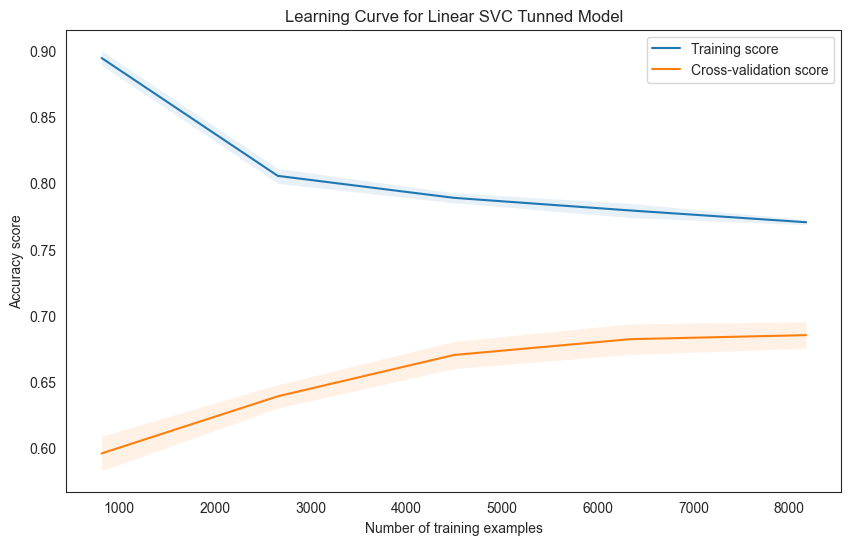

In [106]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(clf_tuned, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Linear SVC Tunned Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Linear SVC Tuned**

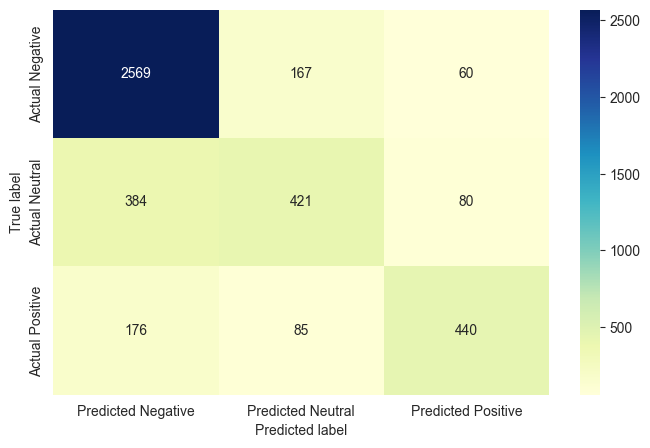

In [107]:
confusion_matrix_sentiment(clf_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for SVC Tuned**

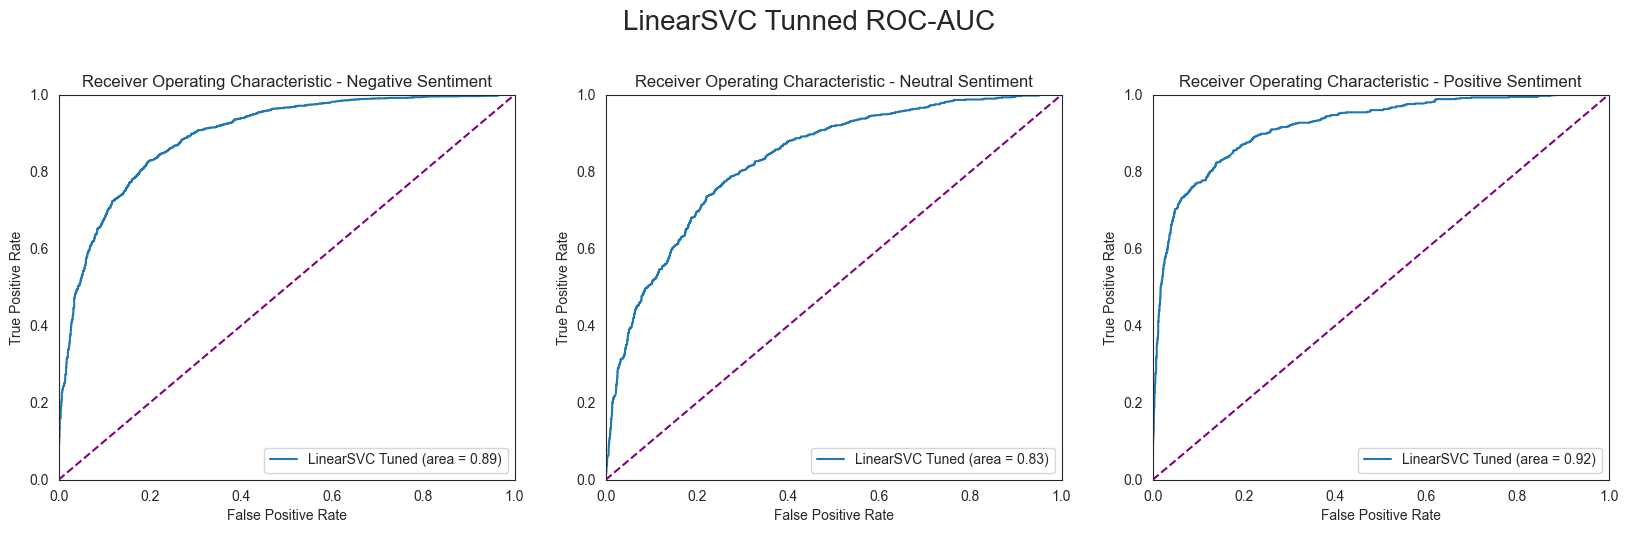

In [108]:
# Calculate AUC score for each sentiment value
clf_tuned_roc_auc_0 = roc_auc_score(y_test == 0, clf_tuned.decision_function(X_test_vec)[:, 0])
clf_tuned_roc_auc_1 = roc_auc_score(y_test == 1, clf_tuned.decision_function(X_test_vec)[:, 1])
clf_tuned_roc_auc_2 = roc_auc_score(y_test == 2, clf_tuned.decision_function(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, clf_tuned.decision_function(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, clf_tuned.decision_function(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, clf_tuned.decision_function(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='LinearSVC Tuned (area = %0.2f)' % clf_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='LinearSVC Tuned (area = %0.2f)' % clf_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='LinearSVC Tuned (area = %0.2f)' % clf_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("LinearSVC Tunned ROC-AUC", fontsize=20, y=1.05)

plt.show()

#### **Naive Bayes**

In [109]:
# initialize the MultinomialNB model
nb = MultinomialNB()

# use the training data to train the model
nb.fit(X_train_vec, y_train)

print("Train Performance")
nb_train = model_performance_classification_sklearn(nb, X_train_vec, y_train)
nb_train


Train Performance


Accuracy    Recall  Precision        F1
0  0.770593  0.770593   0.774202  0.745368

In [110]:
print("Test Performance")
nb_test = model_performance_classification_sklearn(nb, X_test_vec, y_test)
nb_test

Test Performance


Accuracy    Recall  Precision        F1
0  0.750799  0.750799   0.743117  0.717091

**Learning Curve for Naives Bayes Base**

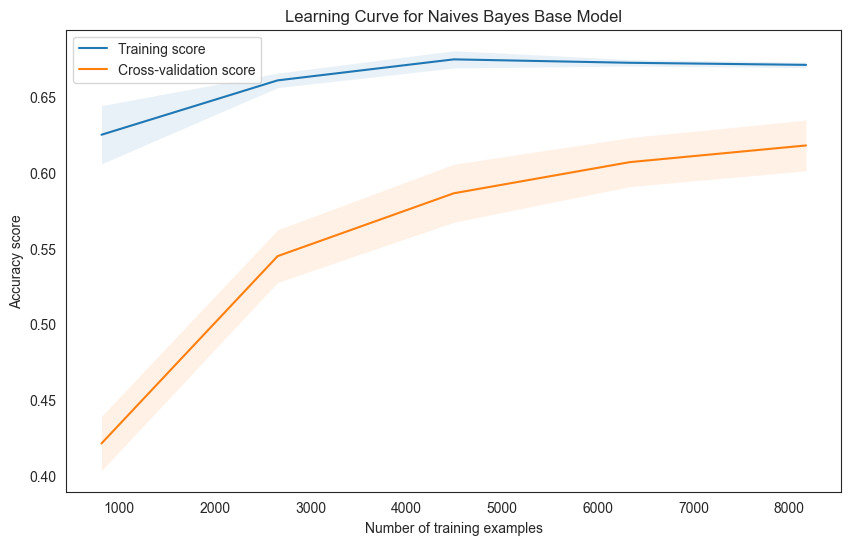

In [111]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(nb, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Naives Bayes Base Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Naives Bayes**

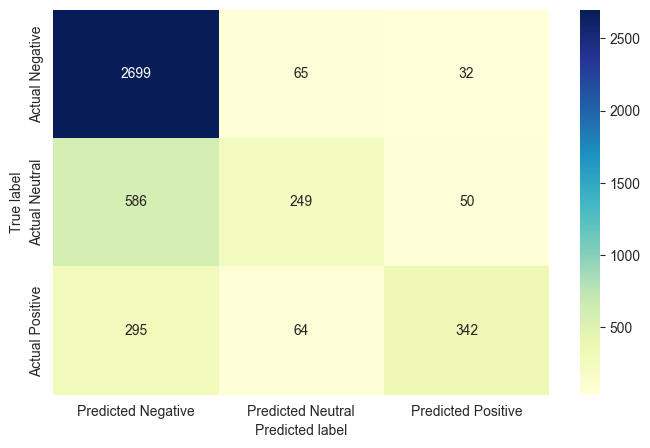

In [112]:
confusion_matrix_sentiment(nb, X_test_vec, y_test)

**Receiver Operating Characteristic(Naive Bayes)**

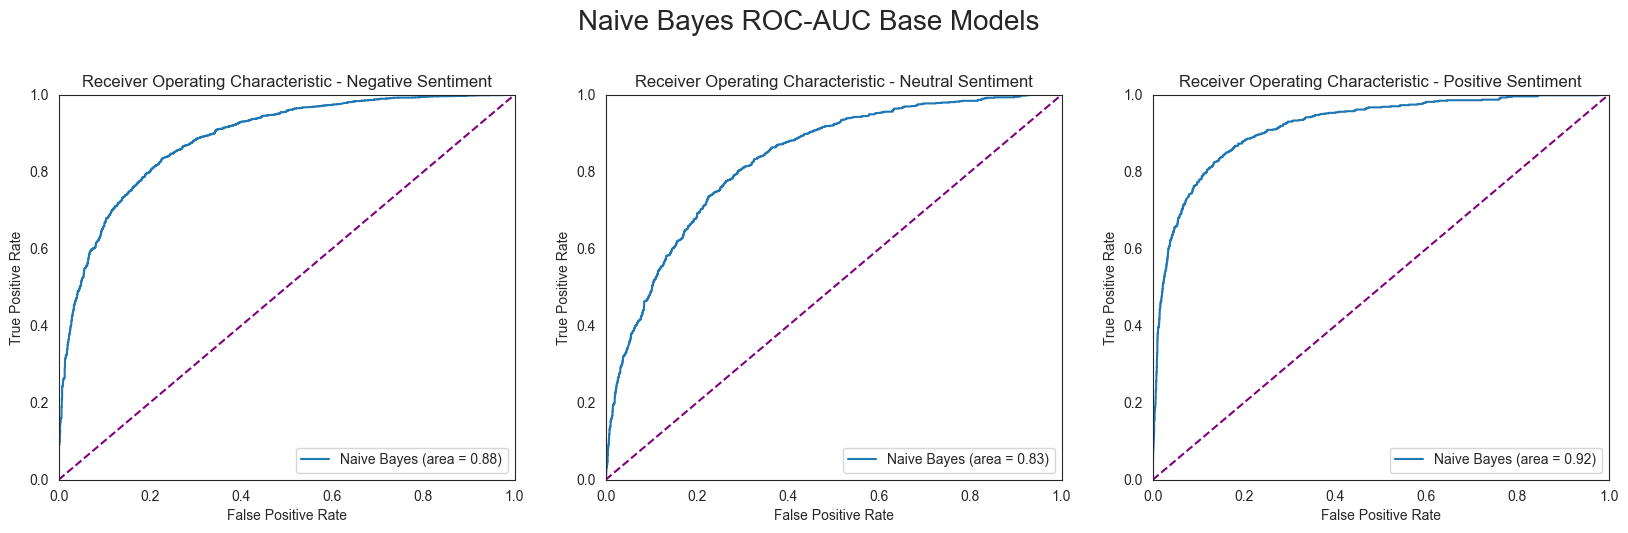

In [113]:
# Calculate AUC score for each sentiment value
nb_roc_auc_0 = roc_auc_score(y_test == 0, nb.predict_proba(X_test_vec)[:, 0])
nb_roc_auc_1 = roc_auc_score(y_test == 1, nb.predict_proba(X_test_vec)[:, 1])
nb_roc_auc_2 = roc_auc_score(y_test == 2, nb.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, nb.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, nb.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, nb.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Naive Bayes (area = %0.2f)' % nb_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Naive Bayes (area = %0.2f)' % nb_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Naive Bayes (area = %0.2f)' % nb_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Naive Bayes ROC-AUC Base Models", fontsize=20, y=1.05)

plt.show()

##### **Tunned Paremeter Naive Bayes**

In [114]:
%%time
## Tunning the logistic Regression model
# defining model
nb1 = MultinomialNB()

# Parameter grid to pass in GridSearchCV

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}



grid_cv = GridSearchCV(
    estimator=nb1,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_vec, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'alpha': 0.1, 'fit_prior': False} with CV score=0.6705230978412422:
CPU times: total: 172 ms
Wall time: 185 ms


In [115]:
nb_tuned = MultinomialNB( 
    alpha = 0.1, 
    fit_prior = True)

nb_tuned.fit(X_train_vec, y_train)

MultinomialNB(alpha=0.1)

In [116]:
## Checking model performance

# Calculating different metrics on train set
nb_tunned_train = model_performance_classification_sklearn(
    nb_tuned, X_train_vec, y_train)

print("Training performance:")
print(nb_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
nb_tunned_test = model_performance_classification_sklearn(
    nb_tuned, X_test_vec, y_test)

print("Testing performance:")
print(nb_tunned_test)

Training performance:
   Accuracy    Recall  Precision       F1
0  0.783311  0.783311   0.781674  0.76416

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision       F1
0  0.757873  0.757873   0.745659  0.73055


**Learning Curve for Naives Bayes Tuned**

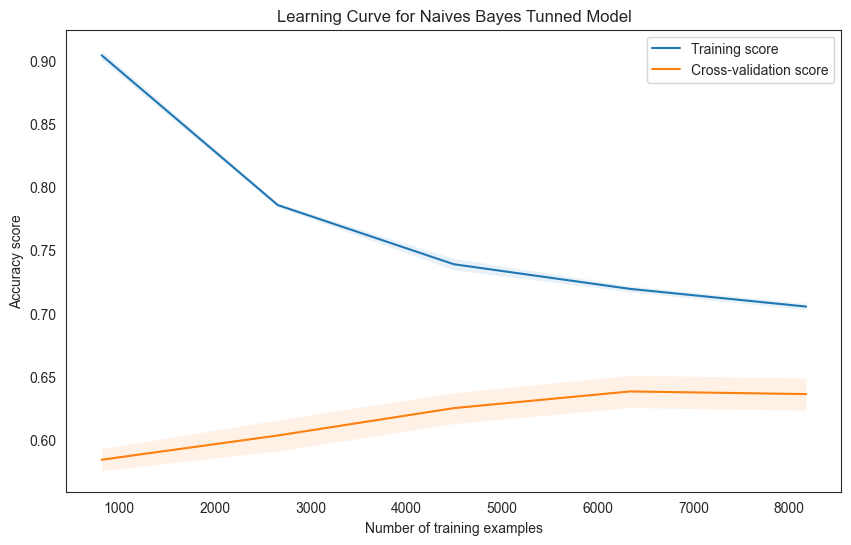

In [117]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(nb_tuned, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Naives Bayes Tunned Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Naives Bayes Tuned**

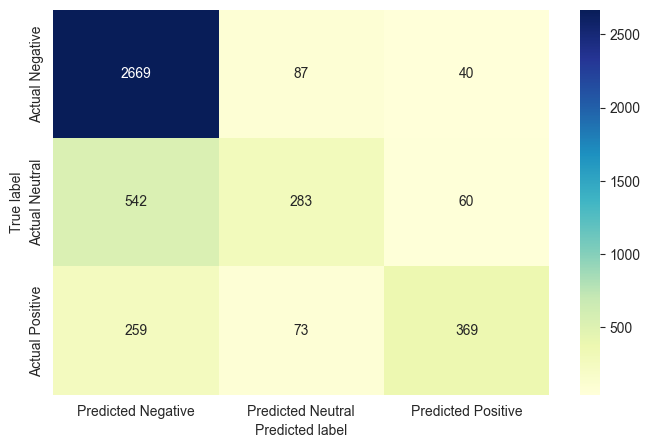

In [118]:
confusion_matrix_sentiment(nb_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Naive Bayes Tuned**

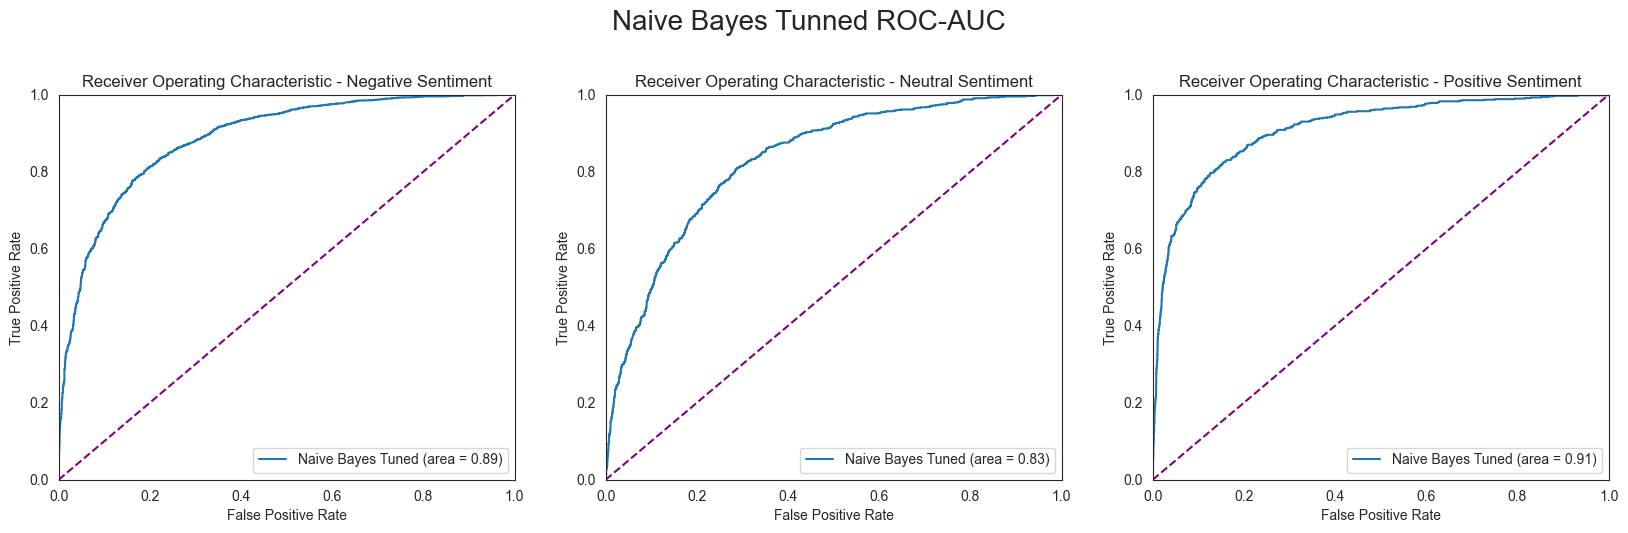

In [119]:
# Calculate AUC score for each sentiment value
nb_tuned_roc_auc_0 = roc_auc_score(y_test == 0, nb_tuned.predict_proba(X_test_vec)[:, 0])
nb_tuned_roc_auc_1 = roc_auc_score(y_test == 1, nb_tuned.predict_proba(X_test_vec)[:, 1])
nb_tuned_roc_auc_2 = roc_auc_score(y_test == 2, nb_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, nb_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, nb_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, nb_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Naive Bayes Tuned (area = %0.2f)' % nb_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Naive Bayes Tuned (area = %0.2f)' % nb_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Naive Bayes Tuned (area = %0.2f)' % nb_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Naive Bayes Tunned ROC-AUC", fontsize=20, y=1.05)

plt.show()

#### **Random Forest**

In [120]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train_vec, y_train)


print("Train Performance")
rfc_train = model_performance_classification_sklearn(rfc, X_train_vec, y_train)
rfc_train

Train Performance


Accuracy    Recall  Precision        F1
0  0.988163  0.988163   0.988234  0.988188

In [121]:
print("Test Performance")
rfc_test = model_performance_classification_sklearn(rfc, X_test_vec, y_test)
rfc_test

Test Performance


Accuracy    Recall  Precision        F1
0  0.750114  0.750114   0.734061  0.737192

Insight:
    
- This model is overfitted.

**Learning Curve for Random Forest Base Model**

CPU times: total: 38.2 s
Wall time: 2min 11s


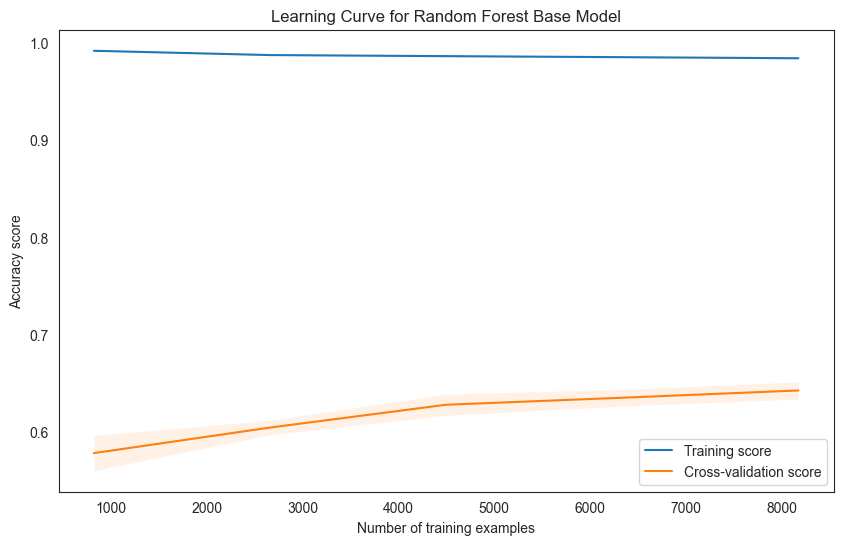

In [122]:
%%time
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Random Forest Base Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Random Forest Base**

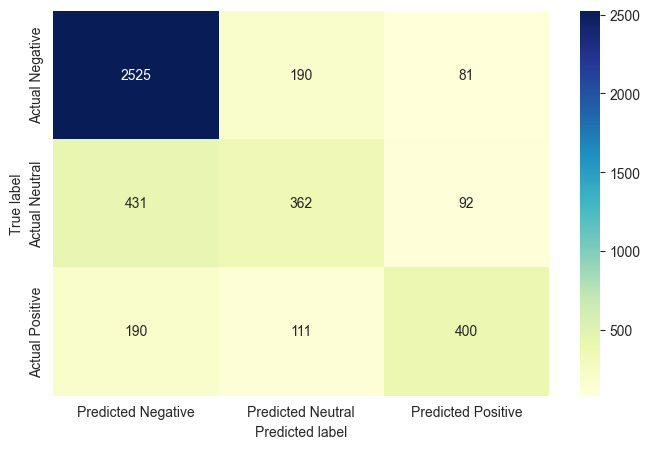

In [123]:
# creating confusion matrix
confusion_matrix_sentiment(rfc, X_test_vec, y_test)

**Receiver Operating Characteristic(Random Forest)**

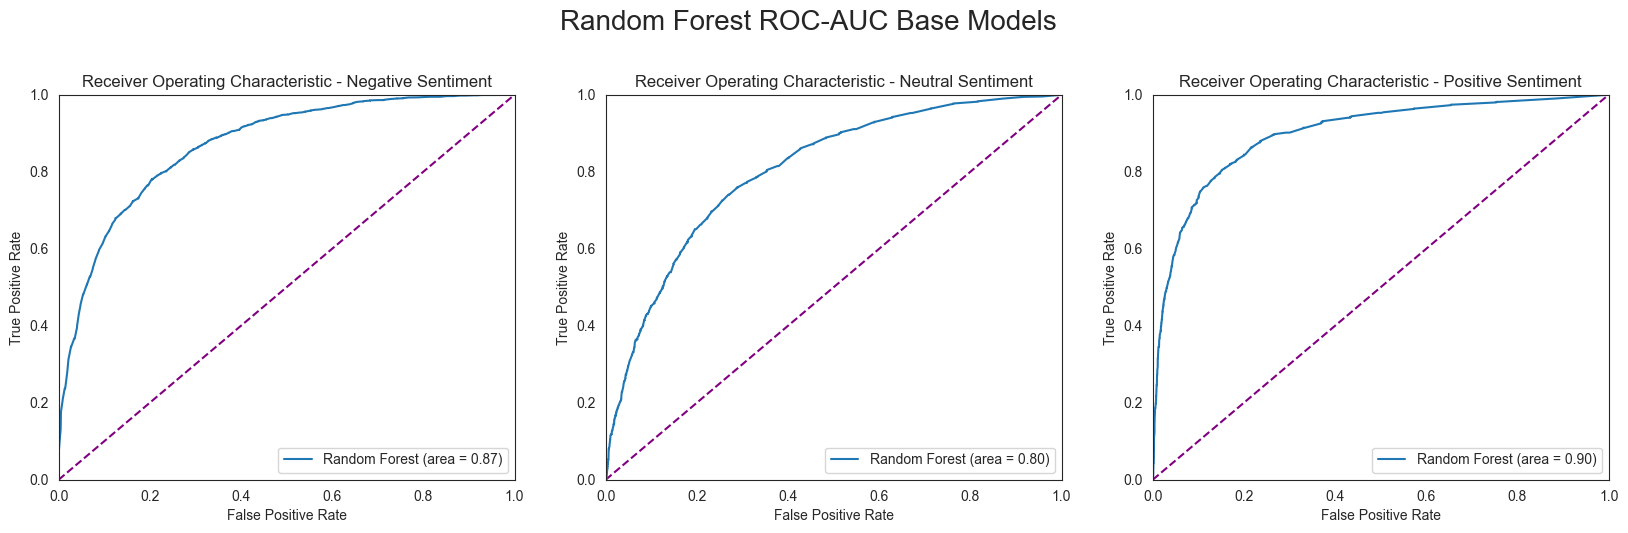

In [124]:
# Calculate AUC score for each sentiment value
rfc_roc_auc_0 = roc_auc_score(y_test == 0, rfc.predict_proba(X_test_vec)[:, 0])
rfc_roc_auc_1 = roc_auc_score(y_test == 1, rfc.predict_proba(X_test_vec)[:, 1])
rfc_roc_auc_2 = roc_auc_score(y_test == 2, rfc.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, rfc.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, rfc.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, rfc.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Random Forest (area = %0.2f)' % rfc_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Random Forest (area = %0.2f)' % rfc_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Random Forest (area = %0.2f)' % rfc_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Random Forest ROC-AUC Base Models", fontsize=20, y=1.05)

plt.show()

##### **Tunned Paremeter Random Forest**

In [125]:
%%time
## Tunning the logistic Regression model
# defining model
rf = RandomForestClassifier()

# Parameter grid to pass in GridSearchCV

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 4, 6, 8, 10, None],
    "max_features": ["sqrt", "log2"],
    "n_estimators": [20, 60, 80, 100],
    # "class_weight": ["balanced", "balanced_subsample"],
    "bootstrap": [True, False]
}



grid_cv = GridSearchCV(
    estimator=rf,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_vec, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'bootstrap': False, 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100} with CV score=0.6526974688711069:
CPU times: total: 13.7 s
Wall time: 9min 16s


In [126]:
rfc_tuned = RandomForestClassifier( 
    n_estimators = 100, 
    max_features = 'log2', 
    max_depth = None, 
    criterion = 'gini',
    # class_weight = 'balanced', 
    bootstrap = False
)

rfc_tuned.fit(X_train_vec, y_train)

RandomForestClassifier(bootstrap=False, max_features='log2')

In [127]:
## Checking model performance

# Calculating different metrics on train set
rfc_tunned_train = model_performance_classification_sklearn(
    rfc_tuned, X_train_vec, y_train)

print("Training performance:")
print(rfc_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
rfc_tunned_test = model_performance_classification_sklearn(
    rfc_tuned, X_test_vec, y_test)

print("Testing performance:")
print(rfc_tunned_test)

Training performance:
   Accuracy    Recall  Precision       F1
0  0.988163  0.988163   0.988228  0.98818

**********************************************************************

Testing performance:
   Accuracy   Recall  Precision        F1
0   0.75833  0.75833   0.743754  0.743147


Insight:

- The model is still over-fitted

**Learning Curve for Random Forest Tunned Model**

CPU times: total: 48.8 s
Wall time: 2min 36s


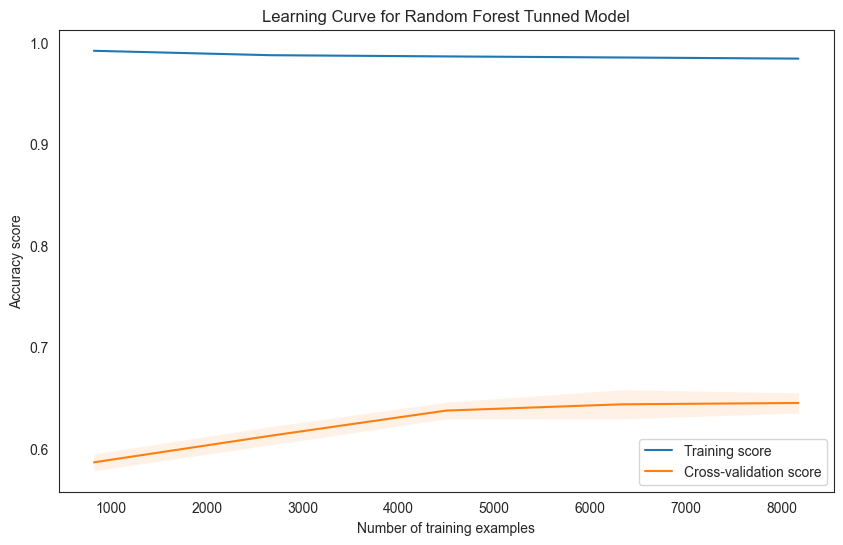

In [128]:
%%time
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc_tuned, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Random Forest Tunned Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Random Forest Tunned Model**

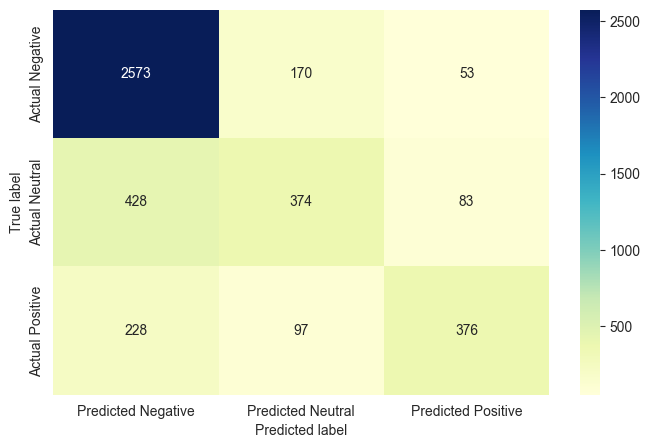

In [129]:
confusion_matrix_sentiment(rfc_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Random Forest Tuned**

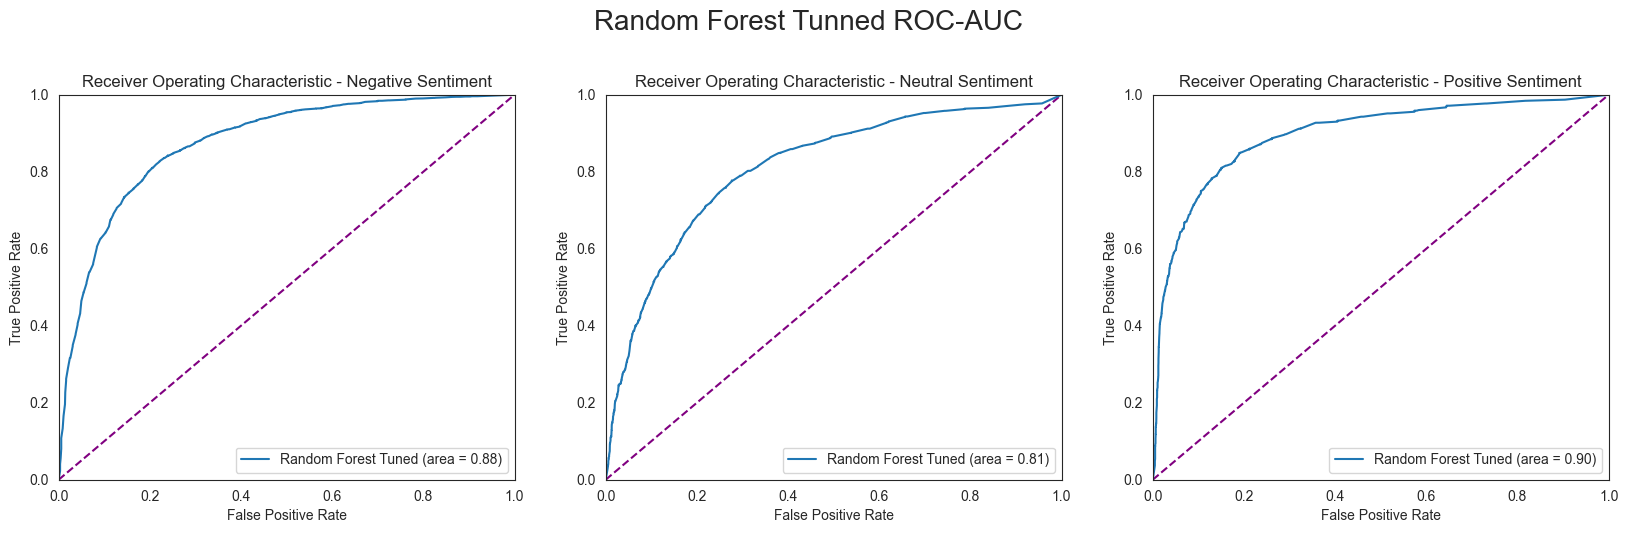

In [130]:
# Calculate AUC score for each sentiment value
rfc_tuned_roc_auc_0 = roc_auc_score(y_test == 0, rfc_tuned.predict_proba(X_test_vec)[:, 0])
rfc_tuned_roc_auc_1 = roc_auc_score(y_test == 1, rfc_tuned.predict_proba(X_test_vec)[:, 1])
rfc_tuned_roc_auc_2 = roc_auc_score(y_test == 2, rfc_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, rfc_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, rfc_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, rfc_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Random Forest Tuned (area = %0.2f)' % rfc_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Random Forest Tuned (area = %0.2f)' % rfc_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Random Forest Tuned (area = %0.2f)' % rfc_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Random Forest Tunned ROC-AUC", fontsize=20, y=1.05)

plt.show()

#### **XGBoost**

In [131]:
xgb = XGBClassifier()
xgb.fit(X_train_vec, y_train)


print("Train Performance")
xgb_train = model_performance_classification_sklearn(xgb, X_train_vec, y_train)
xgb_train

Train Performance


Accuracy   Recall  Precision       F1
0   0.85316  0.85316   0.850785  0.84782

In [132]:
print("Test Performance")
xgb_test = model_performance_classification_sklearn(xgb, X_test_vec, y_test)
xgb_test

Test Performance


Accuracy    Recall  Precision        F1
0  0.762437  0.762437   0.748306  0.749605

Insight:
    
- This model is overfitted.

**Learning Curve for XGBoost Base Model**

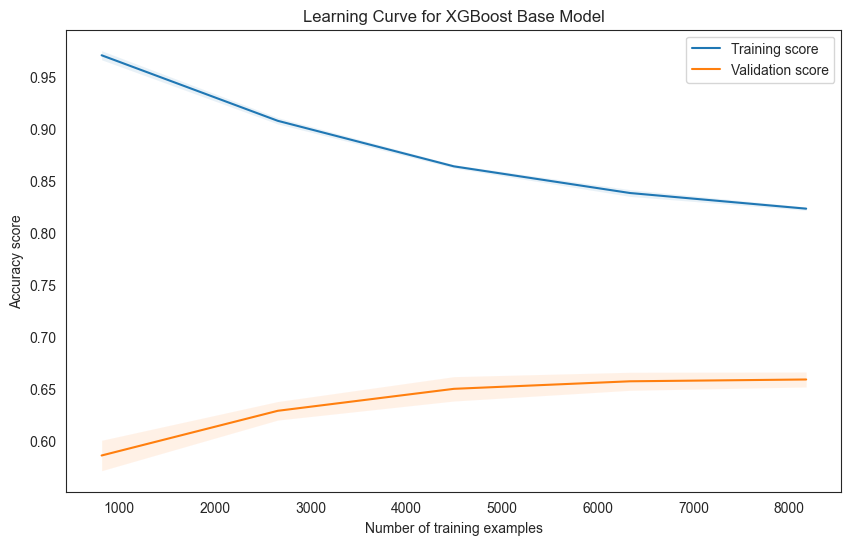

In [133]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(xgb, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for XGBoost Base Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for XGBoost Base Model**

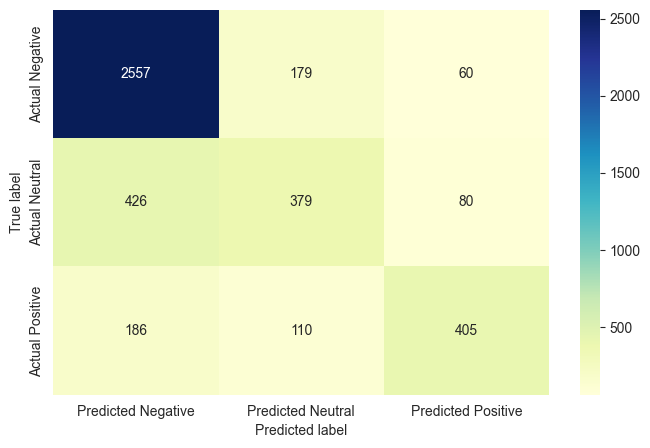

In [134]:
# creating confusion matrix
confusion_matrix_sentiment(xgb, X_test_vec, y_test)

**Receiver Operating Characteristic(XGBoost)**

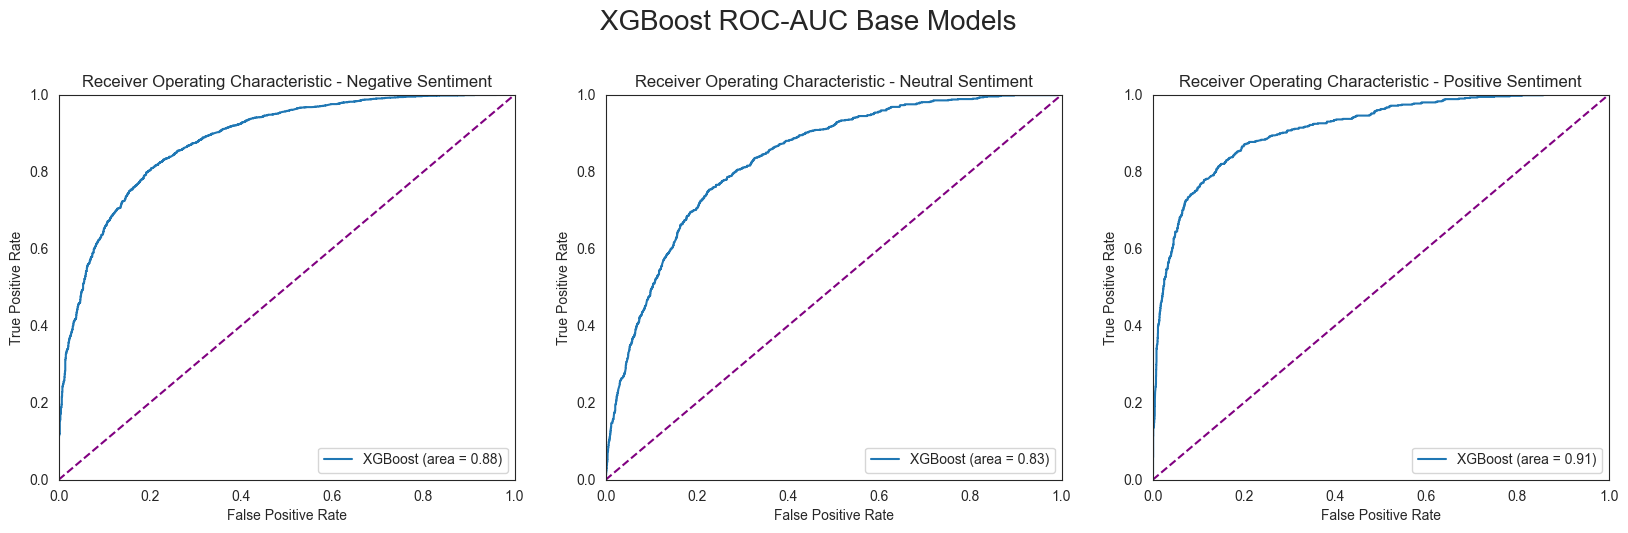

In [135]:
# Calculate AUC score for each sentiment value
xg_roc_auc_0 = roc_auc_score(y_test == 0, xgb.predict_proba(X_test_vec)[:, 0])
xg_roc_auc_1 = roc_auc_score(y_test == 1, xgb.predict_proba(X_test_vec)[:, 1])
xg_roc_auc_2 = roc_auc_score(y_test == 2, xgb.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, xgb.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, xgb.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, xgb.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='XGBoost (area = %0.2f)' % xg_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='XGBoost (area = %0.2f)' % xg_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='XGBoost (area = %0.2f)' % xg_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("XGBoost ROC-AUC Base Models", fontsize=20, y=1.05)

plt.show()

##### **Tunned Parameter XGBoost**

In [136]:
%%time
# defining model
xgb_model = XGBClassifier()


# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.5, 0.75],
    'min_child_weight': [1, 3],
}



grid_cv = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1,
)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_vec, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5} with CV score=0.6278141663618146:
CPU times: total: 13.3 s
Wall time: 6min 16s


In [137]:
# building model with best parameters
xgb_tuned =  XGBClassifier(
    colsample_bytree = 0.75,
    gamma = 0.1,
    learning_rate = 0.1,
    max_depth = 5, 
    min_child_weight = 1,
    n_estimators = 100,
    subsample = 0.5
)

# Fit the model on training data
xgb_tuned.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [138]:
## Checking model performance

# Calculating different metrics on train set
xgb_tunned_train = model_performance_classification_sklearn(
    xgb_tuned, X_train_vec, y_train
)
print("Training performance:")
print(xgb_tunned_train)

print()
print("*************************************")
print()

# Calculating different metrics on test set
xgb_tunned_test = model_performance_classification_sklearn(
    xgb_tuned, X_test_vec, y_test
)
print("Testing performance:")
print(xgb_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.769517  0.769517   0.760324  0.751533

*************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.749201  0.749201   0.730544  0.729005


**Learning Curve for XGBoost Tunned Model**

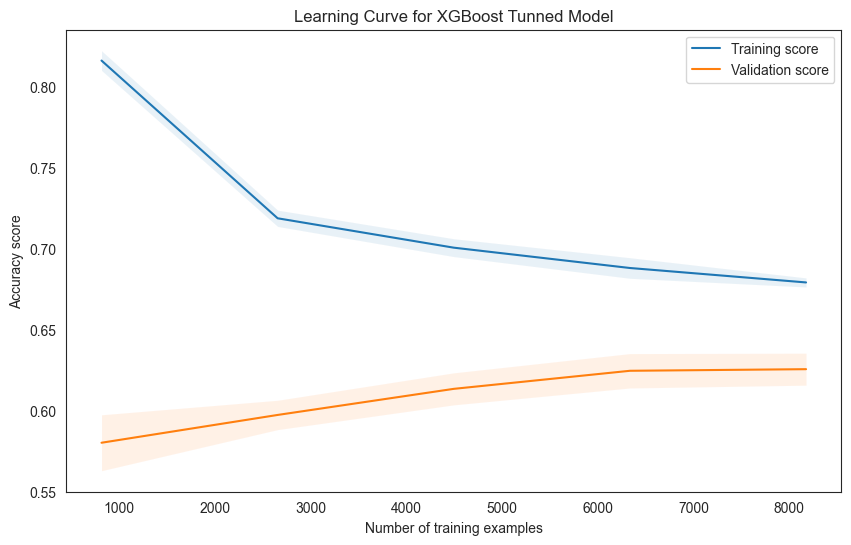

In [139]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(xgb_tuned, X_train_vec, y_train, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for XGBoost Tunned Model")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for XGBoost Tunned Model**

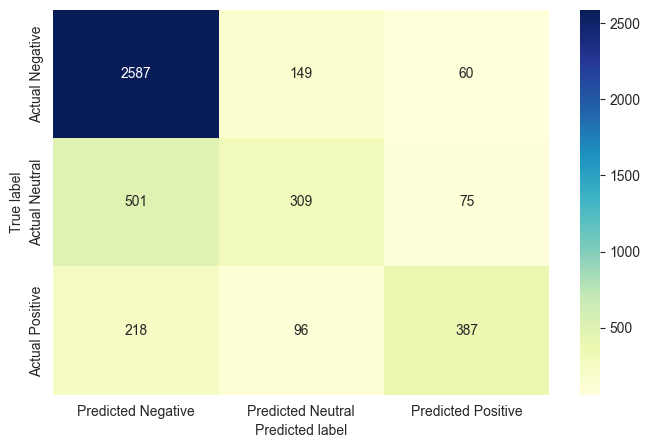

In [140]:
# creating confusion matrix
confusion_matrix_sentiment(xgb_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for XGBoost Tuned**

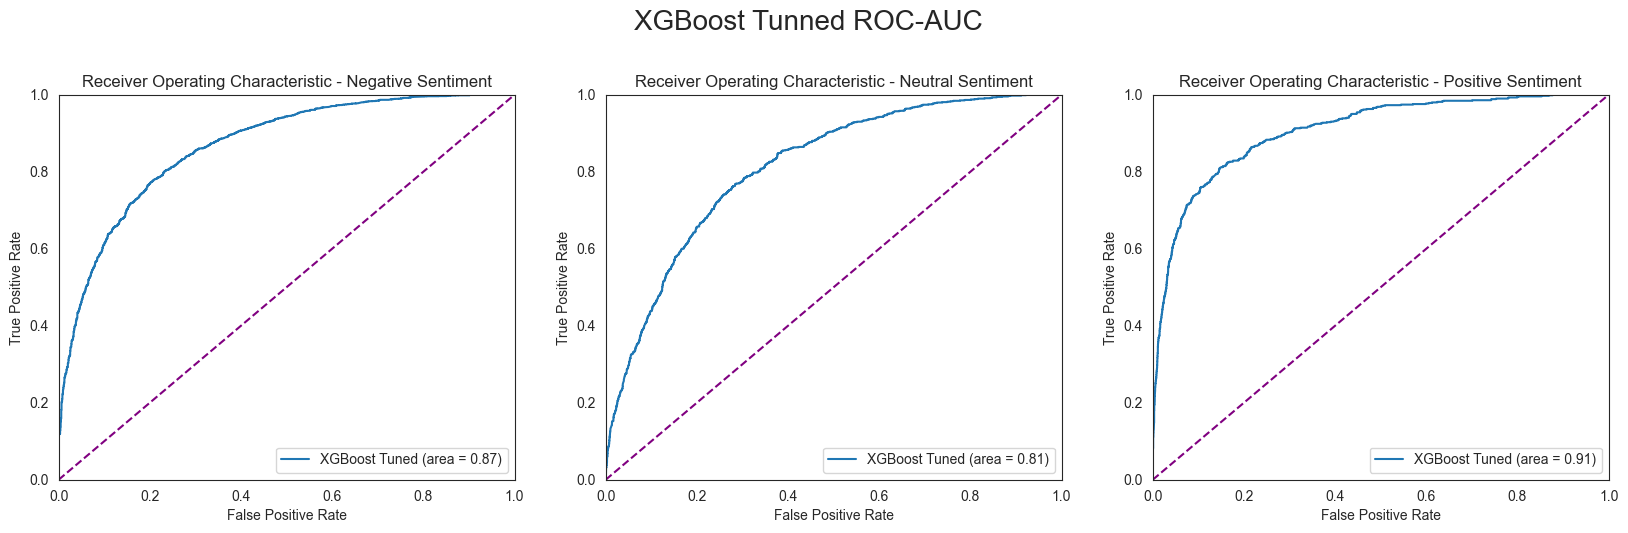

In [141]:
# Calculate AUC score for each sentiment value
xgb_tuned_roc_auc_0 = roc_auc_score(y_test == 0, xgb_tuned.predict_proba(X_test_vec)[:, 0])
xgb_tuned_roc_auc_1 = roc_auc_score(y_test == 1, xgb_tuned.predict_proba(X_test_vec)[:, 1])
xgb_tuned_roc_auc_2 = roc_auc_score(y_test == 2, xgb_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, xgb_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, xgb_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, xgb_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='XGBoost Tuned (area = %0.2f)' % xgb_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='XGBoost Tuned (area = %0.2f)' % xgb_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='XGBoost Tuned (area = %0.2f)' % xgb_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("XGBoost Tunned ROC-AUC", fontsize=20, y=1.05)

plt.show()

#### **Comparing all models**

##### **Base models**

**Training Performance**

In [142]:
# training performance comparison

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

Base_models_train_comp = pd.concat(
    [
        lr_train.T,
        clf_train.T,
        nb_train.T,
        rfc_train.T,
        xgb_train.T
    ],
    axis=1,
)
Base_models_train_comp.columns = [
    "Logistic Regression Base",
    "Linear SVC Base",
    "Naive Bayes Base",
    "Random Forest Base",
    "XGBoost Base"
]
print_formatted("Training performance comparison for Best Paremeter with imbalanced data:")
Base_models_train_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Training performance comparison for Best Paremeter with imbalanced data:</p>

Logistic Regression Base  Linear SVC Base  Naive Bayes Base  \
Accuracy                   0.818724         0.836823          0.770593   
Recall                     0.818724         0.836823          0.770593   
Precision                  0.814110         0.832305          0.774202   
F1                         0.810464         0.832311          0.745368   

           Random Forest Base  XGBoost Base  
Accuracy             0.988163      0.853160  
Recall               0.988163      0.853160  
Precision            0.988234      0.850785  
F1                   0.988188      0.847820

**Testing Performance**

In [143]:
# testing performance comparison

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

Base_models_test_comp = pd.concat(
    [
        lr_test.T,
        clf_test.T,
        nb_test.T,
        rfc_test.T,
        xgb_test.T
    ],
    axis=1,
)
Base_models_test_comp.columns = [
    "Logistic Regression Base",
    "Linear SVC Base",
    "Naive Bayes Base",
    "Random Forest Base",
    "XGBoost Base"
]
print_formatted("Testing performance comparison for Base Paremeter with imbalanced data:")
Base_models_test_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Testing performance comparison for Base Paremeter with imbalanced data:</p>

Logistic Regression Base  Linear SVC Base  Naive Bayes Base  \
Accuracy                   0.785714         0.779325          0.750799   
Recall                     0.785714         0.779325          0.750799   
Precision                  0.775618         0.771569          0.743117   
F1                         0.775532         0.773789          0.717091   

           Random Forest Base  XGBoost Base  
Accuracy             0.750114      0.762437  
Recall               0.750114      0.762437  
Precision            0.734061      0.748306  
F1                   0.737192      0.749605

Insight:

- All models are overfitted aside for the Logistic Regression.

##### **Hyper Paremeter Tunning models**

**Training Tunned Performance**

In [144]:
# training performance comparison

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

tunned_models_train_comp = pd.concat(
    [
        
        lr_tunned_train.T,
        clf_tunned_train.T,
        nb_tunned_train.T,
        rfc_tunned_train.T,
        xgb_tunned_train.T
    ],
    axis=1,
)
tunned_models_train_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV",
    "Linear SVC Tuned with Grid SearchCV",
    "Naives Bayes Tuned with Grid SearchCV",
    "Random Forest Tuned with Grid SearchCV",
    "XGBoost Tuned with Grid SearchCV"
]
print_formatted("Training performance comparison for Tuned with Grid Search with imbalanced data:")
tunned_models_train_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Training performance comparison for Tuned with Grid Search with imbalanced data:</p>

Logistic Regression Tuned with Grid SearchCV  \
Accuracy                                       0.817844   
Recall                                         0.817844   
Precision                                      0.813143   
F1                                             0.809546   

           Linear SVC Tuned with Grid SearchCV  \
Accuracy                              0.823714   
Recall                                0.823714   
Precision                             0.818507   
F1                                    0.816093   

           Naives Bayes Tuned with Grid SearchCV  \
Accuracy                                0.783311   
Recall                                  0.783311   
Precision                               0.781674   
F1                                      0.764160   

           Random Forest Tuned with Grid SearchCV  \
Accuracy                                 0.988163   
Recall                                   0.988163   
Precision                                0.988228   
F1                                       0.988180   

           XGBoost Tuned with Grid SearchCV  
Accuracy                           0.769517  
Recall                             0.769517  
Precision                          0.760324  
F1                                 0.751533

**Testing Tunned Performance**

In [145]:
# training performance comparison

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

tunned_models_test_comp = pd.concat(
    [
        
        lr_tunned_test.T,
        clf_tunned_test.T,
        nb_tunned_test.T,
        rfc_tunned_test.T,
        xgb_tunned_test.T
    ],
    axis=1,
)
tunned_models_test_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV",
    "Linear SVC Tuned with Grid SearchCV",
    "Naives Bayes Tuned with Grid SearchCV",
    "Random Forest Tuned with Grid SearchCV",
    "XGBoost Tuned with Grid SearchCV"
]
print_formatted("Testing performance comparison for Tuned with Grid Search with imbalanced data:")
tunned_models_test_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Testing performance comparison for Tuned with Grid Search with imbalanced data:</p>

Logistic Regression Tuned with Grid SearchCV  \
Accuracy                                       0.786171   
Recall                                         0.786171   
Precision                                      0.775992   
F1                                             0.775855   

           Linear SVC Tuned with Grid SearchCV  \
Accuracy                              0.782748   
Recall                                0.782748   
Precision                             0.771567   
F1                                    0.772356   

           Naives Bayes Tuned with Grid SearchCV  \
Accuracy                                0.757873   
Recall                                  0.757873   
Precision                               0.745659   
F1                                      0.730550   

           Random Forest Tuned with Grid SearchCV  \
Accuracy                                 0.758330   
Recall                                   0.758330   
Precision                                0.743754   
F1                                       0.743147   

           XGBoost Tuned with Grid SearchCV  
Accuracy                           0.749201  
Recall                             0.749201  
Precision                          0.730544  
F1                                 0.729005

Insight:

The metric is Accuracy.

- All training score are in the 80's score aside from Random Forest which was in the 90's. 
- All testing score are in the 70's score.
- Random forest in overfitted. It is worst model.
- Followed by XGBoost. There are 6% different from the training to the testing score.



    print('\033[1m' + '\033[32m' + "Reject null hypothesis, there is a significant difference in the mean transaction amount for male and female customers." + '\033[0m')


#### **Comparing all AUC-ROC for Imbalanced Target**

**Base Model**

In [146]:
# AUC-ROC performance comparison


# Create pandas Series for each model
log_serie = pd.Series([log_roc_auc_0, log_roc_auc_1, log_roc_auc_2], name='Logistic Regression AUC-ROC')
svc_serie = pd.Series([clf_roc_auc_0, clf_roc_auc_1, clf_roc_auc_2], name='Linear SVC AUC-ROC')
nb_serie = pd.Series([nb_roc_auc_0, nb_roc_auc_1, nb_roc_auc_2], name='Naive Bayes AUC-ROC')
rfc_serie = pd.Series([rfc_roc_auc_0, rfc_roc_auc_1, rfc_roc_auc_2], name='Random Forest AUC-ROC')
xg_serie = pd.Series([xg_roc_auc_0, xg_roc_auc_1, xg_roc_auc_2], name='XGBoost AUC-ROC')



roc_comp = pd.concat(
    [
        log_serie.T,
        svc_serie.T,
        nb_serie.T,
        rfc_serie.T,
        xg_serie.T
    ],
    axis=1,
)


# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

print_formatted("AUC-ROC Performance Comparison from Base Model with Imbalanced Data:")

roc_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>AUC-ROC Performance Comparison from Base Model with Imbalanced Data:</p>

Logistic Regression AUC-ROC  Linear SVC AUC-ROC  Naive Bayes AUC-ROC  \
0                     0.896076            0.890331             0.884897   
1                     0.845380            0.833964             0.830351   
2                     0.927492            0.916427             0.918331   

   Random Forest AUC-ROC  XGBoost AUC-ROC  
0               0.869294         0.882802  
1               0.803098         0.832949  
2               0.898583         0.911073

**Tunned Model**

In [147]:
# AUC-ROC performance comparison


# Create pandas Series for each model
log_series = pd.Series([lr_roc_auc_0, lr_roc_auc_1, lr_roc_auc_2], name='Logistic Regression AUC-ROC Tuned')
svc_series = pd.Series([clf_tuned_roc_auc_0, clf_tuned_roc_auc_1, clf_tuned_roc_auc_2], name='Linear SVC AUC-ROC Tuned')
nb_series = pd.Series([nb_tuned_roc_auc_0, nb_tuned_roc_auc_1, nb_tuned_roc_auc_2], name='Naive Bayes AUC-ROC Tuned')
rfc_series = pd.Series([rfc_tuned_roc_auc_0, rfc_tuned_roc_auc_1, rfc_tuned_roc_auc_2], name='Random Forest AUC-ROC Tuned')
xgb_series = pd.Series([xgb_tuned_roc_auc_0, xgb_tuned_roc_auc_1, xgb_tuned_roc_auc_2], name='XGBoost AUC-ROC Tuned')



tunned_roc_comp = pd.concat(
    [
        log_series.T,
        svc_series.T,
        nb_series.T,
        rfc_series.T,
        xgb_series.T
    ],
    axis=1,
)



# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

print_formatted("AUC-ROC Performance Comparison for Tuned with Grid Search with Imbalanced Data:")

tunned_roc_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>AUC-ROC Performance Comparison for Tuned with Grid Search with Imbalanced Data:</p>

Logistic Regression AUC-ROC Tuned  Linear SVC AUC-ROC Tuned  \
0                           0.895726                  0.893169   
1                           0.844656                  0.830146   
2                           0.927575                  0.918435   

   Naive Bayes AUC-ROC Tuned  Random Forest AUC-ROC Tuned  \
0                   0.886924                     0.875404   
1                   0.830504                     0.809891   
2                   0.910910                     0.896440   

   XGBoost AUC-ROC Tuned  
0               0.866973  
1               0.811354  
2               0.906578

### **Resampling**

#### **Modeling with Over-Sampling Balanced Target Variable**

In [148]:
df_clean.sentiment.value_counts(normalize=True).mul(100)

negative    62.715694
neutral     21.165434
positive    16.118872
Name: sentiment, dtype: float64

In [149]:
#Over-sampling with SMOTE
sm = SMOTE(sampling_strategy="all")
X_train_sm, y_train_sm = sm.fit_resample(X_train_vec, y_train)
# X_test_sm, y_test_sm = sm.fit_resample(X_test_vec, y_test)
y_train_sm.value_counts(normalize=True)

2    0.333333
0    0.333333
1    0.333333
Name: sentiment, dtype: float64

##### **Cross Validation Performance for Over-Sampling**

In [150]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("LogisticRegression", LogisticRegression(random_state=42)))

models.append(("SVC", LinearSVC(C=1)))

models.append(("Naive Bayes", MultinomialNB()))

models.append(("RandomForest", RandomForestClassifier(n_estimators = 100)))

models.append(("XGBoost", XGBClassifier()))


results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")



for name, model in models:
    scoring = "f1_macro"  # set the scoring metric to F1 score with macro averaging
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=42
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_sm, y=y_train_sm, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train_sm, y_train_sm)
    scores = f1_score(y_train_sm, model.predict(X_train_sm), average="macro") * 100
    print("{}: {}".format(name, scores))

print("\n" "Testing Performance:" "\n")

for name, model in models:
    model.fit(X_train_sm, y_train_sm)
    scores = f1_score(y_test, model.predict(X_test_vec), average="macro") * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

LogisticRegression: 81.74666075690618
SVC: 82.15102331230719
Naive Bayes: 78.3843380244472
RandomForest: 86.29624494206963
XGBoost: 82.88096126555999

Training Performance:

LogisticRegression: 85.0298502664003
SVC: 86.27168309692222
Naive Bayes: 80.61627707682474
RandomForest: 98.94804662775755
XGBoost: 88.78669356255631

Testing Performance:

LogisticRegression: 69.7295828330899
SVC: 69.0505996537191
Naive Bayes: 68.191791479408
RandomForest: 65.94109070012787
XGBoost: 68.87528312081382


Insight:

- Every single model is overfitted.

##### **Logistic Regression Model Tunning for Over-Sampling**

In [151]:
%%time
## Tunning the logistic Regression model
# defining model
lr2 = LogisticRegression(random_state=42)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter' : [50, 100, 150, 200]
}




grid_cv = GridSearchCV(
    estimator=lr2,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_sm, y_train_sm)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 10, 'max_iter': 50, 'penalty': 'l1', 'solver': 'saga'} with CV score=0.8301200385848565:
CPU times: total: 5.27 s
Wall time: 1min 59s


In [152]:
lr_tuned_sm = LogisticRegression( 
    C = 10, 
    max_iter = 50, 
    penalty = 'l1', 
    solver = 'saga')

lr_tuned_sm.fit(X_train_sm, y_train_sm)

LogisticRegression(C=10, max_iter=50, penalty='l1', solver='saga')

In [153]:
## Checking model performance

# Calculating different metrics on train set
lr_tunned_sm_train = model_performance_classification_sklearn(
    lr_tuned_sm, X_train_sm, y_train_sm)

print("Training performance:")
print(lr_tunned_sm_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
lr_tunned_sm_test = model_performance_classification_sklearn(
    lr_tuned_sm, X_test_vec, y_test)

print("Testing performance:")
print(lr_tunned_sm_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.877573  0.877573   0.878915  0.877773

**********************************************************************

Testing performance:
   Accuracy   Recall  Precision        F1
0   0.73277  0.73277   0.756209  0.741271


Insight:

- The model is overfitted

**Learning curve for Logistic Regression Tuned for Over-Sampling**

CPU times: total: 21.7 s
Wall time: 1min 8s


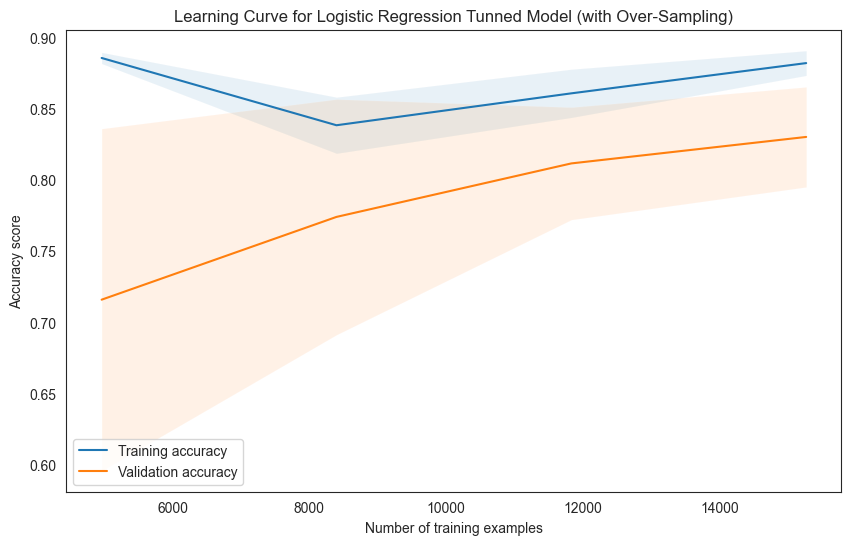

In [154]:
%%time


# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(lr_tuned_sm, X_train_sm, y_train_sm, cv=5, scoring = "f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Logistic Regression Tunned Model (with Over-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Logistic Regression Tuned for Over-Sampling**

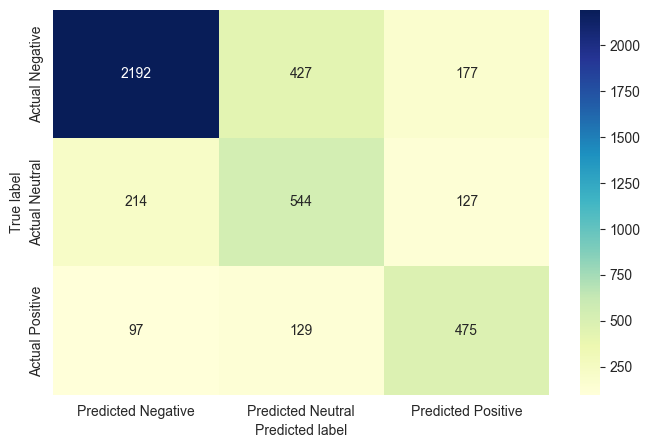

In [155]:
confusion_matrix_sentiment(lr_tuned_sm, X_test_vec, y_test)

**Receiver Operating Characteristic for lr Tuned for Over-Sampling**

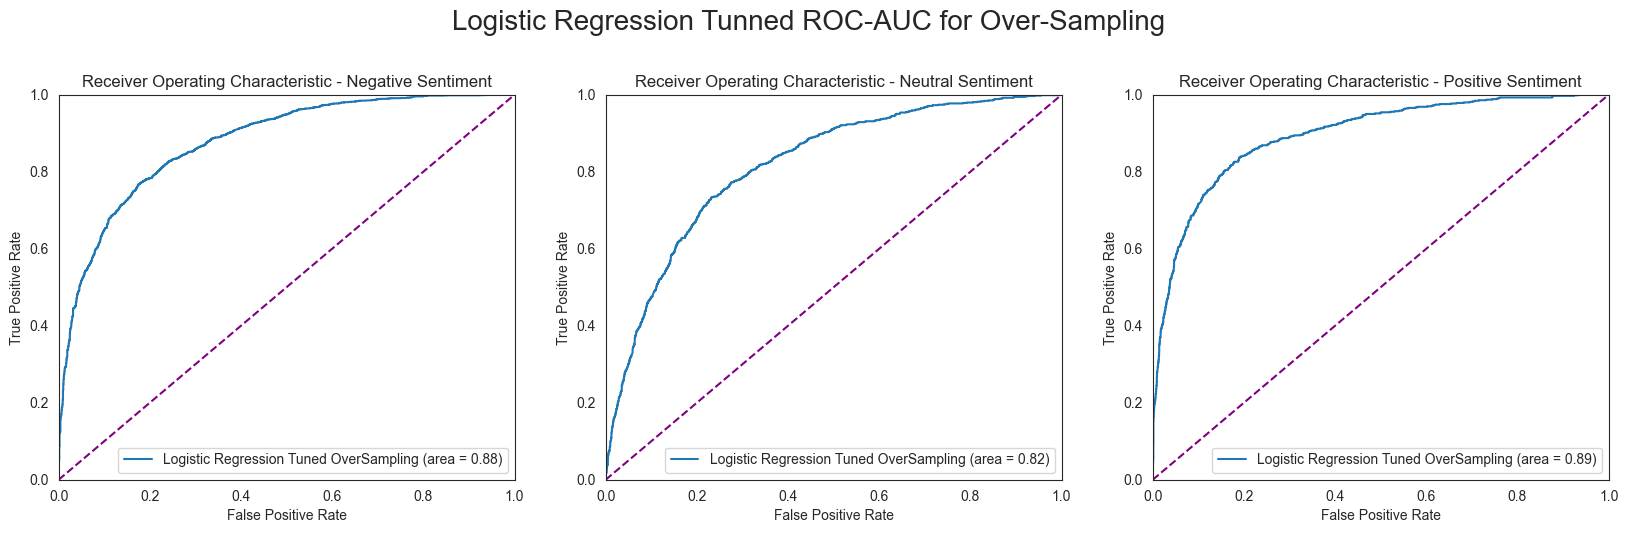

In [156]:
# Calculate AUC score for each sentiment value
lr_sm_roc_auc_0 = roc_auc_score(y_test == 0, lr_tuned_sm.predict_proba(X_test_vec)[:, 0])
lr_sm_roc_auc_1 = roc_auc_score(y_test == 1, lr_tuned_sm.predict_proba(X_test_vec)[:, 1])
lr_sm_roc_auc_2 = roc_auc_score(y_test == 2, lr_tuned_sm.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, lr_tuned_sm.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, lr_tuned_sm.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, lr_tuned_sm.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Logistic Regression Tuned OverSampling (area = %0.2f)' % lr_sm_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Logistic Regression Tuned OverSampling (area = %0.2f)' % lr_sm_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Logistic Regression Tuned OverSampling (area = %0.2f)' % lr_sm_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
    
plt.suptitle("Logistic Regression Tunned ROC-AUC for Over-Sampling", fontsize=20, y=1.05)


plt.show()

##### **SVC Model Tunning for Over-Sampling**

In [157]:
%%time
## Tunning the logistic Regression model
# defining model
sl1 = LinearSVC(C=1)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'max_iter': [50, 100, 150, 200]
}



grid_cv = GridSearchCV(
    estimator=sl1,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_sm, y_train_sm)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 10, 'dual': True, 'loss': 'hinge', 'max_iter': 150, 'penalty': 'l2'} with CV score=0.8275881093908628:
CPU times: total: 1.83 s
Wall time: 17.5 s


In [158]:
clf_sm_tuned = LinearSVC( 
    C = 10, 
    dual = True, 
    loss = 'hinge', 
    max_iter = 200,
    penalty = 'l2')

clf_sm_tuned.fit(X_train_sm, y_train_sm)

LinearSVC(C=10, loss='hinge', max_iter=200)

In [159]:
## Checking model performance

# Calculating different metrics on train set
clf_sm_tunned_train = model_performance_classification_sklearn(
    clf_sm_tuned, X_train_sm, y_train_sm)

print("Training performance:")
print(clf_sm_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
clf_sm_tunned_test = model_performance_classification_sklearn(
    clf_sm_tuned, X_test_vec, y_test)

print("Testing performance:")
print(clf_sm_tunned_test)

Training performance:
   Accuracy   Recall  Precision        F1
0   0.87113  0.87113   0.872877  0.871354

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.728206  0.728206   0.752873  0.736772


Insight:

- The model is overfitted.

**Learning Curve for Linear SVC Tuned for Over-Sampling**

CPU times: total: 547 ms
Wall time: 2.08 s


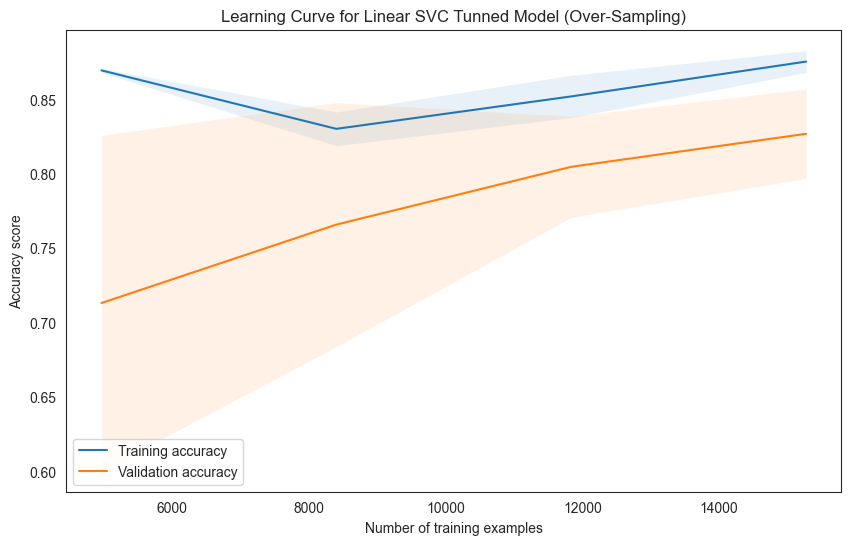

In [160]:
%%time


# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(clf_sm_tuned, X_train_sm, y_train_sm, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Linear SVC Tunned Model (Over-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Linear SVC Tuned for Over-Sampling**

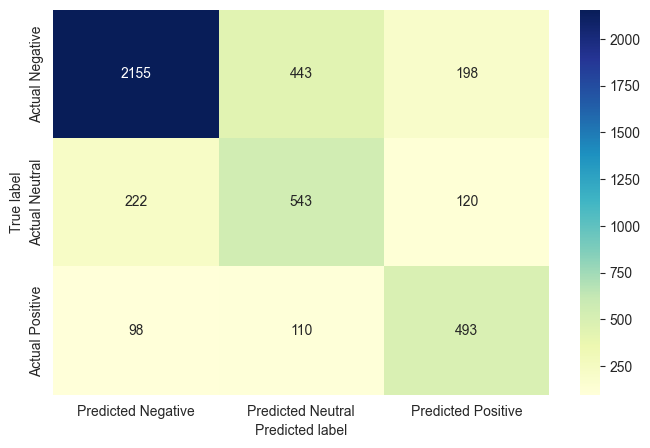

In [161]:
confusion_matrix_sentiment(clf_sm_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for SVC Tuned for Over-Sampling**

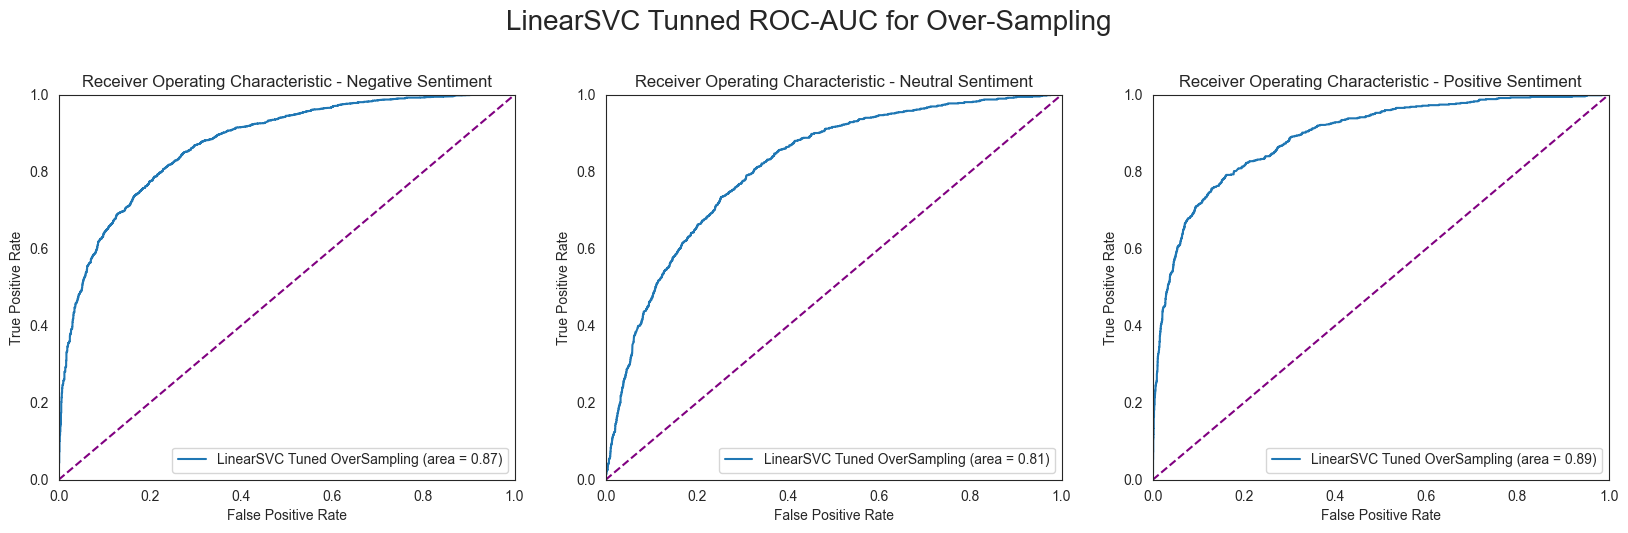

In [162]:
# Calculate AUC score for each sentiment value
clf_sm_tuned_roc_auc_0 = roc_auc_score(y_test == 0, clf_sm_tuned.decision_function(X_test_vec)[:, 0])
clf_sm_tuned_roc_auc_1 = roc_auc_score(y_test == 1, clf_sm_tuned.decision_function(X_test_vec)[:, 1])
clf_sm_tuned_roc_auc_2 = roc_auc_score(y_test == 2, clf_sm_tuned.decision_function(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, clf_sm_tuned.decision_function(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, clf_sm_tuned.decision_function(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, clf_sm_tuned.decision_function(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='LinearSVC Tuned OverSampling (area = %0.2f)' % clf_sm_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='LinearSVC Tuned OverSampling (area = %0.2f)' % clf_sm_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='LinearSVC Tuned OverSampling (area = %0.2f)' % clf_sm_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("LinearSVC Tunned ROC-AUC for Over-Sampling", fontsize=20, y=1.05)

plt.show()

##### **Naive Bayes Model Tunning for Over-Sampling**

In [163]:
%%time
## Tunning the logistic Regression model
# defining model
nb2 = MultinomialNB()

# Parameter grid to pass in GridSearchCV

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}



grid_cv = GridSearchCV(
    estimator=nb2,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_sm, y_train_sm)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'alpha': 0.1, 'fit_prior': True} with CV score=0.7910545434613623:
CPU times: total: 156 ms
Wall time: 331 ms


In [164]:
nb_sm_tuned = MultinomialNB( 
    alpha = 0.1, 
    fit_prior = True)

nb_sm_tuned.fit(X_train_sm, y_train_sm)

MultinomialNB(alpha=0.1)

In [165]:
## Checking model performance

# Calculating different metrics on train set
nb_sm_tunned_train = model_performance_classification_sklearn(
    nb_sm_tuned, X_train_sm, y_train_sm)

print("Training performance:")
print(nb_sm_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
nb_sm_tunned_test = model_performance_classification_sklearn(
    nb_sm_tuned, X_test_vec, y_test)

print("Testing performance:")
print(nb_sm_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.810152  0.810152   0.809588  0.809776

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.742812  0.742812   0.762669  0.750237


**Learning Curve for Naives Bayes Tuned for Over-Sampling**

CPU times: total: 93.8 ms
Wall time: 295 ms


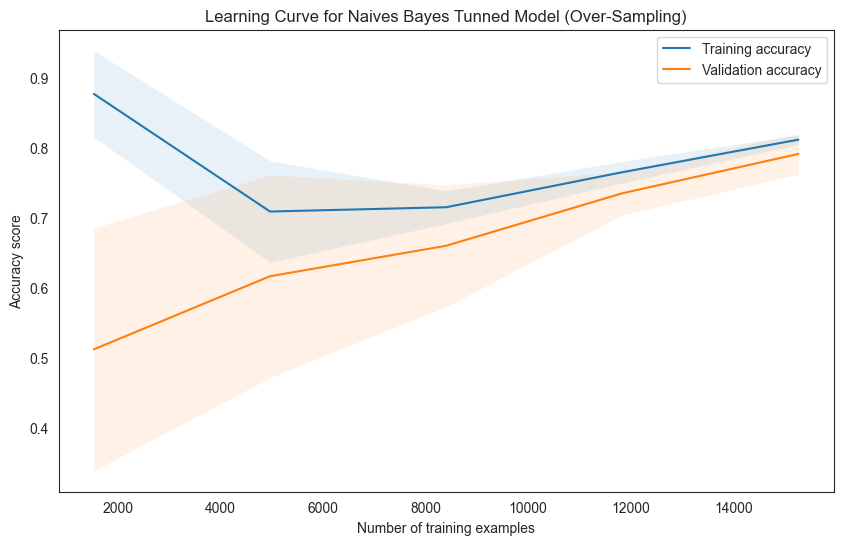

In [166]:
%%time

# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(nb_sm_tuned,X_train_sm, y_train_sm, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Naives Bayes Tunned Model (Over-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Naives Bayes Tuned for Over-Sampling**

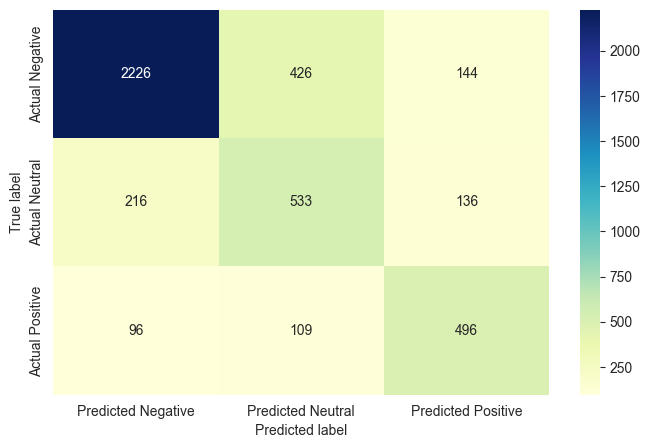

In [167]:
confusion_matrix_sentiment(nb_sm_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Naive Bayes Tuned for Over-Sampling**

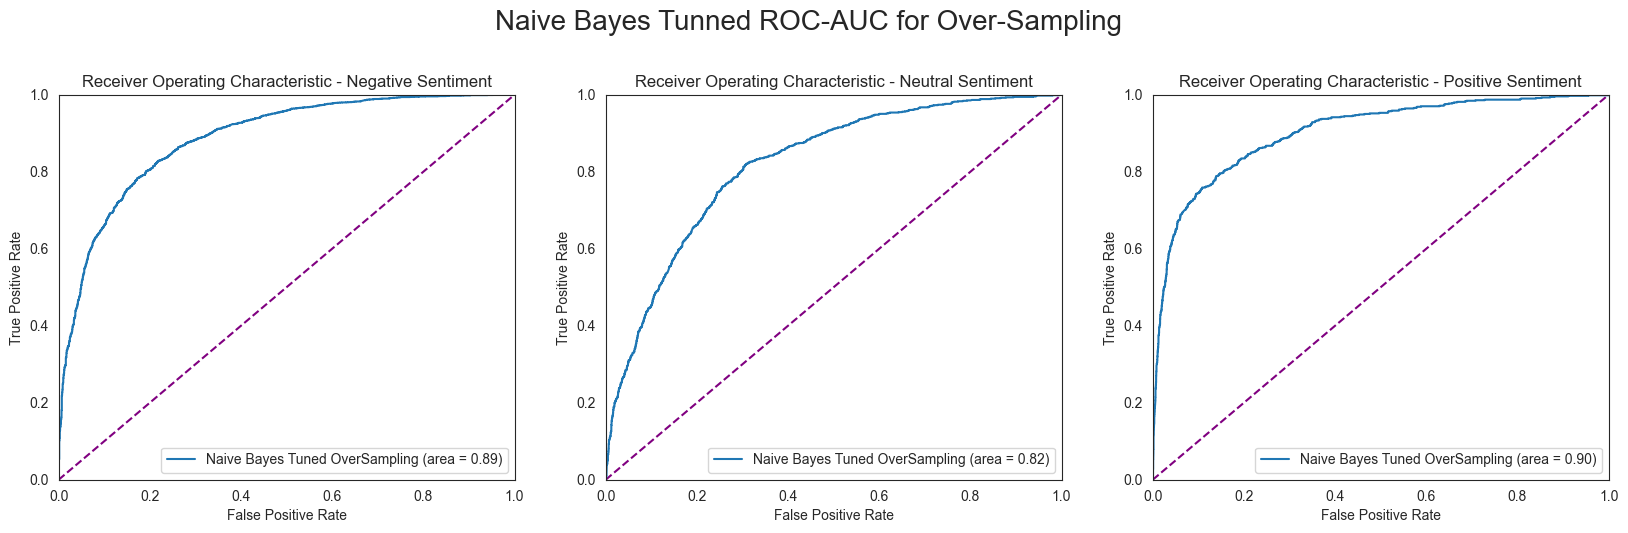

In [168]:
# Calculate AUC score for each sentiment value
nb_sm_tuned_roc_auc_0 = roc_auc_score(y_test == 0, nb_sm_tuned.predict_proba(X_test_vec)[:, 0])
nb_sm_tuned_roc_auc_1 = roc_auc_score(y_test == 1, nb_sm_tuned.predict_proba(X_test_vec)[:, 1])
nb_sm_tuned_roc_auc_2 = roc_auc_score(y_test == 2, nb_sm_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, nb_sm_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, nb_sm_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, nb_sm_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Naive Bayes Tuned OverSampling (area = %0.2f)' % nb_sm_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Naive Bayes Tuned OverSampling (area = %0.2f)' % nb_sm_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Naive Bayes Tuned OverSampling (area = %0.2f)' % nb_sm_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    

plt.suptitle("Naive Bayes Tunned ROC-AUC for Over-Sampling", fontsize=20, y=1.05)

plt.show()

##### **Random Forest Tunning for Over-Sampling**

In [169]:
%%time
## Tunning the logistic Regression model
# defining model
rf1 = RandomForestClassifier()

# Parameter grid to pass in GridSearchCV

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 4, 6, 8, 10, None],
    "max_features": ["sqrt", "log2"],
    "n_estimators": [20, 60, 80, 100],
    # "class_weight": ["balanced", "balanced_subsample"],
    "bootstrap": [True, False]
}



grid_cv = GridSearchCV(
    estimator=rf1,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_sm, y_train_sm)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100} with CV score=0.9054960600064131:
CPU times: total: 14.4 s
Wall time: 16min 25s


In [170]:
rfc_sm_tuned = RandomForestClassifier( 
    n_estimators = 80, 
    max_features = 'log2', 
    max_depth = None, 
    criterion = 'gini',
    bootstrap = False
)

rfc_sm_tuned.fit(X_train_sm, y_train_sm)

RandomForestClassifier(bootstrap=False, max_features='log2', n_estimators=80)

In [171]:
## Checking model performance

# Calculating different metrics on train set
rfc_sm_tunned_train = model_performance_classification_sklearn(
    rfc_sm_tuned, X_train_sm, y_train_sm)

print("Training performance:")
print(rfc_sm_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
rfc_sm_tunned_test = model_performance_classification_sklearn(
    rfc_sm_tuned, X_test_vec, y_test)

print("Testing performance:")
print(rfc_sm_tunned_test)

Training performance:
   Accuracy   Recall  Precision        F1
0   0.98947  0.98947   0.989483  0.989474

**********************************************************************

Testing performance:
   Accuracy   Recall  Precision       F1
0   0.75833  0.75833   0.748925  0.75168


Insight:

- Model is overfitted

**Learning Curve for Random Forest Tunned Model for Over-Sampling**

CPU times: total: 1min 11s
Wall time: 3min 40s


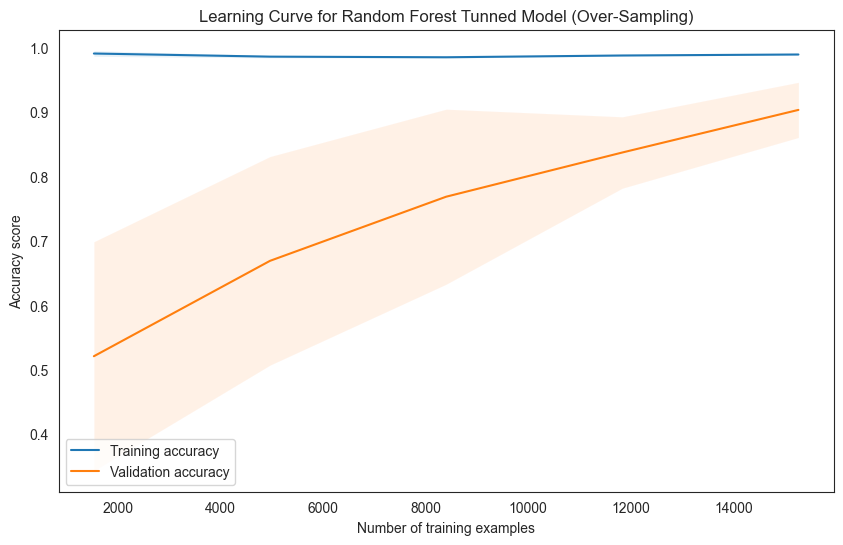

In [172]:
%%time
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc_sm_tuned, X_train_sm, y_train_sm, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Random Forest Tunned Model (Over-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Random Forest Tunned Model for Over-Sampling**

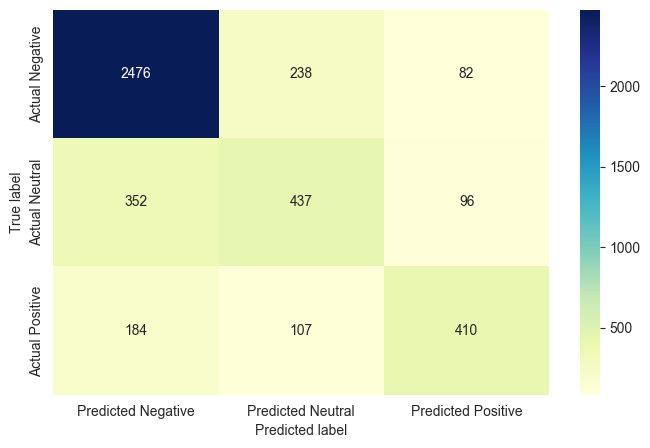

In [173]:
confusion_matrix_sentiment(rfc_sm_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Random Forest Tuned for Over-Sampling**

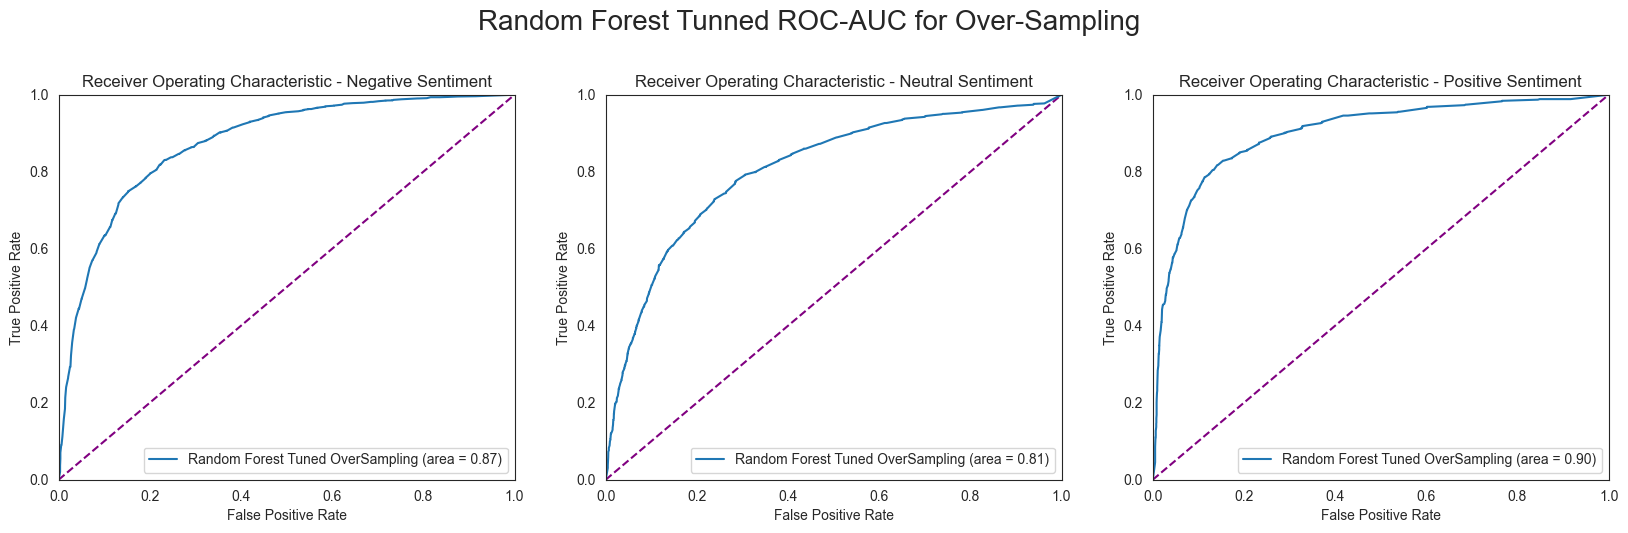

In [174]:
# Calculate AUC score for each sentiment value
rfc_sm_tuned_roc_auc_0 = roc_auc_score(y_test == 0, rfc_sm_tuned.predict_proba(X_test_vec)[:, 0])
rfc_sm_tuned_roc_auc_1 = roc_auc_score(y_test == 1, rfc_sm_tuned.predict_proba(X_test_vec)[:, 1])
rfc_sm_tuned_roc_auc_2 = roc_auc_score(y_test == 2, rfc_sm_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, rfc_sm_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, rfc_sm_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, rfc_sm_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Random Forest Tuned OverSampling (area = %0.2f)' % rfc_sm_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Random Forest Tuned OverSampling (area = %0.2f)' % rfc_sm_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Random Forest Tuned OverSampling (area = %0.2f)' % rfc_sm_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Random Forest Tunned ROC-AUC for Over-Sampling", fontsize=20, y=1.05)


plt.show()

##### **XGBoost Tunning for Over-Sampling**

In [175]:
%%time
# defining model
xgb1 = XGBClassifier()


# Define the parameter grid
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.5, 0.75],
    'min_child_weight': [1, 3],
}



grid_cv = GridSearchCV(
    estimator=xgb1,
    param_grid=param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1,
)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_sm, y_train_sm)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'colsample_bytree': 0.75, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.75} with CV score=0.7693931812109089:
CPU times: total: 26.8 s
Wall time: 13min 31s


In [176]:
# building model with best parameters
xgb_sm_tuned =  XGBClassifier(
    colsample_bytree = 0.75,
    gamma = 0.1,
    learning_rate = 0.1,
    max_depth = 5, 
    min_child_weight = 1,
    n_estimators = 100,
    subsample = 0.5
)

# Fit the model on training data
xgb_sm_tuned.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [177]:
## Checking model performance

# Calculating different metrics on train set
xgb_sm_tunned_train = model_performance_classification_sklearn(
    xgb_sm_tuned, X_train_sm, y_train_sm
)
print("Training performance:")
print(xgb_sm_tunned_train)

print()
print("*************************************")
print()

# Calculating different metrics on test set
xgb_sm_tunned_test = model_performance_classification_sklearn(
    xgb_sm_tuned, X_test_vec, y_test
)
print("Testing performance:")
print(xgb_sm_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.798994  0.798994   0.802438  0.799746

*************************************

Testing performance:
   Accuracy    Recall  Precision       F1
0  0.735737  0.735737   0.745161  0.73964


**Learning Curve for XGBoost Tunned Model for Over-Sampling**

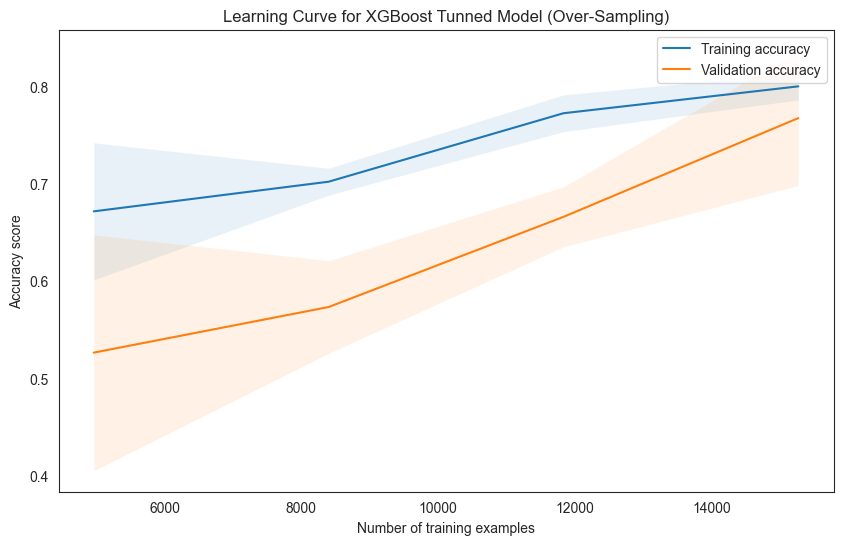

In [178]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(xgb_sm_tuned, X_train_sm, y_train_sm, cv=5,scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for XGBoost Tunned Model (Over-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for XGBoost Tunned Model for Over-sampling**

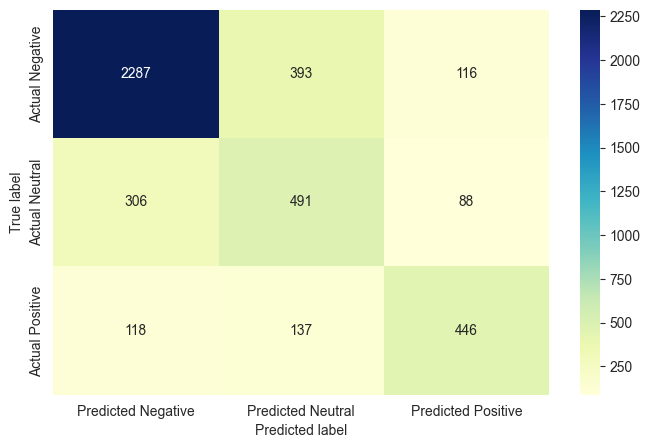

In [179]:
# creating confusion matrix
confusion_matrix_sentiment(xgb_sm_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for XGBoost Tuned for Over-Sampling**

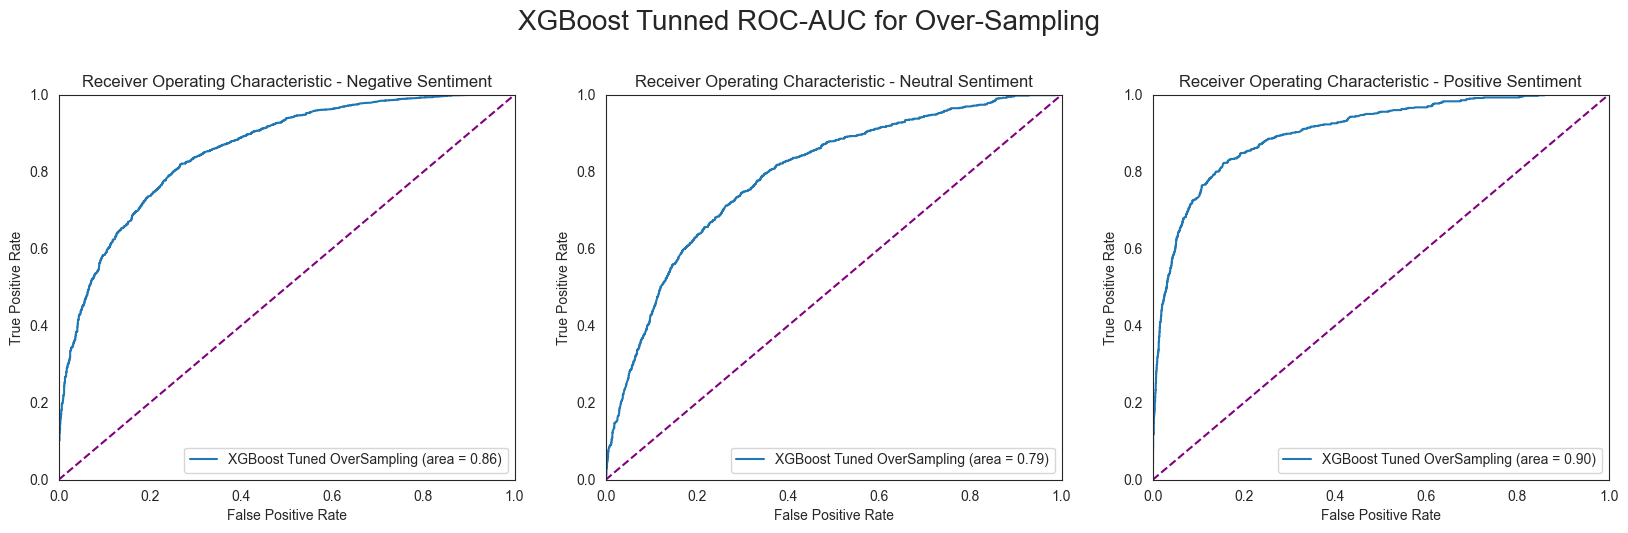

In [180]:
# Calculate AUC score for each sentiment value
xgb_sm_tuned_roc_auc_0 = roc_auc_score(y_test == 0, xgb_sm_tuned.predict_proba(X_test_vec)[:, 0])
xgb_sm_tuned_roc_auc_1 = roc_auc_score(y_test == 1, xgb_sm_tuned.predict_proba(X_test_vec)[:, 1])
xgb_sm_tuned_roc_auc_2 = roc_auc_score(y_test == 2, xgb_sm_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, xgb_sm_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, xgb_sm_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, xgb_sm_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='XGBoost Tuned OverSampling (area = %0.2f)' % xgb_sm_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='XGBoost Tuned OverSampling (area = %0.2f)' % xgb_sm_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='XGBoost Tuned OverSampling (area = %0.2f)' % xgb_sm_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("XGBoost Tunned ROC-AUC for Over-Sampling", fontsize=20, y=1.05)


plt.show()

##### **Comparing all Over-Sampling models**

**Training Performance for all Over-Sampling Models**

In [181]:
# training performance comparison for Over-Sampling Models

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

OverSampling_tunned_models_train_comp = pd.concat(
    [
        
        lr_tunned_sm_train.T,
        clf_sm_tunned_train.T,
        nb_sm_tunned_train.T,
        rfc_sm_tunned_train.T,
        xgb_sm_tunned_train.T
    ],
    axis=1,
)
OverSampling_tunned_models_train_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV OverSampling",
    "Linear SVC Tuned with Grid SearchCV OverSampling",
    "Naives Bayes Tuned with Grid SearchCV OverSampling",
    "Random Forest Tuned with Grid SearchCV OverSampling",
    "XGBoost Tuned with Grid SearchCV OvreSampling"
]
print_formatted("Training Performance Comparison for Tuned with Grid Search with Over-Sampling Balanced Data:")
OverSampling_tunned_models_train_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Training Performance Comparison for Tuned with Grid Search with Over-Sampling Balanced Data:</p>

Logistic Regression Tuned with Grid SearchCV OverSampling  \
Accuracy                                                    0.877573   
Recall                                                      0.877573   
Precision                                                   0.878915   
F1                                                          0.877773   

           Linear SVC Tuned with Grid SearchCV OverSampling  \
Accuracy                                           0.871130   
Recall                                             0.871130   
Precision                                          0.872877   
F1                                                 0.871354   

           Naives Bayes Tuned with Grid SearchCV OverSampling  \
Accuracy                                             0.810152   
Recall                                               0.810152   
Precision                                            0.809588   
F1                                                   0.809776   

           Random Forest Tuned with Grid SearchCV OverSampling  \
Accuracy                                              0.989470   
Recall                                                0.989470   
Precision                                             0.989483   
F1                                                    0.989474   

           XGBoost Tuned with Grid SearchCV OvreSampling  
Accuracy                                        0.798994  
Recall                                          0.798994  
Precision                                       0.802438  
F1                                              0.799746

**Testing Performance for all Over-Sampling Models**

In [182]:
# training performance comparison fir Over-Sampling Models

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

OverSampling_tunned_models_test_comp = pd.concat(
    [
        
        lr_tunned_sm_test.T,
        clf_sm_tunned_test.T,
        nb_sm_tunned_test.T,
        rfc_sm_tunned_test.T,
        xgb_sm_tunned_test.T
    ],
    axis=1,
)
OverSampling_tunned_models_test_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV OverSampling",
    "Linear SVC Tuned with Grid SearchCV OverSampling",
    "Naives Bayes Tuned with Grid SearchCV OverSampling",
    "Random Forest Tuned with Grid SearchCV OverSampling",
    "XGBoost Tuned with Grid SearchCV OverSampling"
]
print_formatted("Testing Performance Comparison for Tuned with Grid Search with Over-Sampling Balanced Data:")
OverSampling_tunned_models_test_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Testing Performance Comparison for Tuned with Grid Search with Over-Sampling Balanced Data:</p>

Logistic Regression Tuned with Grid SearchCV OverSampling  \
Accuracy                                                    0.732770   
Recall                                                      0.732770   
Precision                                                   0.756209   
F1                                                          0.741271   

           Linear SVC Tuned with Grid SearchCV OverSampling  \
Accuracy                                           0.728206   
Recall                                             0.728206   
Precision                                          0.752873   
F1                                                 0.736772   

           Naives Bayes Tuned with Grid SearchCV OverSampling  \
Accuracy                                             0.742812   
Recall                                               0.742812   
Precision                                            0.762669   
F1                                                   0.750237   

           Random Forest Tuned with Grid SearchCV OverSampling  \
Accuracy                                              0.758330   
Recall                                                0.758330   
Precision                                             0.748925   
F1                                                    0.751680   

           XGBoost Tuned with Grid SearchCV OverSampling  
Accuracy                                        0.735737  
Recall                                          0.735737  
Precision                                       0.745161  
F1                                              0.739640

##### **Comparing all AUC-ROC for Over-Sampling Balanced Models**

In [183]:
# AUC-ROC performance comparison


# Create pandas Series for each model
OverSampling_log_series = pd.Series([lr_sm_roc_auc_0, lr_sm_roc_auc_1, lr_sm_roc_auc_2], name='Logistic Regression AUC-ROC Tuned')
OverSampling_svc_series = pd.Series([clf_sm_tuned_roc_auc_0, clf_sm_tuned_roc_auc_1, clf_sm_tuned_roc_auc_2], name='Linear SVC AUC-ROC Tuned')
OverSampling_nb_series = pd.Series([nb_sm_tuned_roc_auc_0, nb_sm_tuned_roc_auc_1, nb_sm_tuned_roc_auc_2], name='Naive Bayes AUC-ROC Tuned')
OverSampling_rfc_series = pd.Series([rfc_sm_tuned_roc_auc_0, rfc_sm_tuned_roc_auc_1, rfc_sm_tuned_roc_auc_2], name='Random Forest AUC-ROC Tuned')
OverSampling_xgb_series = pd.Series([xgb_sm_tuned_roc_auc_0, xgb_sm_tuned_roc_auc_1, xgb_sm_tuned_roc_auc_2], name='XGBoost AUC-ROC Tuned')



OverSampling_tunned_roc_comp = pd.concat(
    [
        OverSampling_log_series.T,
        OverSampling_svc_series.T,
        OverSampling_nb_series.T,
        OverSampling_rfc_series.T,
        OverSampling_xgb_series.T
    ],
    axis=1,
)


# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

print_formatted("AUC-ROC Performance Comparison for Tuned with Grid Search with Over-Sampling Balanced Data:")

OverSampling_tunned_roc_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>AUC-ROC Performance Comparison for Tuned with Grid Search with Over-Sampling Balanced Data:</p>

Logistic Regression AUC-ROC Tuned  Linear SVC AUC-ROC Tuned  \
0                           0.877641                  0.874113   
1                           0.815573                  0.813692   
2                           0.894742                  0.892433   

   Naive Bayes AUC-ROC Tuned  Random Forest AUC-ROC Tuned  \
0                   0.885972                     0.874655   
1                   0.817682                     0.805940   
2                   0.902431                     0.900257   

   XGBoost AUC-ROC Tuned  
0               0.855923  
1               0.790284  
2               0.903565

#### **Modeling with Under-Sampling Balanced Target Variable**

In [184]:
df_clean.sentiment.value_counts(normalize=True).mul(100)

negative    62.715694
neutral     21.165434
positive    16.118872
Name: sentiment, dtype: float64

In [185]:
#Under-sampling with Tomek Links
tk = TomekLinks(sampling_strategy="majority")
X_train_tk, y_train_tk = tk.fit_resample(X_train_vec, y_train)
y_train_tk.value_counts(normalize=True).mul(100)

0    61.098790
1    22.237903
2    16.663306
Name: sentiment, dtype: float64

##### **Cross Validation Performance for Under-Sampling**

In [186]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("LogisticRegression", LogisticRegression(random_state=42)))

models.append(("SVC", LinearSVC(C=1)))

models.append(("Naive Bayes", MultinomialNB()))

models.append(("RandomForest", RandomForestClassifier(n_estimators = 100)))

models.append(("XGBoost", XGBClassifier()))


results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "f1_macro"  # set the scoring metric to F1 score with macro averaging
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=42
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_tk, y=y_train_tk, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train_tk, y_train_tk)
    scores = f1_score(y_train_tk, model.predict(X_train_tk), average="macro") * 100
    print("{}: {}".format(name, scores))

print("\n" "Testing Performance:" "\n")

for name, model in models:
    model.fit(X_train_tk, y_train_tk)
    scores = f1_score(y_test, model.predict(X_test_vec), average="macro") * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

LogisticRegression: 69.10452877595444
SVC: 69.13771868081453
Naive Bayes: 63.3560856086339
RandomForest: 65.11741731824716
XGBoost: 67.23297686294116

Training Performance:

LogisticRegression: 77.14191383159032
SVC: 80.03643004911774
Naive Bayes: 68.23796699339836
RandomForest: 98.33066533720637
XGBoost: 82.51323819668549

Testing Performance:

LogisticRegression: 70.58633459557568
SVC: 70.19512259105481
Naive Bayes: 62.69969596074185
RandomForest: 65.5859831437149
XGBoost: 68.18918371082498


##### **Logistic Regression Model Tunning for Under-Sampling**

In [187]:
%%time
## Tunning the logistic Regression model
# defining model
lr3 = LogisticRegression(random_state=42)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter' : [50, 100, 150, 200]
}




grid_cv = GridSearchCV(
    estimator=lr3,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_tk, y_train_tk)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 10, 'max_iter': 50, 'penalty': 'l2', 'solver': 'liblinear'} with CV score=0.7021533883591121:
CPU times: total: 2.12 s
Wall time: 56.1 s


In [188]:
lr_tuned_tk = LogisticRegression( 
    C = 10, 
    max_iter = 50, 
    penalty = 'l2', 
    solver = 'liblinear')

lr_tuned_tk.fit(X_train_tk, y_train_tk)

LogisticRegression(C=10, max_iter=50, solver='liblinear')

In [189]:
## Checking model performance

# Calculating different metrics on train set
lr_tunned_tk_train = model_performance_classification_sklearn(
    lr_tuned_tk, X_train_tk, y_train_tk)

print("Training performance:")
print(lr_tunned_tk_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
lr_tunned_tk_test = model_performance_classification_sklearn(
    lr_tuned_tk, X_test_vec, y_test)

print("Testing performance:")
print(lr_tunned_tk_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.845766  0.845766   0.842097  0.841968

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.776586  0.776586   0.771137  0.773018


**Learning curve for Logistic Regression Tuned for Under-Sampling**

CPU times: total: 2.3 s
Wall time: 2.3 s


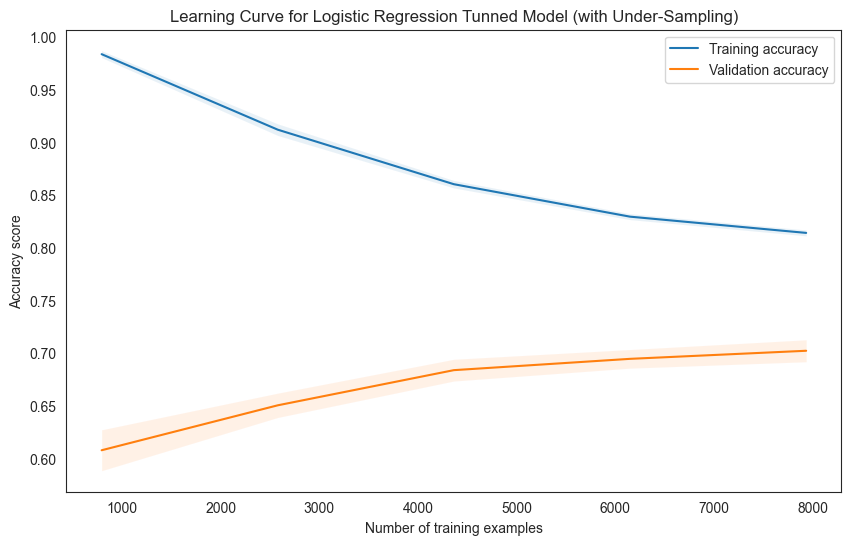

In [190]:
%%time


# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(lr_tuned_tk, X_train_tk, y_train_tk, cv=5, scoring = "f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Logistic Regression Tunned Model (with Under-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Logistic Regression Tuned for Under-Sampling**

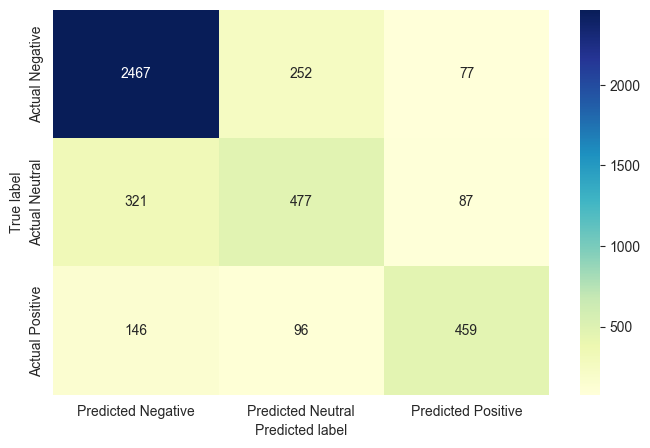

In [191]:
confusion_matrix_sentiment(lr_tuned_tk, X_test_vec, y_test)

**Receiver Operating Characteristic for lr Tuned for Under-Sampling**

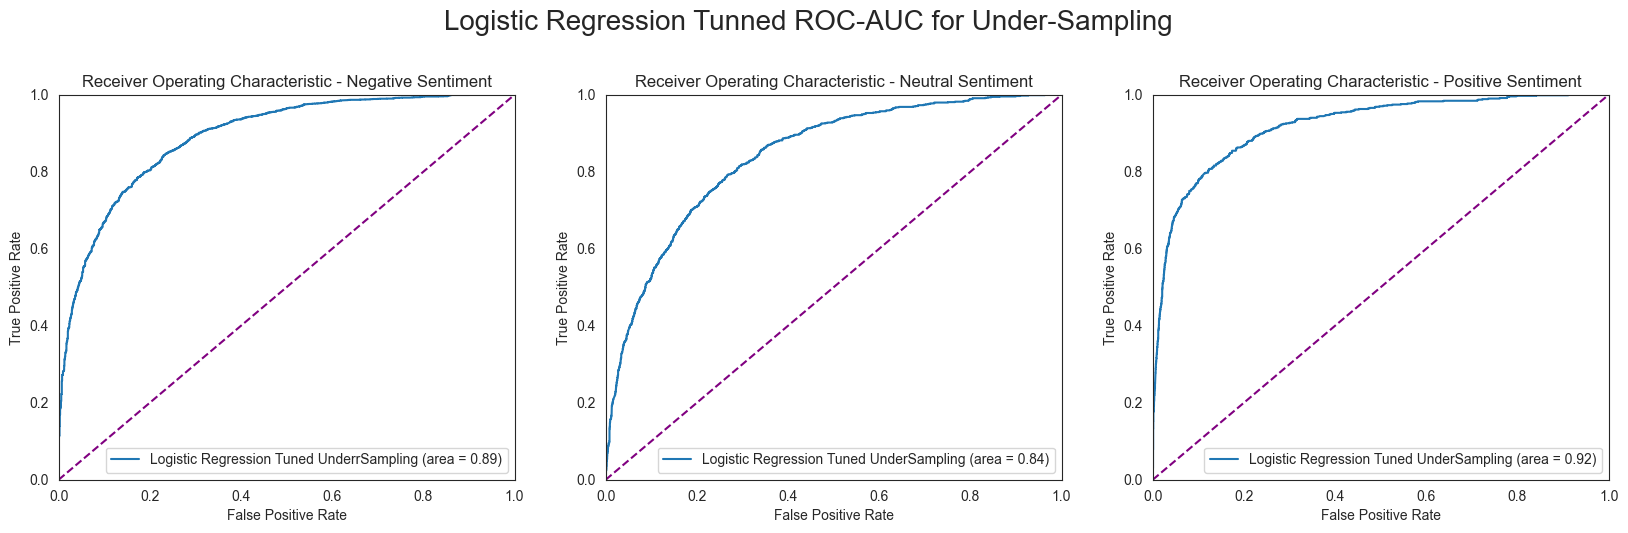

In [192]:
# Calculate AUC score for each sentiment value
lr_tk_roc_auc_0 = roc_auc_score(y_test == 0, lr_tuned_tk.predict_proba(X_test_vec)[:, 0])
lr_tk_roc_auc_1 = roc_auc_score(y_test == 1, lr_tuned_tk.predict_proba(X_test_vec)[:, 1])
lr_tk_roc_auc_2 = roc_auc_score(y_test == 2, lr_tuned_tk.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, lr_tuned_tk.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, lr_tuned_tk.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, lr_tuned_tk.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Logistic Regression Tuned UnderrSampling (area = %0.2f)' % lr_tk_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Logistic Regression Tuned UnderSampling (area = %0.2f)' % lr_tk_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Logistic Regression Tuned UnderSampling (area = %0.2f)' % lr_tk_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Logistic Regression Tunned ROC-AUC for Under-Sampling", fontsize=20, y=1.05)

plt.show()

##### **SVC Model Tunning for Under-Sampling**

In [193]:
%%time
## Tunning the logistic Regression model
# defining model
sl2 = LinearSVC(C=1)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'max_iter': [50, 100, 150, 200]
}



grid_cv = GridSearchCV(
    estimator=sl2,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_tk, y_train_tk)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 1, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 150, 'penalty': 'l1'} with CV score=0.7030040094489161:
CPU times: total: 1.75 s
Wall time: 11 s


In [194]:
clf_tk_tuned = LinearSVC( 
    C = 1, 
    dual = False, 
    loss = 'squared_hinge', 
    max_iter = 200,
    penalty = 'l1')

clf_tk_tuned.fit(X_train_tk, y_train_tk)

LinearSVC(C=1, dual=False, max_iter=200, penalty='l1')

In [195]:
## Checking model performance

# Calculating different metrics on train set
clf_tk_tunned_train = model_performance_classification_sklearn(
    clf_tk_tuned, X_train_tk, y_train_tk)

print("Training performance:")
print(clf_tk_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
clf_tk_tunned_test = model_performance_classification_sklearn(
    clf_tk_tuned, X_test_vec, y_test)

print("Testing performance:")
print(clf_tk_tunned_test)

Training performance:
   Accuracy    Recall  Precision       F1
0  0.841935  0.841935   0.838115  0.83818

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision       F1
0  0.774076  0.774076   0.768917  0.77069


**Learning Curve for Linear SVC Tuned for Under-Sampling**

CPU times: total: 1.33 s
Wall time: 4.33 s


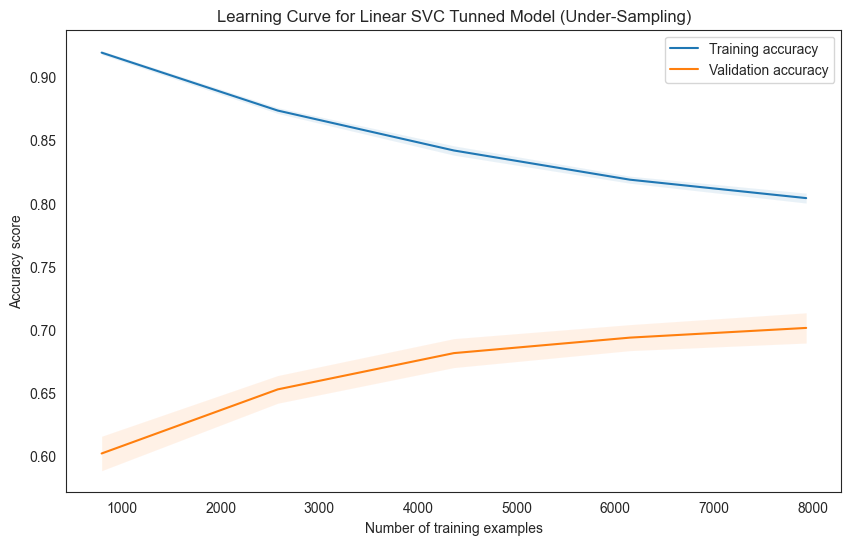

In [196]:
%%time


# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(clf_tk_tuned, X_train_tk, y_train_tk, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Linear SVC Tunned Model (Under-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Linear SVC Tuned for Under-Sampling**

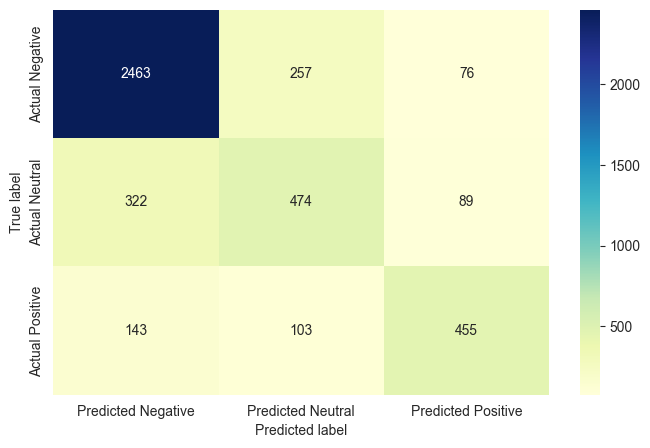

In [197]:
confusion_matrix_sentiment(clf_tk_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for SVC Tuned for Under-Sampling**

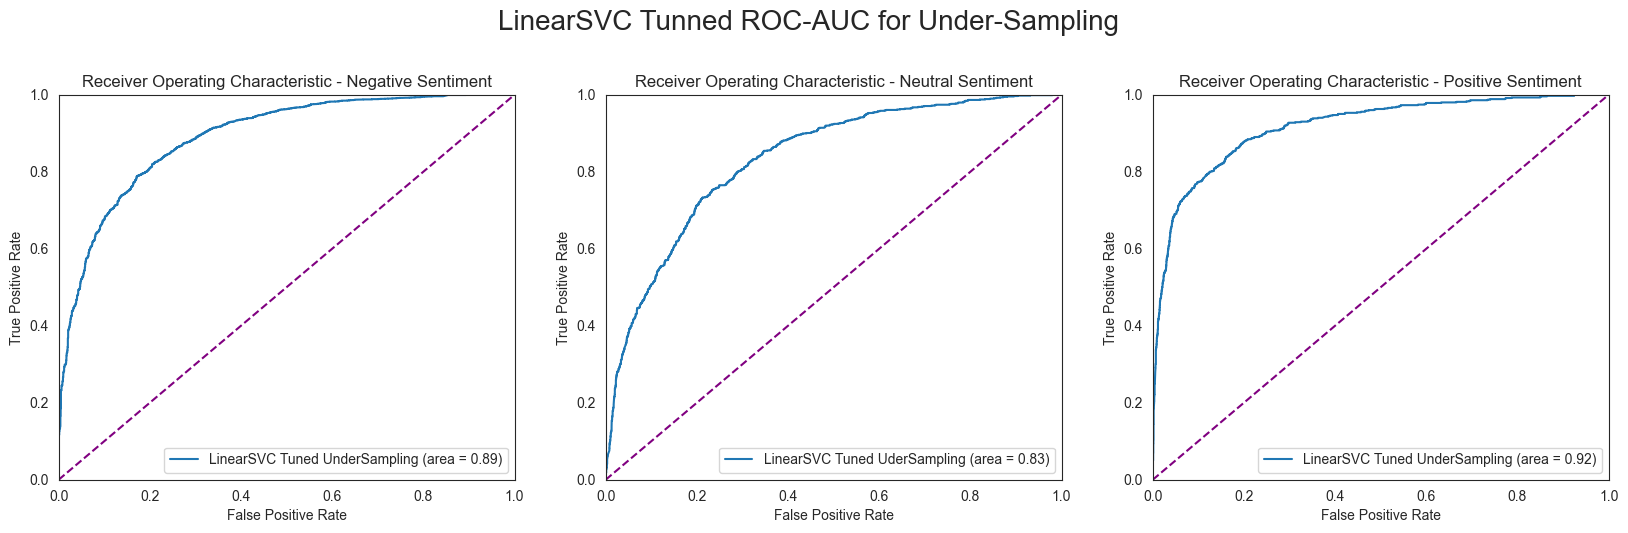

In [198]:
# Calculate AUC score for each sentiment value
clf_tk_tuned_roc_auc_0 = roc_auc_score(y_test == 0, clf_tk_tuned.decision_function(X_test_vec)[:, 0])
clf_tk_tuned_roc_auc_1 = roc_auc_score(y_test == 1, clf_tk_tuned.decision_function(X_test_vec)[:, 1])
clf_tk_tuned_roc_auc_2 = roc_auc_score(y_test == 2, clf_tk_tuned.decision_function(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, clf_tk_tuned.decision_function(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, clf_tk_tuned.decision_function(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, clf_tk_tuned.decision_function(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='LinearSVC Tuned UnderSampling (area = %0.2f)' % clf_tk_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='LinearSVC Tuned UderSampling (area = %0.2f)' % clf_tk_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='LinearSVC Tuned UnderSampling (area = %0.2f)' % clf_tk_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

plt.suptitle("LinearSVC Tunned ROC-AUC for Under-Sampling", fontsize=20, y=1.05)


plt.show()

##### **Naive Bayes Model Tunning for Under-Sampling**

In [199]:
%%time
## Tunning the logistic Regression model
# defining model
nb3 = MultinomialNB()

# Parameter grid to pass in GridSearchCV

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}



grid_cv = GridSearchCV(
    estimator=nb3,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_tk, y_train_tk)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'alpha': 0.1, 'fit_prior': False} with CV score=0.6796799577602538:
CPU times: total: 203 ms
Wall time: 199 ms


In [200]:
nb_tk_tuned = MultinomialNB( 
    alpha = 0.1, 
    fit_prior = False)

nb_tk_tuned.fit(X_train_tk, y_train_tk)

MultinomialNB(alpha=0.1, fit_prior=False)

In [201]:
## Checking model performance

# Calculating different metrics on train set
nb_tk_tunned_train = model_performance_classification_sklearn(
    nb_tk_tuned, X_train_tk, y_train_tk)

print("Training performance:")
print(nb_tk_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
nb_tk_tunned_test = model_performance_classification_sklearn(
    nb_tk_tuned, X_test_vec, y_test)

print("Testing performance:")
print(nb_tk_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.780242  0.780242   0.805087  0.786932

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.728435  0.728435   0.763045  0.739088


**Learning Curve for Naives Bayes Tuned for Under-Sampling**

CPU times: total: 141 ms
Wall time: 375 ms


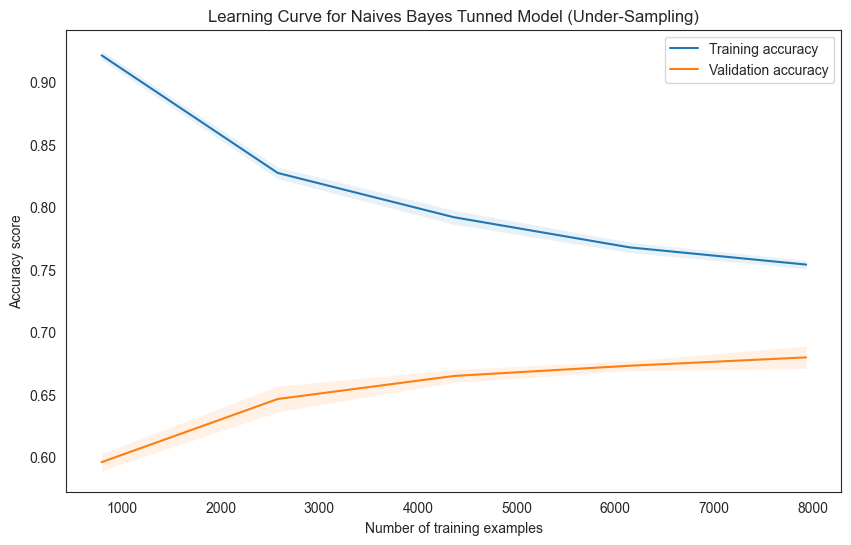

In [202]:
%%time

# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(nb_tk_tuned,X_train_tk, y_train_tk, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Naives Bayes Tunned Model (Under-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Naives Bayes Tuned for Under-Sampling**

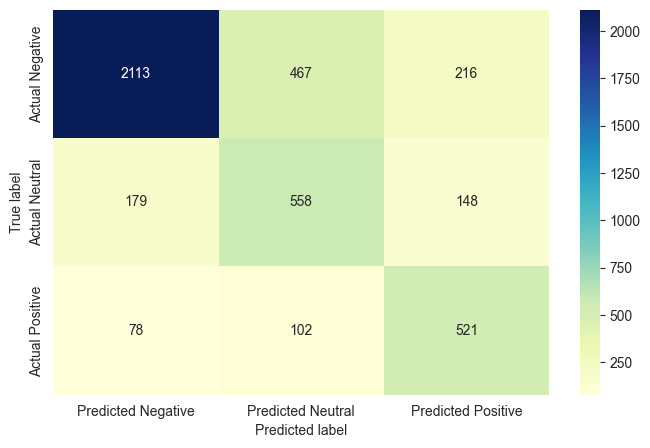

In [203]:
confusion_matrix_sentiment(nb_tk_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Naive Bayes Tuned for Under-Sampling**

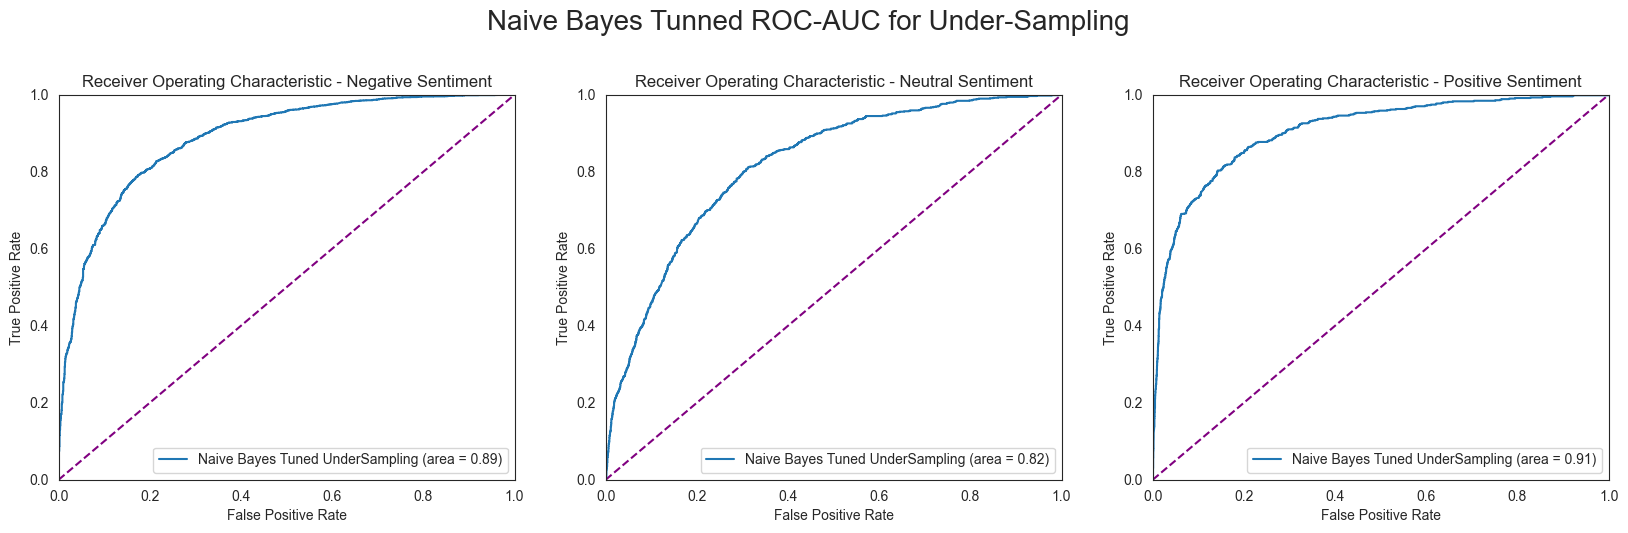

In [204]:
# Calculate AUC score for each sentiment value
nb_tk_tuned_roc_auc_0 = roc_auc_score(y_test == 0, nb_tk_tuned.predict_proba(X_test_vec)[:, 0])
nb_tk_tuned_roc_auc_1 = roc_auc_score(y_test == 1, nb_tk_tuned.predict_proba(X_test_vec)[:, 1])
nb_tk_tuned_roc_auc_2 = roc_auc_score(y_test == 2, nb_tk_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, nb_tk_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, nb_tk_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, nb_tk_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Naive Bayes Tuned UnderSampling (area = %0.2f)' % nb_tk_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Naive Bayes Tuned UnderSampling (area = %0.2f)' % nb_tk_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Naive Bayes Tuned UnderSampling (area = %0.2f)' % nb_tk_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

    
plt.suptitle("Naive Bayes Tunned ROC-AUC for Under-Sampling", fontsize=20, y=1.05)
    

plt.show()

##### **Random Forest Tunning for Under-Sampling**

In [205]:
%%time
## Tunning the logistic Regression model
# defining model
rf2 = RandomForestClassifier()

# Parameter grid to pass in GridSearchCV

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 4, 6, 8, 10, None],
    "max_features": ["sqrt", "log2"],
    "n_estimators": [20, 60, 80, 100],
    # "class_weight": ["balanced", "balanced_subsample"],
    "bootstrap": [True, False]
}



grid_cv = GridSearchCV(
    estimator=rf2,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_tk, y_train_tk)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'bootstrap': False, 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100} with CV score=0.6646012838875551:
CPU times: total: 12.3 s
Wall time: 9min 36s


In [206]:
rfc_tk_tuned = RandomForestClassifier( 
    n_estimators = 100, 
    max_features = 'log2', 
    max_depth = None, 
    criterion = 'entropy',
    bootstrap = False
)

rfc_tk_tuned.fit(X_train_tk, y_train_tk)

RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features='log2')

In [207]:
## Checking model performance

# Calculating different metrics on train set
rfc_tk_tunned_train = model_performance_classification_sklearn(
    rfc_tk_tuned, X_train_tk, y_train_tk)

print("Training performance:")
print(rfc_tk_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
rfc_tk_tunned_test = model_performance_classification_sklearn(
    rfc_tk_tuned, X_test_vec, y_test)

print("Testing performance:")
print(rfc_tk_tunned_test)

Training performance:
   Accuracy    Recall  Precision       F1
0  0.987802  0.987802   0.987869  0.98782

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.764263  0.764263   0.752299  0.752473


**Learning Curve for Random Forest Tunned Model for Under-Sampling**

CPU times: total: 50.9 s
Wall time: 2min 39s


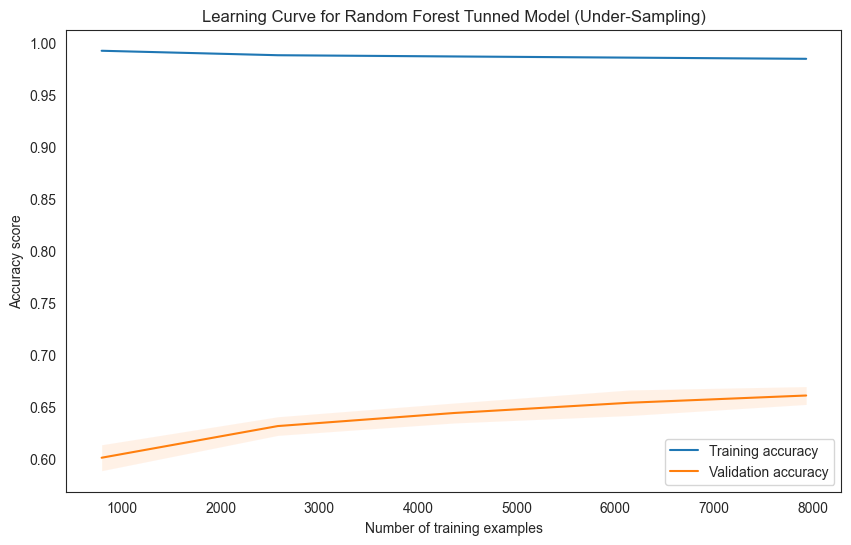

In [208]:
%%time
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc_tk_tuned, X_train_tk, y_train_tk, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Random Forest Tunned Model (Under-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Random Forest Tunned Model for Under-Sampling**

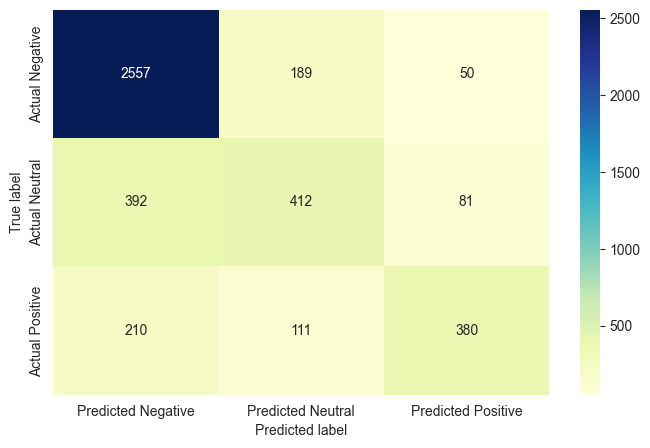

In [209]:
confusion_matrix_sentiment(rfc_tk_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Random Forest Tuned for Under-Sampling**

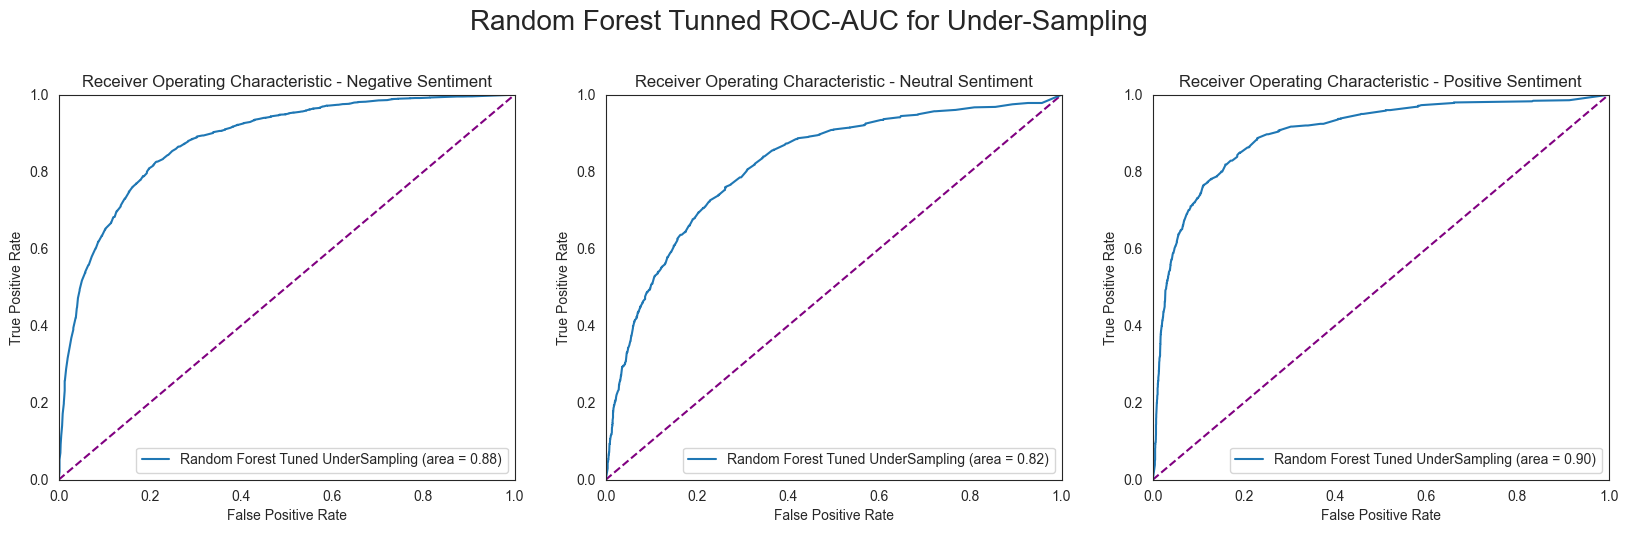

In [210]:
# Calculate AUC score for each sentiment value
rfc_tk_tuned_roc_auc_0 = roc_auc_score(y_test == 0, rfc_tk_tuned.predict_proba(X_test_vec)[:, 0])
rfc_tk_tuned_roc_auc_1 = roc_auc_score(y_test == 1, rfc_tk_tuned.predict_proba(X_test_vec)[:, 1])
rfc_tk_tuned_roc_auc_2 = roc_auc_score(y_test == 2, rfc_tk_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, rfc_tk_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, rfc_tk_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, rfc_tk_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Random Forest Tuned UnderSampling (area = %0.2f)' % rfc_tk_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Random Forest Tuned UnderSampling (area = %0.2f)' % rfc_tk_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Random Forest Tuned UnderSampling (area = %0.2f)' % rfc_tk_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")


plt.suptitle("Random Forest Tunned ROC-AUC for Under-Sampling", fontsize=20, y=1.05)


plt.show()

##### **XGBoost Tunning for Under-Sampling**

In [211]:
%%time
# defining model
xgb2 = XGBClassifier()


# Define the parameter grid
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.5, 0.75],
    'min_child_weight': [1, 3],
}



grid_cv = GridSearchCV(
    estimator=xgb2,
    param_grid=param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1,
)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_tk, y_train_tk)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'colsample_bytree': 0.75, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.75} with CV score=0.638922719292477:
CPU times: total: 16 s
Wall time: 4h 30min 41s


In [212]:
# building model with best parameters
xgb_tk_tuned =  XGBClassifier(
    colsample_bytree = 0.75,
    gamma = 0,
    learning_rate = 0.1,
    max_depth = 5, 
    min_child_weight = 1,
    n_estimators = 100,
    subsample = 0.75
)

# Fit the model on training data
xgb_tk_tuned.fit(X_train_tk, y_train_tk)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [213]:
## Checking model performance

# Calculating different metrics on train set
xgb_tk_tunned_train = model_performance_classification_sklearn(
    xgb_tk_tuned, X_train_tk, y_train_tk
)
print("Training performance:")
print(xgb_tk_tunned_train)

print()
print("*************************************")
print()

# Calculating different metrics on test set
xgb_tk_tunned_test = model_performance_classification_sklearn(
    xgb_tk_tuned, X_test_vec, y_test
)
print("Testing performance:")
print(xgb_tk_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.771673  0.771673   0.764546  0.754032

*************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.750571  0.750571   0.731616  0.730595


**Learning Curve for XGBoost Tunned Model for Under-Sampling**

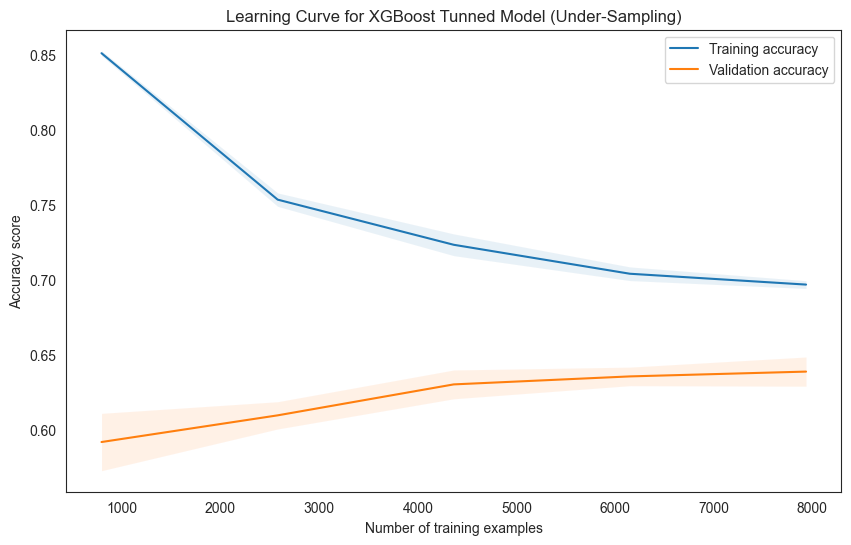

In [214]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(xgb_tk_tuned, X_train_tk, y_train_tk, cv=5,scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for XGBoost Tunned Model (Under-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for XGBoost Tunned Model for Under-sampling**

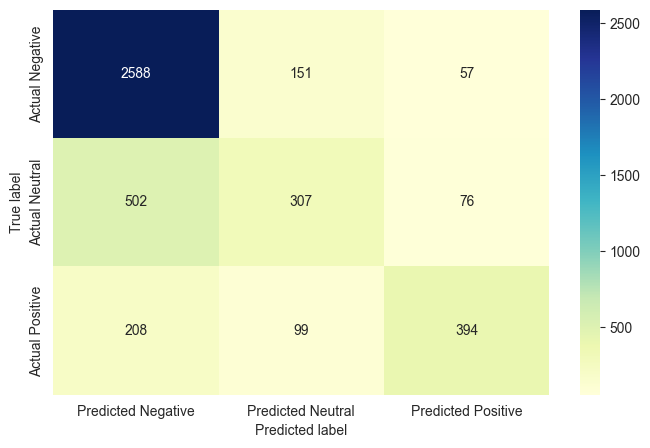

In [215]:
# creating confusion matrix
confusion_matrix_sentiment(xgb_tk_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for XGBoost Tuned for Under-Sampling**

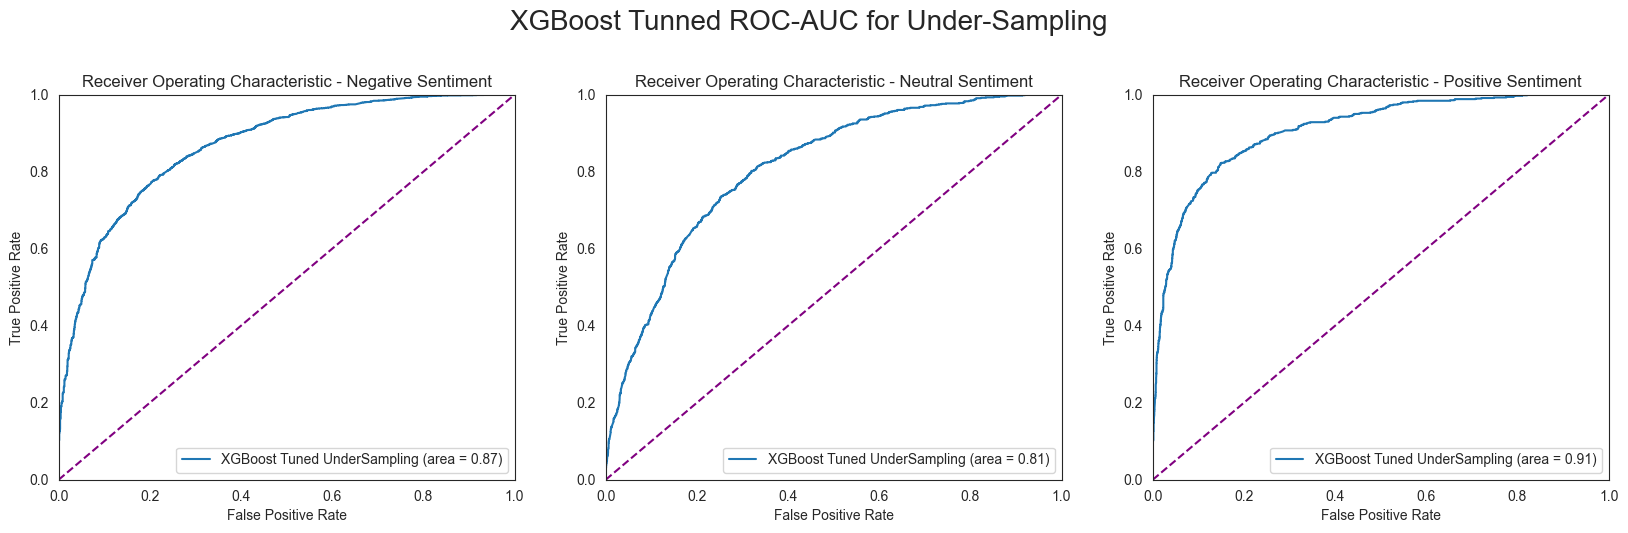

In [216]:
# Calculate AUC score for each sentiment value
xgb_tk_tuned_roc_auc_0 = roc_auc_score(y_test == 0, xgb_tk_tuned.predict_proba(X_test_vec)[:, 0])
xgb_tk_tuned_roc_auc_1 = roc_auc_score(y_test == 1, xgb_tk_tuned.predict_proba(X_test_vec)[:, 1])
xgb_tk_tuned_roc_auc_2 = roc_auc_score(y_test == 2, xgb_tk_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, xgb_tk_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, xgb_tk_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, xgb_tk_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='XGBoost Tuned UnderSampling (area = %0.2f)' % xgb_tk_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='XGBoost Tuned UnderSampling (area = %0.2f)' % xgb_tk_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='XGBoost Tuned UnderSampling (area = %0.2f)' % xgb_tk_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("XGBoost Tunned ROC-AUC for Under-Sampling", fontsize=20, y=1.05)


plt.show()

##### **Comparing all Under-Sampling models**

**Training Performance for all Under-Sampling Models**

In [217]:
# training performance comparison for Over-Sampling Models

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

UnderSampling_tunned_models_train_comp = pd.concat(
    [
        
        lr_tunned_tk_train.T,
        clf_tk_tunned_train.T,
        nb_tk_tunned_train.T,
        rfc_tk_tunned_train.T,
        xgb_tk_tunned_train.T
    ],
    axis=1,
)
UnderSampling_tunned_models_train_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV UnderSampling",
    "Linear SVC Tuned with Grid SearchCV UnderSampling",
    "Naives Bayes Tuned with Grid SearchCV UnderSampling",
    "Random Forest Tuned with Grid SearchCV UnderSampling",
    "XGBoost Tuned with Grid SearchCV UnderSampling"
]
print_formatted("Training Performance Comparison for Tuned with Grid Search with Under-Sampling Balanced Data:")
UnderSampling_tunned_models_train_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Training Performance Comparison for Tuned with Grid Search with Under-Sampling Balanced Data:</p>

Logistic Regression Tuned with Grid SearchCV UnderSampling  \
Accuracy                                                     0.845766   
Recall                                                       0.845766   
Precision                                                    0.842097   
F1                                                           0.841968   

           Linear SVC Tuned with Grid SearchCV UnderSampling  \
Accuracy                                            0.841935   
Recall                                              0.841935   
Precision                                           0.838115   
F1                                                  0.838180   

           Naives Bayes Tuned with Grid SearchCV UnderSampling  \
Accuracy                                              0.780242   
Recall                                                0.780242   
Precision                                             0.805087   
F1                                                    0.786932   

           Random Forest Tuned with Grid SearchCV UnderSampling  \
Accuracy                                               0.987802   
Recall                                                 0.987802   
Precision                                              0.987869   
F1                                                     0.987820   

           XGBoost Tuned with Grid SearchCV UnderSampling  
Accuracy                                         0.771673  
Recall                                           0.771673  
Precision                                        0.764546  
F1                                               0.754032

**Testing Performance for all Under-Sampling Models**

In [218]:
# training performance comparison fir Over-Sampling Models

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

UnderSampling_tunned_models_test_comp = pd.concat(
    [
        
        lr_tunned_tk_test.T,
        clf_tk_tunned_test.T,
        nb_tk_tunned_test.T,
        rfc_tk_tunned_test.T,
        xgb_tk_tunned_test.T
    ],
    axis=1,
)
UnderSampling_tunned_models_test_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV UnderSampling",
    "Linear SVC Tuned with Grid SearchCV UnderSampling",
    "Naives Bayes Tuned with Grid SearchCV UnderSampling",
    "Random Forest Tuned with Grid SearchCV UnderSampling",
    "XGBoost Tuned with Grid SearchCV UnderSampling"
]
print_formatted("Testing Performance Comparison for Tuned with Grid Search with Under-Sampling Balanced Data:")
UnderSampling_tunned_models_test_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Testing Performance Comparison for Tuned with Grid Search with Under-Sampling Balanced Data:</p>

Logistic Regression Tuned with Grid SearchCV UnderSampling  \
Accuracy                                                     0.776586   
Recall                                                       0.776586   
Precision                                                    0.771137   
F1                                                           0.773018   

           Linear SVC Tuned with Grid SearchCV UnderSampling  \
Accuracy                                            0.774076   
Recall                                              0.774076   
Precision                                           0.768917   
F1                                                  0.770690   

           Naives Bayes Tuned with Grid SearchCV UnderSampling  \
Accuracy                                              0.728435   
Recall                                                0.728435   
Precision                                             0.763045   
F1                                                    0.739088   

           Random Forest Tuned with Grid SearchCV UnderSampling  \
Accuracy                                               0.764263   
Recall                                                 0.764263   
Precision                                              0.752299   
F1                                                     0.752473   

           XGBoost Tuned with Grid SearchCV UnderSampling  
Accuracy                                         0.750571  
Recall                                           0.750571  
Precision                                        0.731616  
F1                                               0.730595

##### **Comparing all AUC-ROC for Under-Sampling Balanced Models**

In [219]:
# AUC-ROC performance comparison for all Under-Sampling Models


# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))


# Create pandas Series for each model
UnderSampling_log_series = pd.Series([lr_tk_roc_auc_0, lr_tk_roc_auc_1, lr_tk_roc_auc_2], name='Logistic Regression AUC-ROC Tuned UnderSampling')
UnderSampling_svc_series = pd.Series([clf_tk_tuned_roc_auc_0, clf_tk_tuned_roc_auc_1, clf_tk_tuned_roc_auc_2], name='Linear SVC AUC-ROC Tuned UnderSampling')
UnderSampling_nb_series = pd.Series([nb_tk_tuned_roc_auc_0, nb_tk_tuned_roc_auc_1, nb_tk_tuned_roc_auc_2], name='Naive Bayes AUC-ROC Tuned UnderSampling')
UnderSampling_rfc_series = pd.Series([rfc_tk_tuned_roc_auc_0, rfc_tk_tuned_roc_auc_1, rfc_tk_tuned_roc_auc_2], name='Random Forest AUC-ROC Tuned UnderSampling')
UnderSampling_xgb_series = pd.Series([xgb_tk_tuned_roc_auc_0, xgb_tk_tuned_roc_auc_1, xgb_tk_tuned_roc_auc_2], name='XGBoost AUC-ROC Tuned UnderSampling')



UnderSampling_tunned_roc_comp = pd.concat(
    [
        UnderSampling_log_series.T,
        UnderSampling_svc_series.T,
        UnderSampling_nb_series.T,
        UnderSampling_rfc_series.T,
        UnderSampling_xgb_series.T
    ],
    axis=1,
)


print_formatted("AUC-ROC Performance Comparison for Tuned with Grid Search with Under-Sampling Balanced Data:")

UnderSampling_tunned_roc_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>AUC-ROC Performance Comparison for Tuned with Grid Search with Under-Sampling Balanced Data:</p>

Logistic Regression AUC-ROC Tuned UnderSampling  \
0                                         0.891378   
1                                         0.840441   
2                                         0.919552   

   Linear SVC AUC-ROC Tuned UnderSampling  \
0                                0.890286   
1                                0.832980   
2                                0.916718   

   Naive Bayes AUC-ROC Tuned UnderSampling  \
0                                 0.887104   
1                                 0.817152   
2                                 0.906333   

   Random Forest AUC-ROC Tuned UnderSampling  \
0                                   0.880173   
1                                   0.817267   
2                                   0.900339   

   XGBoost AUC-ROC Tuned UnderSampling  
0                             0.868004  
1                             0.810886  
2                             0.909452

#### **Modeling with Hybrid-Sampling Balanced Target Variable**

In [220]:
df_clean.sentiment.value_counts(normalize=True).mul(100)

negative    62.715694
neutral     21.165434
positive    16.118872
Name: sentiment, dtype: float64

In [221]:
smt = SMOTETomek(sampling_strategy='all', random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train_vec, y_train)
y_train_smt.value_counts(normalize=True).mul(100)

2    33.384074
0    33.310587
1    33.305338
Name: sentiment, dtype: float64

##### **Cross Validation Performance for Hybrid-Sampling**

In [222]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("LogisticRegression", LogisticRegression(random_state=42)))

models.append(("SVC", LinearSVC(C=1)))

models.append(("Naive Bayes", MultinomialNB()))

models.append(("RandomForest", RandomForestClassifier(n_estimators = 100)))

models.append(("XGBoost", XGBClassifier()))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "f1_macro"  # set the scoring metric to F1 score with macro averaging
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=42
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_smt, y=y_train_smt, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train_smt, y_train_smt)
    scores = f1_score(y_train_smt, model.predict(X_train_smt), average="macro") * 100
    print("{}: {}".format(name, scores))

print("\n" "Testing Performance:" "\n")

for name, model in models:
    model.fit(X_train_smt, y_train_smt)
    scores = f1_score(y_test, model.predict(X_test_vec), average="macro") * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

LogisticRegression: 81.57807414803206
SVC: 82.06748661756528
Naive Bayes: 78.04481735702782
RandomForest: 86.54513208300682
XGBoost: 83.22120885882708

Training Performance:

LogisticRegression: 85.05472320312052
SVC: 86.23326967950632
Naive Bayes: 80.23753713214101
RandomForest: 99.05153691280987
XGBoost: 88.94836021598151

Testing Performance:

LogisticRegression: 70.18319611444248
SVC: 69.30618738498717
Naive Bayes: 68.45243334423152
RandomForest: 67.5636895670862
XGBoost: 69.39999522908978


##### **Logistic Regression Model Tunning for Hybrid-Sampling**

In [223]:
%%time
## Tunning the logistic Regression model
# defining model
lr4 = LogisticRegression(random_state=42)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ['lbfgs','newton-cg','liblinear','saga'],
    'max_iter' : [50, 100, 150, 200]
}




grid_cv = GridSearchCV(
    estimator=lr4,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_smt, y_train_smt)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'} with CV score=0.8294135087333302:
CPU times: total: 10.7 s
Wall time: 2min 40s


In [224]:
lr_tuned_smt = LogisticRegression( 
    C = 10, 
    max_iter = 200, 
    penalty = 'l1', 
    solver = 'saga')

lr_tuned_smt.fit(X_train_smt, y_train_smt)

LogisticRegression(C=10, max_iter=200, penalty='l1', solver='saga')

In [225]:
## Checking model performance

# Calculating different metrics on train set
lr_tunned_smt_train = model_performance_classification_sklearn(
    lr_tuned_smt, X_train_smt, y_train_smt)

print("Training performance:")
print(lr_tunned_smt_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
lr_tunned_smt_test = model_performance_classification_sklearn(
    lr_tuned_smt, X_test_vec, y_test)

print("Testing performance:")
print(lr_tunned_smt_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.877382  0.877382   0.878409  0.877496

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.732999  0.732999   0.755964  0.741281


**Learning curve for Logistic Regression Tuned for Hybrid-Sampling**

CPU times: total: 1min 24s
Wall time: 4min 7s


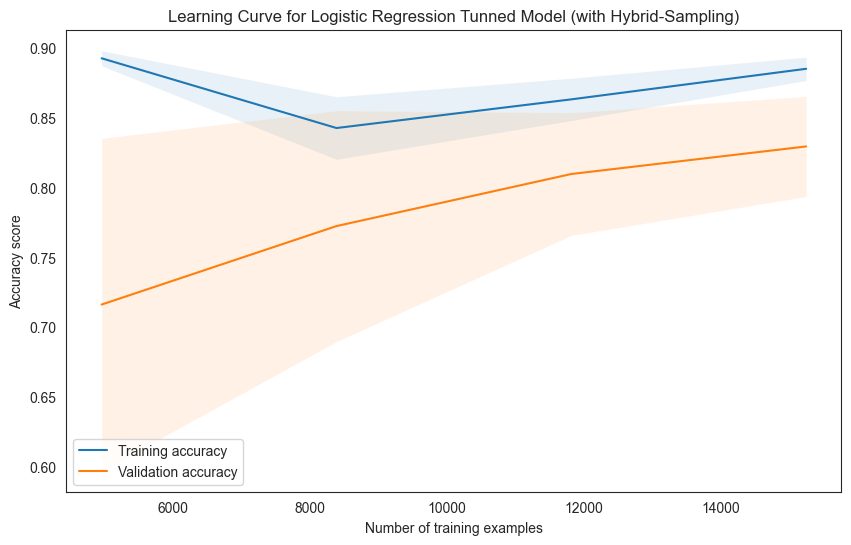

In [226]:
%%time


# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(lr_tuned_smt, X_train_smt, y_train_smt, cv=5, scoring = "f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Logistic Regression Tunned Model (with Hybrid-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Logistic Regression Tuned for Hybrid-Sampling**

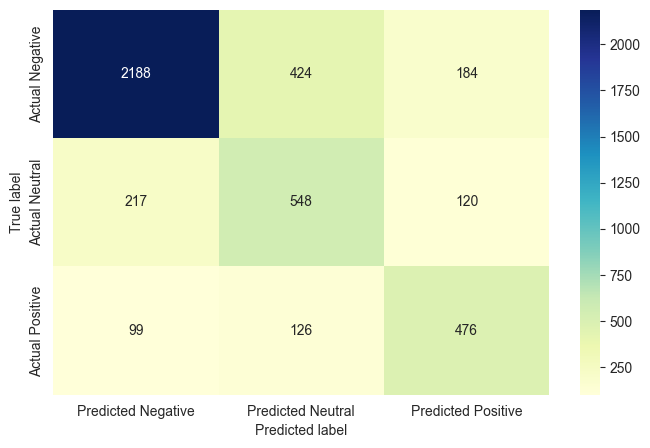

In [227]:
confusion_matrix_sentiment(lr_tuned_smt, X_test_vec, y_test)

**Receiver Operating Characteristic for lr Tuned for Hybrid-Sampling**

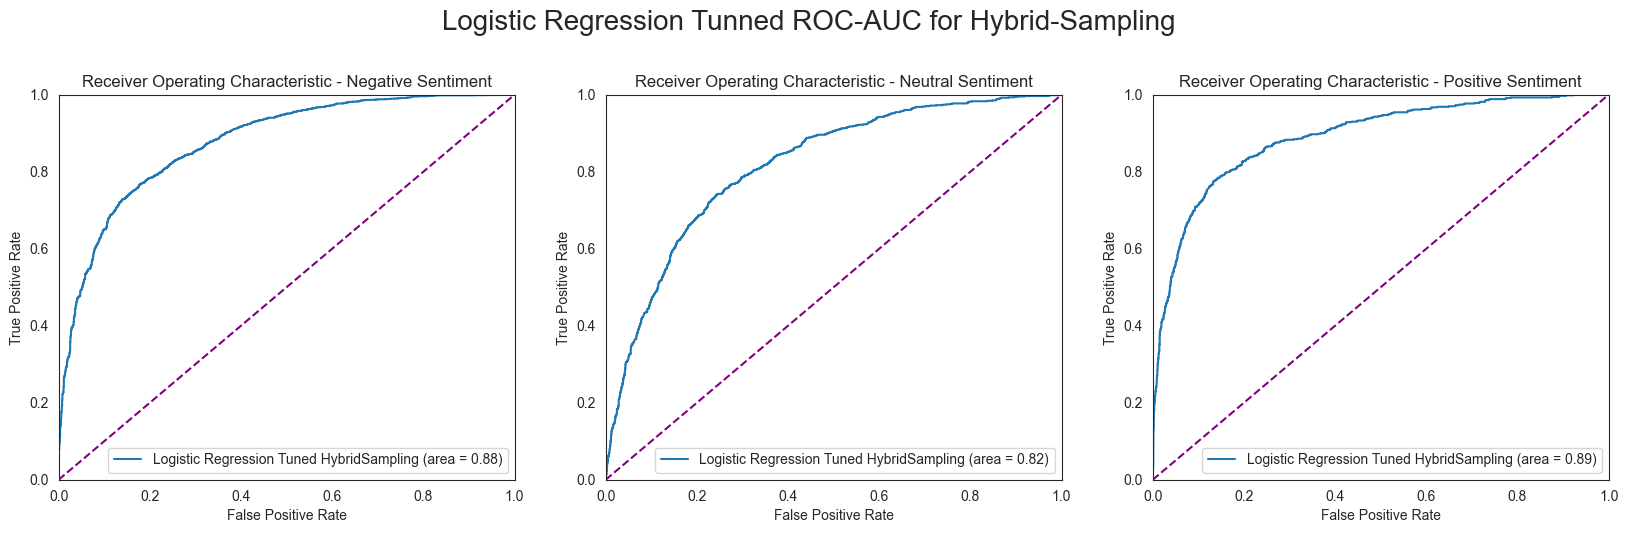

In [228]:
# Calculate AUC score for each sentiment value
lr_smt_roc_auc_0 = roc_auc_score(y_test == 0, lr_tuned_smt.predict_proba(X_test_vec)[:, 0])
lr_smt_roc_auc_1 = roc_auc_score(y_test == 1, lr_tuned_smt.predict_proba(X_test_vec)[:, 1])
lr_smt_roc_auc_2 = roc_auc_score(y_test == 2, lr_tuned_smt.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, lr_tuned_smt.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, lr_tuned_smt.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, lr_tuned_smt.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Logistic Regression Tuned HybridSampling (area = %0.2f)' % lr_smt_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Logistic Regression Tuned HybridSampling (area = %0.2f)' % lr_smt_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Logistic Regression Tuned HybridSampling (area = %0.2f)' % lr_smt_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("Logistic Regression Tunned ROC-AUC for Hybrid-Sampling", fontsize=20, y=1.05)

plt.show()

##### **SVC Model Tunning for Hybrid-Sampling**

In [229]:
%%time
## Tunning the logistic Regression model
# defining model
sl3 = LinearSVC(C=1)

# Parameter grid to pass in GridSearchCV

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'max_iter': [50, 100, 150, 200]
}



grid_cv = GridSearchCV(
    estimator=sl3,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_smt, y_train_smt)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'C': 10, 'dual': True, 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l2'} with CV score=0.8276018785287033:
CPU times: total: 1.66 s
Wall time: 19.4 s


In [230]:
clf_smt_tuned = LinearSVC( 
    C = 10,
    dual = True,
    loss = 'hinge', 
    max_iter = 10,
    penalty = 'l2')

clf_smt_tuned.fit(X_train_smt, y_train_smt)

LinearSVC(C=10, loss='hinge', max_iter=10)

In [231]:
## Checking model performance

# Calculating different metrics on train set
clf_smt_tunned_train = model_performance_classification_sklearn(
    clf_smt_tuned, X_train_smt, y_train_smt)

print("Training performance:")
print(clf_smt_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
clf_smt_tunned_test = model_performance_classification_sklearn(
    clf_smt_tuned, X_test_vec, y_test)

print("Testing performance:")
print(clf_smt_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.826203  0.826203   0.833528  0.824389

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.749658  0.749658   0.743564  0.746006


**Learning Curve for Linear SVC Tuned for Hybrid-Sampling**

CPU times: total: 281 ms
Wall time: 661 ms


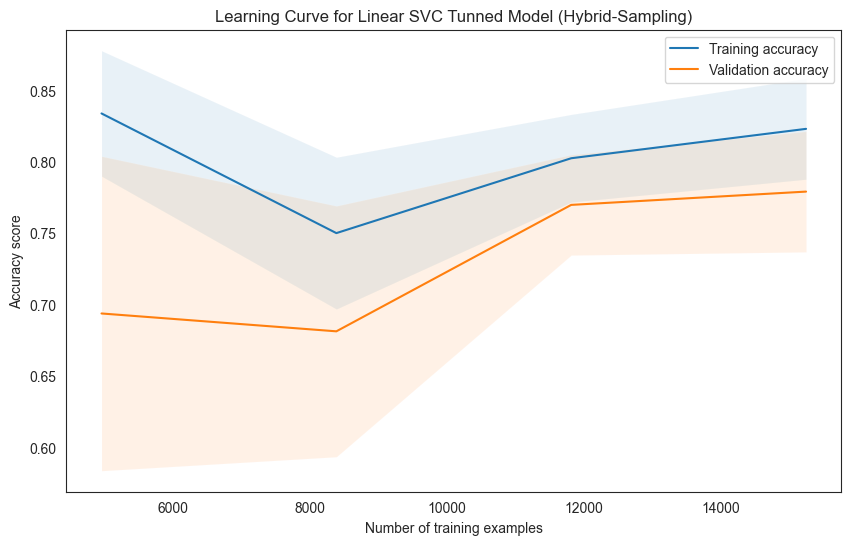

In [232]:
%%time


# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(clf_smt_tuned, X_train_smt, y_train_smt, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Linear SVC Tunned Model (Hybrid-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Linear SVC Tuned for Hybrid-Sampling**

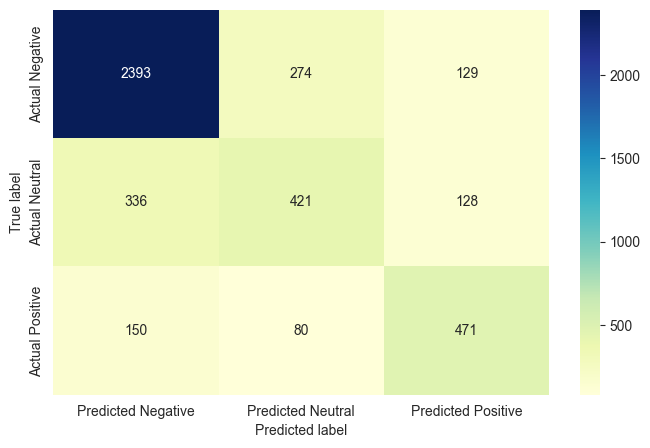

In [233]:
confusion_matrix_sentiment(clf_smt_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for SVC Tuned for Hybrid-Sampling**

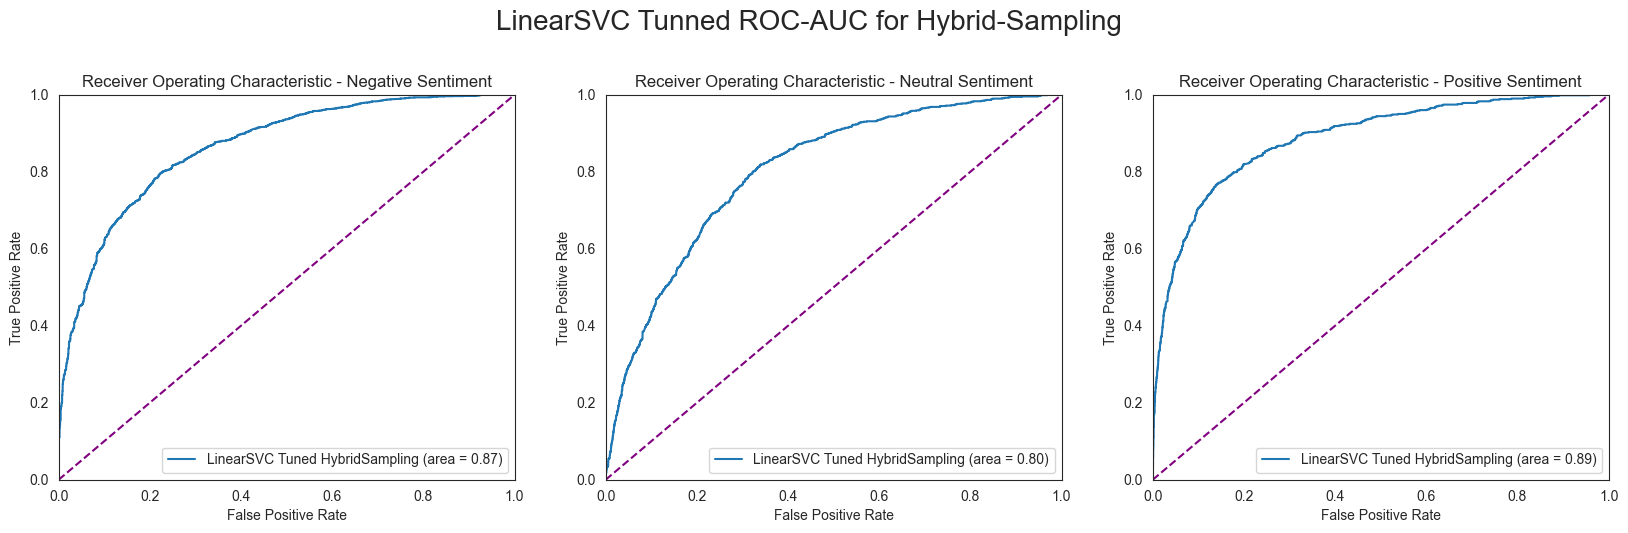

In [234]:
# Calculate AUC score for each sentiment value
clf_smt_tuned_roc_auc_0 = roc_auc_score(y_test == 0, clf_smt_tuned.decision_function(X_test_vec)[:, 0])
clf_smt_tuned_roc_auc_1 = roc_auc_score(y_test == 1, clf_smt_tuned.decision_function(X_test_vec)[:, 1])
clf_smt_tuned_roc_auc_2 = roc_auc_score(y_test == 2, clf_smt_tuned.decision_function(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, clf_smt_tuned.decision_function(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, clf_smt_tuned.decision_function(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, clf_smt_tuned.decision_function(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='LinearSVC Tuned HybridSampling (area = %0.2f)' % clf_smt_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='LinearSVC Tuned HybridSampling (area = %0.2f)' % clf_smt_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='LinearSVC Tuned HybridSampling (area = %0.2f)' % clf_smt_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

plt.suptitle("LinearSVC Tunned ROC-AUC for Hybrid-Sampling", fontsize=20, y=1.05)


plt.show()

##### **Naive Bayes Model Tunning for Hybrid-Sampling**

In [235]:
%%time
## Tunning the logistic Regression model
# defining model
nb4 = MultinomialNB()

# Parameter grid to pass in GridSearchCV

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}



grid_cv = GridSearchCV(
    estimator=nb4,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_smt, y_train_smt)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'alpha': 0.1, 'fit_prior': False} with CV score=0.7876787351376959:
CPU times: total: 109 ms
Wall time: 315 ms


In [236]:
nb_smt_tuned = MultinomialNB( 
    alpha = 0.1, 
    fit_prior = False)

nb_smt_tuned.fit(X_train_smt, y_train_smt)

MultinomialNB(alpha=0.1, fit_prior=False)

In [237]:
## Checking model performance

# Calculating different metrics on train set
nb_smt_tunned_train = model_performance_classification_sklearn(
    nb_smt_tuned, X_train_smt, y_train_smt)

print("Training performance:")
print(nb_smt_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
nb_smt_tunned_test = model_performance_classification_sklearn(
    nb_smt_tuned, X_test_vec, y_test)

print("Testing performance:")
print(nb_smt_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.806624  0.806624    0.80636  0.806475

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.746235  0.746235   0.765233  0.753299


**Learning Curve for Naives Bayes Tuned for Hybrid-Sampling**

CPU times: total: 62.5 ms
Wall time: 282 ms


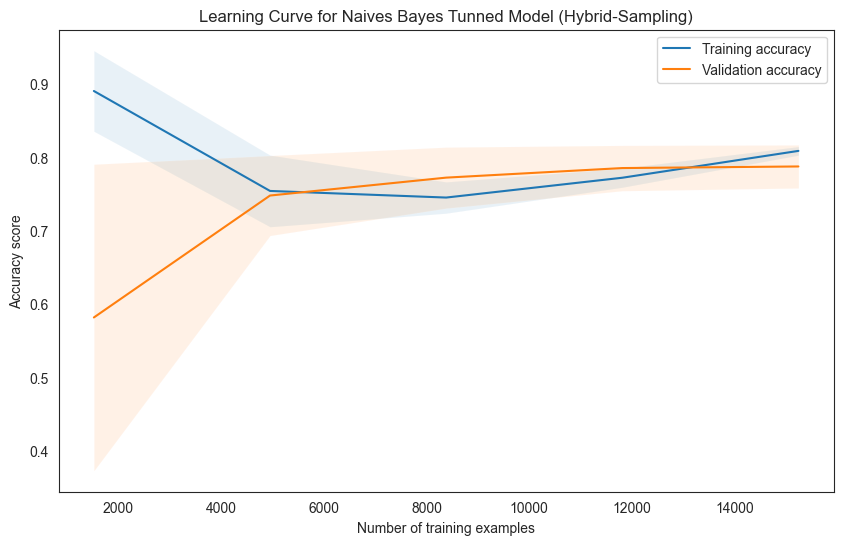

In [238]:
%%time

# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(nb_smt_tuned,X_train_smt, y_train_smt, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Naives Bayes Tunned Model (Hybrid-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Naives Bayes Tuned for Hybrid-Sampling**

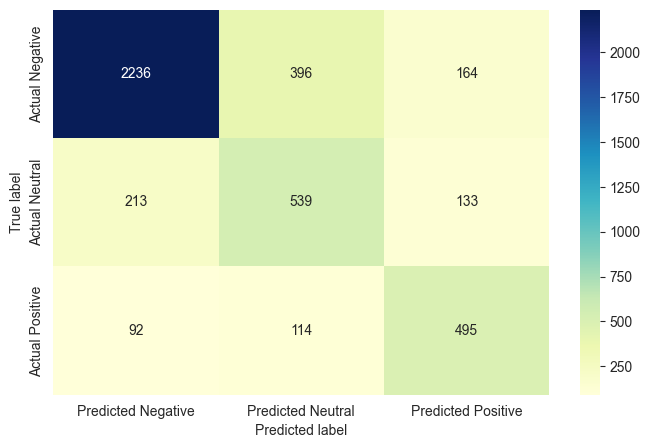

In [239]:
confusion_matrix_sentiment(nb_smt_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Naive Bayes Tuned for Hybrid-Sampling**

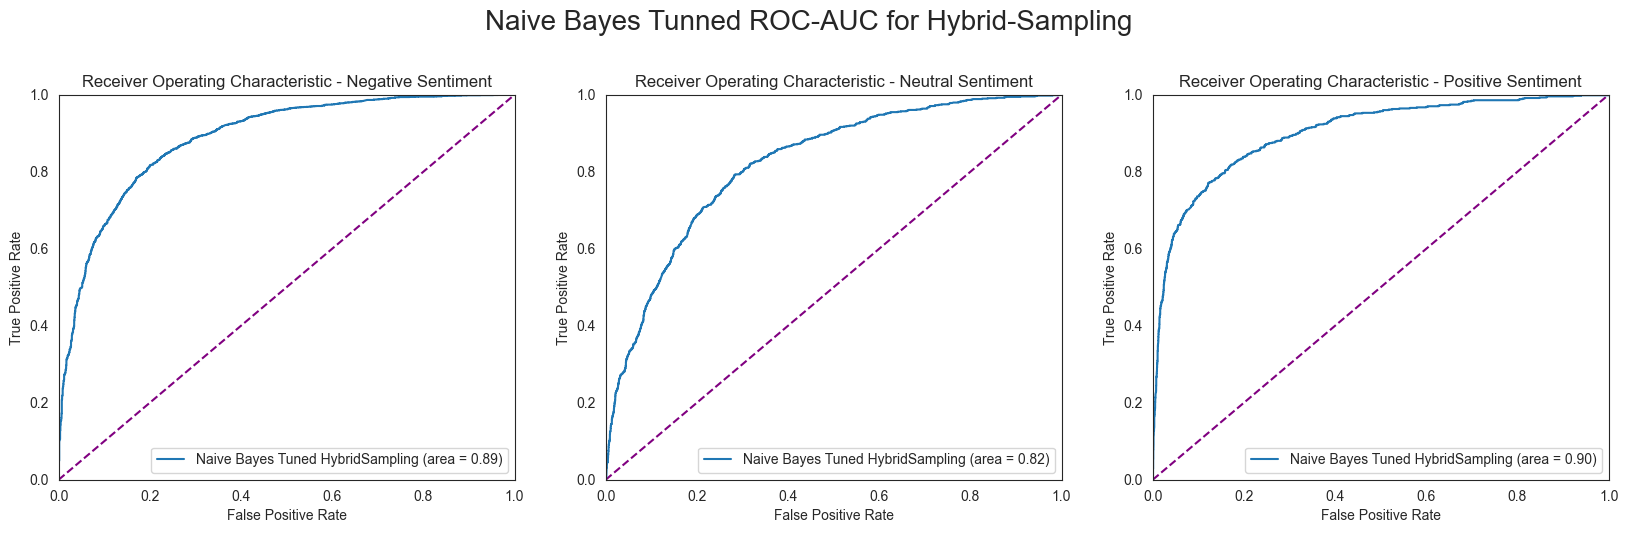

In [240]:
# Calculate AUC score for each sentiment value
nb_smt_tuned_roc_auc_0 = roc_auc_score(y_test == 0, nb_smt_tuned.predict_proba(X_test_vec)[:, 0])
nb_smt_tuned_roc_auc_1 = roc_auc_score(y_test == 1, nb_smt_tuned.predict_proba(X_test_vec)[:, 1])
nb_smt_tuned_roc_auc_2 = roc_auc_score(y_test == 2, nb_smt_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, nb_smt_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, nb_smt_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, nb_smt_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Naive Bayes Tuned HybridSampling (area = %0.2f)' % nb_smt_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Naive Bayes Tuned HybridSampling (area = %0.2f)' % nb_smt_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Naive Bayes Tuned HybridSampling (area = %0.2f)' % nb_smt_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

    
plt.suptitle("Naive Bayes Tunned ROC-AUC for Hybrid-Sampling", fontsize=20, y=1.05)
    

plt.show()

##### **Random Forest Tunning for Hybrid-Sampling**

In [241]:
%%time
## Tunning the logistic Regression model
# defining model
rf3 = RandomForestClassifier()

# Parameter grid to pass in GridSearchCV

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 4, 6, 8, 10, None],
    "max_features": ["sqrt", "log2"],
    "n_estimators": [20, 60, 80, 100],
    # "class_weight": ["balanced", "balanced_subsample"],
    "bootstrap": [True, False]
}



grid_cv = GridSearchCV(
    estimator=rf3,
    param_grid = param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_smt, y_train_smt)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 80} with CV score=0.9076909245892757:
CPU times: total: 14.2 s
Wall time: 16min 49s


In [242]:
rfc_smt_tuned = RandomForestClassifier( 
    n_estimators = 100, 
    max_features = 'log2', 
    max_depth = None, 
    criterion = 'gini',
    bootstrap = False
)

rfc_smt_tuned.fit(X_train_smt, y_train_smt)

RandomForestClassifier(bootstrap=False, max_features='log2')

In [243]:
## Checking model performance

# Calculating different metrics on train set
rfc_smt_tunned_train = model_performance_classification_sklearn(
    rfc_smt_tuned, X_train_smt, y_train_smt)

print("Training performance:")
print(rfc_smt_tunned_train)

print()
print("*"*70)
print()

# Calculating different metrics on test set
rfc_smt_tunned_test = model_performance_classification_sklearn(
    rfc_smt_tuned, X_test_vec, y_test)

print("Testing performance:")
print(rfc_smt_tunned_test)

Training performance:
   Accuracy    Recall  Precision       F1
0  0.990499  0.990499   0.990556  0.99051

**********************************************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.759927  0.759927    0.75067  0.753136


**Learning Curve for Random Forest Tunned Model for Hybrid-Sampling**

CPU times: total: 1min 33s
Wall time: 4min 38s


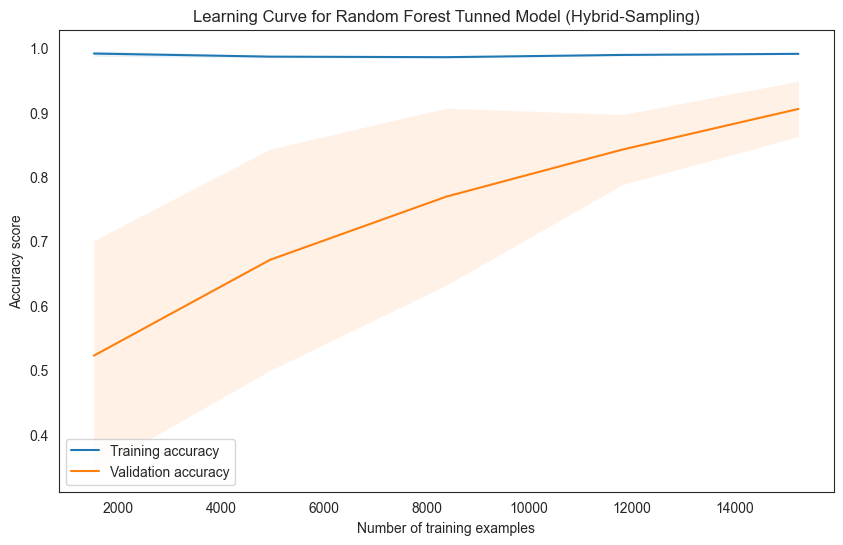

In [244]:
%%time
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(rfc_smt_tuned, X_train_smt, y_train_smt, cv=5, scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for Random Forest Tunned Model (Hybrid-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for Random Forest Tunned Model for Hybrid-Sampling**

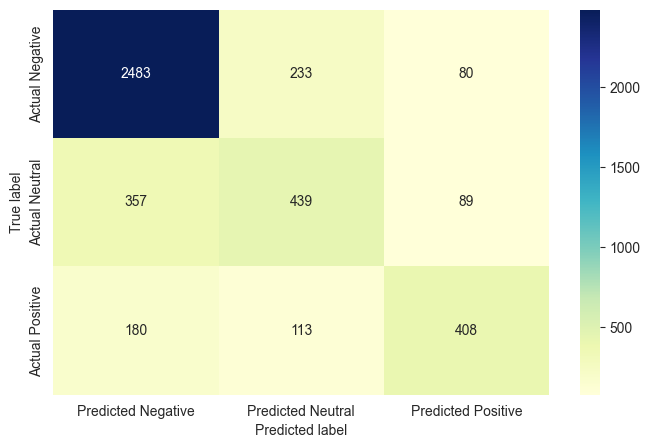

In [245]:
confusion_matrix_sentiment(rfc_smt_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for Random Forest Tuned for Hybrid-Sampling**

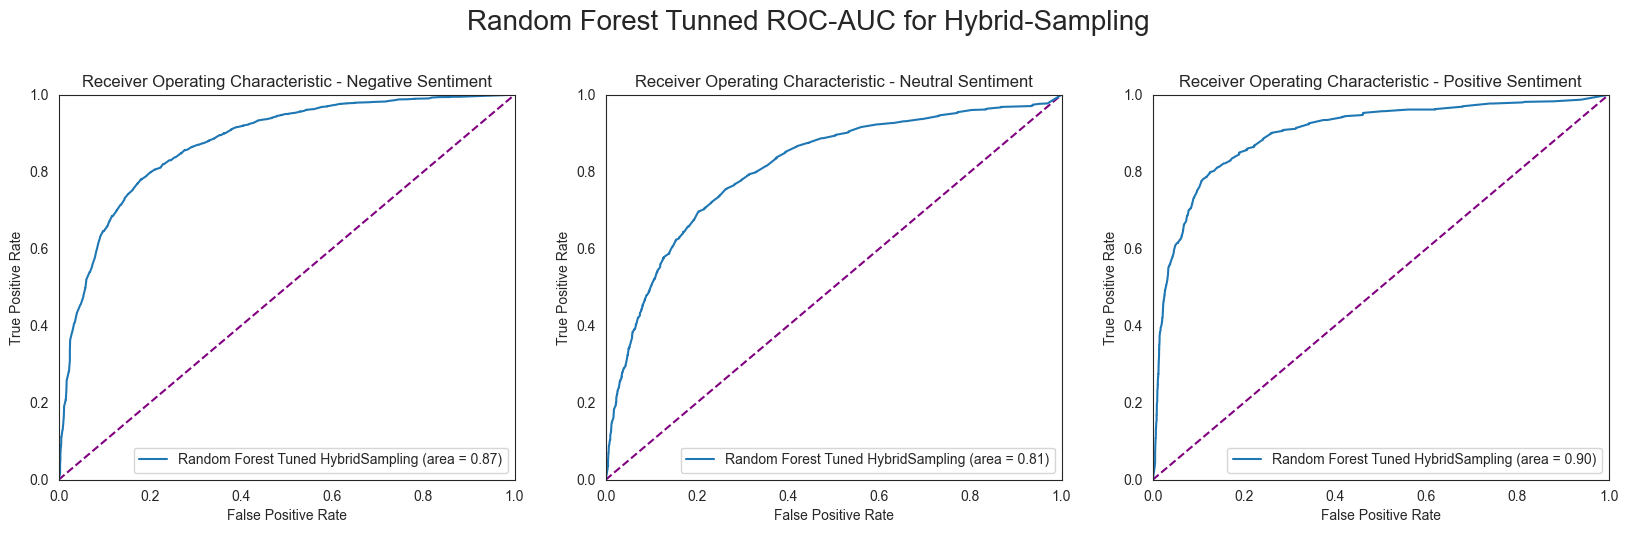

In [246]:
# Calculate AUC score for each sentiment value
rfc_smt_tuned_roc_auc_0 = roc_auc_score(y_test == 0, rfc_smt_tuned.predict_proba(X_test_vec)[:, 0])
rfc_smt_tuned_roc_auc_1 = roc_auc_score(y_test == 1, rfc_smt_tuned.predict_proba(X_test_vec)[:, 1])
rfc_smt_tuned_roc_auc_2 = roc_auc_score(y_test == 2, rfc_smt_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, rfc_smt_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, rfc_smt_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, rfc_smt_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='Random Forest Tuned HybridSampling (area = %0.2f)' % rfc_smt_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='Random Forest Tuned HybridSampling (area = %0.2f)' % rfc_smt_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='Random Forest Tuned HybridSampling (area = %0.2f)' % rfc_smt_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")


plt.suptitle("Random Forest Tunned ROC-AUC for Hybrid-Sampling", fontsize=20, y=1.05)


plt.show()

##### **XGBoost Tunning for Hybrid-Sampling**

In [247]:
%%time
# defining model
xgb3 = XGBClassifier()


# Define the parameter grid
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.5, 0.75],
    'min_child_weight': [1, 3],
}



grid_cv = GridSearchCV(
    estimator=xgb3,
    param_grid=param_grid,
    scoring = "f1_macro",  # set the scoring metric to F1 score with macro averaging
    cv=5,
    n_jobs=-1,
)

# # Fitting parameters in GridSearchCV
grid_cv.fit(X_train_smt, y_train_smt)

print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'colsample_bytree': 0.75, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.75} with CV score=0.7695256338108666:
CPU times: total: 26.6 s
Wall time: 13min 6s


In [248]:
# building model with best parameters
xgb_smt_tuned =  XGBClassifier(
    colsample_bytree = 0.75,
    gamma = 0.1,
    learning_rate = 0.1,
    max_depth = 5, 
    min_child_weight = 1,
    n_estimators = 100,
    subsample = 0.75
)

# Fit the model on training data
xgb_smt_tuned.fit(X_train_smt, y_train_smt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [249]:
## Checking model performance

# Calculating different metrics on train set
xgb_smt_tunned_train = model_performance_classification_sklearn(
    xgb_smt_tuned, X_train_smt, y_train_smt
)
print("Training performance:")
print(xgb_smt_tunned_train)

print()
print("*************************************")
print()

# Calculating different metrics on test set
xgb_smt_tunned_test = model_performance_classification_sklearn(
    xgb_smt_tuned, X_test_vec, y_test
)
print("Testing performance:")
print(xgb_smt_tunned_test)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.799013  0.799013   0.802886  0.799722

*************************************

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.737335  0.737335   0.744556  0.740297


**Learning Curve for XGBoost Tunned Model for Hybrid-Sampling**

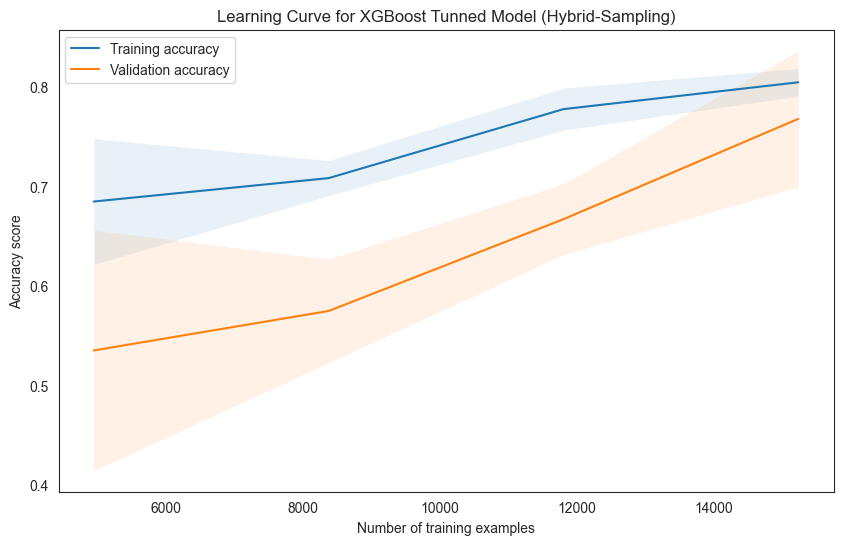

In [250]:
# Calculate the learning curves
train_sizes, train_scores, test_scores = learning_curve(xgb_smt_tuned, X_train_smt, y_train_smt, cv=5,scoring="f1_macro")

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training accuracy")
plt.plot(train_sizes, test_mean, label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title("Learning Curve for XGBoost Tunned Model (Hybrid-Sampling)")
plt.xlabel("Number of training examples")
plt.ylabel("Accuracy score")
plt.grid(False)
plt.legend();

**Confusion Matrix for XGBoost Tunned Model for Hybrid-sampling**

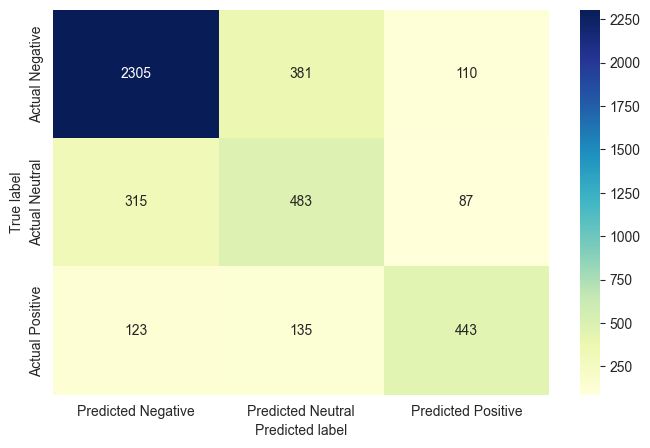

In [251]:
# creating confusion matrix
confusion_matrix_sentiment(xgb_smt_tuned, X_test_vec, y_test)

**Receiver Operating Characteristic for XGBoost Tuned for Hybrid-Sampling**

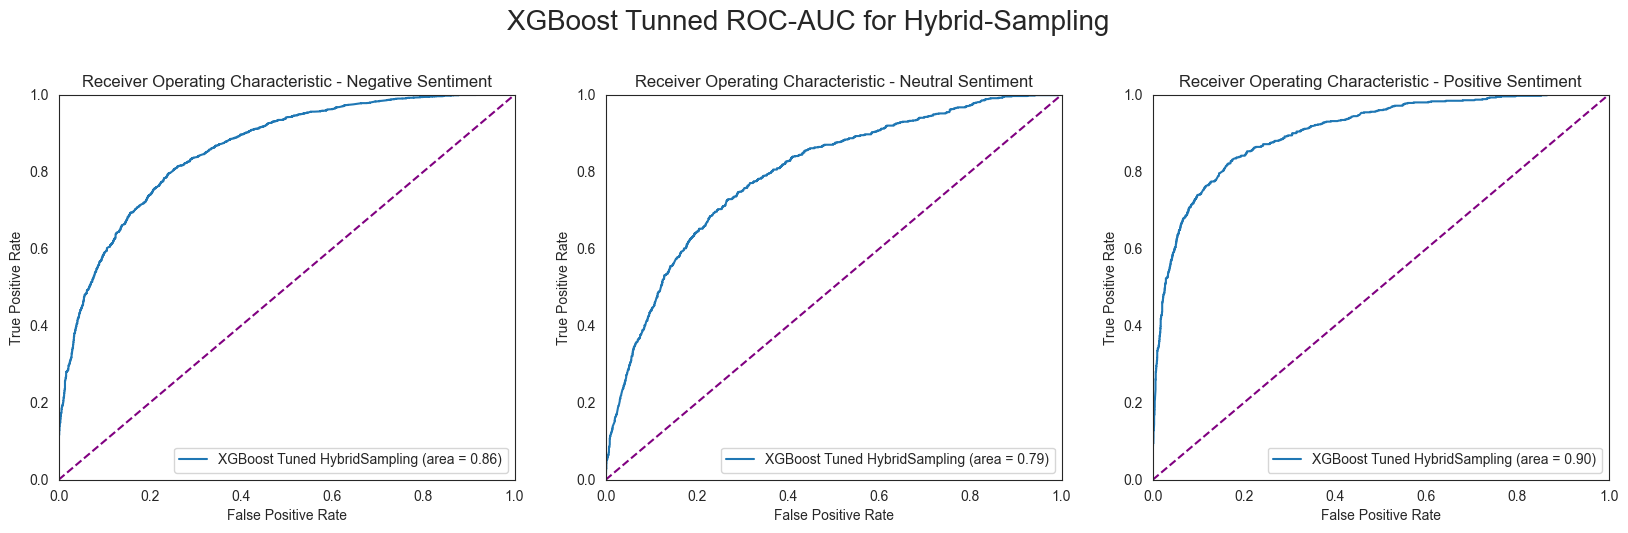

In [252]:
# Calculate AUC score for each sentiment value
xgb_smt_tuned_roc_auc_0 = roc_auc_score(y_test == 0, xgb_smt_tuned.predict_proba(X_test_vec)[:, 0])
xgb_smt_tuned_roc_auc_1 = roc_auc_score(y_test == 1, xgb_smt_tuned.predict_proba(X_test_vec)[:, 1])
xgb_smt_tuned_roc_auc_2 = roc_auc_score(y_test == 2, xgb_smt_tuned.predict_proba(X_test_vec)[:, 2])

# Calculate FPR, TPR, and thresholds for each sentiment value
fpr_0, tpr_0, threshold_0 = roc_curve(y_test == 0, xgb_smt_tuned.predict_proba(X_test_vec)[:, 0])
fpr_1, tpr_1, threshold_1 = roc_curve(y_test == 1, xgb_smt_tuned.predict_proba(X_test_vec)[:, 1])
fpr_2, tpr_2, threshold_2 = roc_curve(y_test == 2, xgb_smt_tuned.predict_proba(X_test_vec)[:, 2])

# Plot ROC curves for each sentiment value side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, ax in enumerate(axs):
    ax.plot([0, 1], [0, 1],'r--', color="purple")
    if i == 0:
        ax.plot(fpr_0, tpr_0, label='XGBoost Tuned HybridSampling (area = %0.2f)' % xgb_smt_tuned_roc_auc_0)
        ax.set_title('Receiver Operating Characteristic - Negative Sentiment')
    elif i == 1:
        ax.plot(fpr_1, tpr_1, label='XGBoost Tuned HybridSampling (area = %0.2f)' % xgb_smt_tuned_roc_auc_1)
        ax.set_title('Receiver Operating Characteristic - Neutral Sentiment')
    else:
        ax.plot(fpr_2, tpr_2, label='XGBoost Tuned HybridSampling (area = %0.2f)' % xgb_smt_tuned_roc_auc_2)
        ax.set_title('Receiver Operating Characteristic - Positive Sentiment')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    
plt.suptitle("XGBoost Tunned ROC-AUC for Hybrid-Sampling", fontsize=20, y=1.05)


plt.show()

##### **Comparing all Hybrid-Sampling models**

**Training Performance for all Hybrid-Sampling Models**

In [253]:
# training performance comparison for Hybrid-Sampling Models

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

HybridSampling_tunned_models_train_comp = pd.concat(
    [
        
        lr_tunned_smt_train.T,
        clf_smt_tunned_train.T,
        nb_smt_tunned_train.T,
        rfc_smt_tunned_train.T,
        xgb_smt_tunned_train.T
    ],
    axis=1,
)
HybridSampling_tunned_models_train_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV HybridSampling",
    "Linear SVC Tuned with Grid SearchCV hybridSampling",
    "Naives Bayes Tuned with Grid SearchCV hybridSampling",
    "Random Forest Tuned with Grid SearchCV hybridSampling",
    "XGBoost Tuned with Grid SearchCV hybridSampling"
]
print_formatted("Training Performance Comparison for Tuned with Grid Search with Hybrid-Sampling Balanced Data:")
HybridSampling_tunned_models_train_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Training Performance Comparison for Tuned with Grid Search with Hybrid-Sampling Balanced Data:</p>

Logistic Regression Tuned with Grid SearchCV HybridSampling  \
Accuracy                                                      0.877382   
Recall                                                        0.877382   
Precision                                                     0.878409   
F1                                                            0.877496   

           Linear SVC Tuned with Grid SearchCV hybridSampling  \
Accuracy                                             0.826203   
Recall                                               0.826203   
Precision                                            0.833528   
F1                                                   0.824389   

           Naives Bayes Tuned with Grid SearchCV hybridSampling  \
Accuracy                                               0.806624   
Recall                                                 0.806624   
Precision                                              0.806360   
F1                                                     0.806475   

           Random Forest Tuned with Grid SearchCV hybridSampling  \
Accuracy                                                0.990499   
Recall                                                  0.990499   
Precision                                               0.990556   
F1                                                      0.990510   

           XGBoost Tuned with Grid SearchCV hybridSampling  
Accuracy                                          0.799013  
Recall                                            0.799013  
Precision                                         0.802886  
F1                                                0.799722

**Testing Performance for all Hybrid-Sampling Models**

In [254]:
# training performance comparison fir HybridHybrid-Sampling Models

# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))

HybridSampling_tunned_models_test_comp = pd.concat(
    [
        
        lr_tunned_smt_test.T,
        clf_smt_tunned_test.T,
        nb_smt_tunned_test.T,
        rfc_smt_tunned_test.T,
        xgb_smt_tunned_test.T
    ],
    axis=1,
)
HybridSampling_tunned_models_test_comp.columns = [
    "Logistic Regression Tuned with Grid SearchCV HybridSampling",
    "Linear SVC Tuned with Grid SearchCV HybridSampling",
    "Naives Bayes Tuned with Grid SearchCV HybridSampling",
    "Random Forest Tuned with Grid SearchCV HybridSampling",
    "XGBoost Tuned with Grid SearchCV HybridSampling"
]
print_formatted("Testing Performance Comparison for Tuned with Grid Search with Hybrid-Sampling Balanced Data:")
HybridSampling_tunned_models_test_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>Testing Performance Comparison for Tuned with Grid Search with Hybrid-Sampling Balanced Data:</p>

Logistic Regression Tuned with Grid SearchCV HybridSampling  \
Accuracy                                                      0.732999   
Recall                                                        0.732999   
Precision                                                     0.755964   
F1                                                            0.741281   

           Linear SVC Tuned with Grid SearchCV HybridSampling  \
Accuracy                                             0.749658   
Recall                                               0.749658   
Precision                                            0.743564   
F1                                                   0.746006   

           Naives Bayes Tuned with Grid SearchCV HybridSampling  \
Accuracy                                               0.746235   
Recall                                                 0.746235   
Precision                                              0.765233   
F1                                                     0.753299   

           Random Forest Tuned with Grid SearchCV HybridSampling  \
Accuracy                                                0.759927   
Recall                                                  0.759927   
Precision                                               0.750670   
F1                                                      0.753136   

           XGBoost Tuned with Grid SearchCV HybridSampling  
Accuracy                                          0.737335  
Recall                                            0.737335  
Precision                                         0.744556  
F1                                                0.740297

##### **Comparing all AUC-ROC for Hybrid-Sampling Balanced Models**

In [255]:
# AUC-ROC performance comparison for all Hybrid-Sampling Models


# create a function to print formatted text
def print_formatted(text):
    display(Markdown(f"<p style='text-align: center; font-size: 16px; font-weight: bold'>{text}</p>"))


# Create pandas Series for each model
HybridSampling_log_series = pd.Series([lr_smt_roc_auc_0, lr_smt_roc_auc_1, lr_smt_roc_auc_2], name='Logistic Regression AUC-ROC Tuned HybridSampling')
HybridSampling_svc_series = pd.Series([clf_smt_tuned_roc_auc_0, clf_smt_tuned_roc_auc_1, clf_smt_tuned_roc_auc_2], name='Linear SVC AUC-ROC Tuned HybridSampling')
HybridSampling_nb_series = pd.Series([nb_smt_tuned_roc_auc_0, nb_smt_tuned_roc_auc_1, nb_smt_tuned_roc_auc_2], name='Naive Bayes AUC-ROC Tuned HybridSampling')
HybridSampling_rfc_series = pd.Series([rfc_smt_tuned_roc_auc_0, rfc_smt_tuned_roc_auc_1, rfc_smt_tuned_roc_auc_2], name='Random Forest AUC-ROC Tuned HybridSampling')
HybridSampling_xgb_series = pd.Series([xgb_smt_tuned_roc_auc_0, xgb_smt_tuned_roc_auc_1, xgb_smt_tuned_roc_auc_2], name='XGBoost AUC-ROC Tuned HybridSampling')



HybridSampling_tunned_roc_comp = pd.concat(
    [
        HybridSampling_log_series.T,
        HybridSampling_svc_series.T,
       HybridSampling_nb_series.T,
        HybridSampling_rfc_series.T,
        HybridSampling_xgb_series.T
    ],
    axis=1,
)


print_formatted("AUC-ROC Performance Comparison for Tuned with Grid Search with Hybrid-Sampling Balanced Data:")

HybridSampling_tunned_roc_comp

<p style='text-align: center; font-size: 16px; font-weight: bold'>AUC-ROC Performance Comparison for Tuned with Grid Search with Hybrid-Sampling Balanced Data:</p>

Logistic Regression AUC-ROC Tuned HybridSampling  \
0                                          0.876387   
1                                          0.815400   
2                                          0.890067   

   Linear SVC AUC-ROC Tuned HybridSampling  \
0                                 0.865032   
1                                 0.802617   
2                                 0.886723   

   Naive Bayes AUC-ROC Tuned HybridSampling  \
0                                  0.886327   
1                                  0.820132   
2                                  0.901597   

   Random Forest AUC-ROC Tuned HybridSampling  \
0                                    0.873982   
1                                    0.808413   
2                                    0.899302   

   XGBoost AUC-ROC Tuned HybridSampling  
0                              0.858062  
1                              0.793730  
2                              0.904229

## Save the Model for Deployment Stage